# Preparing Data

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import gurobipy as gp
from gurobipy import GRB
import math
from itertools import cycle

C:\Users\Cole\anaconda3\envs\generative_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [3]:
image_width, image_height = 14, 14 # 28, 28
window_size = 2
epsilon = 0.000000001
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor(), transforms.Resize([image_width, image_height])])
)

In [5]:
batch_size = 30 # MUST BE EVENLY DIVISIBLE BY 10

# not sure what "...and so on" implies, but define this list however you like
target_classes = [i // (batch_size / 10) for i in range(batch_size)]

# create cyclic iterators of indices for each class in MNIST
indices = dict()
for label in torch.unique(training_data.targets).tolist():
    indices[label] = cycle(torch.nonzero(training_data.targets == label).flatten().tolist())

# define the order of indices in the new mnist subset based on target_classes
new_indices = []
for t in target_classes:
    new_indices.append(next(indices[t]))

# create a Subset of MNIST based on new_indices
mnist_modified = torch.utils.data.Subset(training_data, new_indices)
dataloader = torch.utils.data.DataLoader(mnist_modified, batch_size=batch_size, shuffle=False)

for idx, (x, y) in enumerate(dataloader):
    # training loop
    print(f'Batch {idx+1} labels: {y.tolist()}')

Batch 1 labels: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]


tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7,
        8, 8, 8, 9, 9, 9])
torch.Size([14, 14])


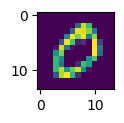

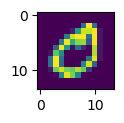

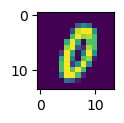

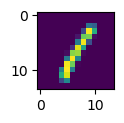

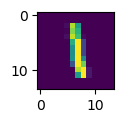

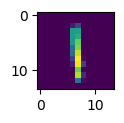

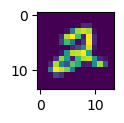

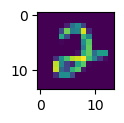

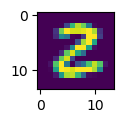

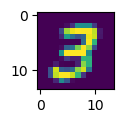

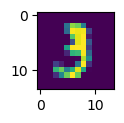

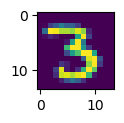

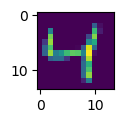

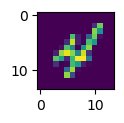

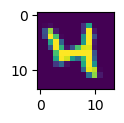

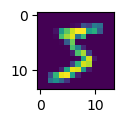

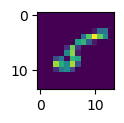

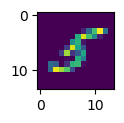

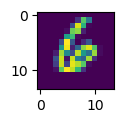

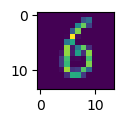

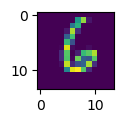

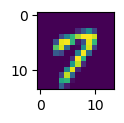

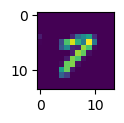

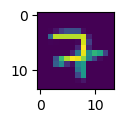

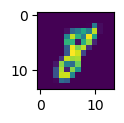

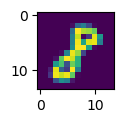

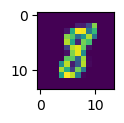

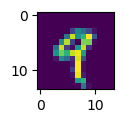

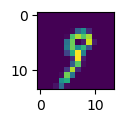

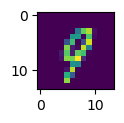

In [6]:
dataset = next(enumerate(dataloader))[1]
print(dataset[1])
print(dataset[0][1, 0].shape)
for img in range(len(dataset[1])):
    plt.figure(figsize=[1, 1])
    plt.imshow(dataset[0][img, 0])
    plt.show()

# Constraints:
- pixels don't criss-cross
- all source pixels used
- all dest pixels mapped

# Objective:
minimize mapped L2 distance

In [63]:
m = gp.Model("image_similarity")
m.Params.LogToConsole = 0
m.setParam("Method", 3)

# initialize pixel shift values
image_shift_values = m.addVars(image_width, image_height, (2*window_size+1), (2*window_size+1), vtype=variable_type, lb=0, ub=1, name="shifts")

# add constraints that if a pixel shift is outside image, it must be 0
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        for x_shift in range(2*window_size+1):
            for y_shift in range(2*window_size+1):
                if x_pixel + (x_shift - window_size) < 0 or x_pixel + (x_shift - window_size) > image_width-1 or y_pixel + (y_shift - window_size) < 0 or y_pixel + (y_shift - window_size) > image_height-1:
                    m.addConstr(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] == 0)


# constraints that all source pixels must shift in at least 1 direction
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        m.addConstr(gp.quicksum(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1)) >= 1)

# constraints that all dest pixels must be mapped to
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        m.addConstr(gp.quicksum(image_shift_values[x_pixel - (x_shift - window_size), y_pixel - (y_shift - window_size), x_shift, y_shift] \
                                for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1) \
                                if x_pixel - (x_shift - window_size) >= 0 and x_pixel - (x_shift - window_size) < image_width and y_pixel - (y_shift - window_size) >= 0 and y_pixel - (y_shift - window_size) < image_height) \
                    >= 1)

# def add_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
#     if x_shift != 2*window_size:
#         max1 = m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         max2 = m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift, 2*window_size+1) for yShifts in range(2*window_size+1)))
#         m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1, 2*window_size+1) for yShifts in range(2*window_size+1)))
#         m.addConstr(max1 >= max2)
#     max1 = m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#     max2 = m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#     m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(0, x_shift+1) for yShifts in range(2*window_size+1)))
#     m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(0, min(x_shift+2, 2*window_size+1)) for yShifts in range(2*window_size+1)))
#     m.addConstr(max1 <= max2)

def add_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size:
        max1 = m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(0, x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(0, x_shift+2) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
        
# def add_down_constraint(x_pixel, y_pixel, x_shift, y_shift):
#     if y_shift != 2*window_size:
#         max1 = m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         max2 = m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(y_shift, 2*window_size+1) for xShifts in range(2*window_size+1)))
#         m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for yShifts in range(y_shift+1, 2*window_size+1) for xShifts in range(2*window_size+1)))
#         m.addConstr(max1 >= max2)
#     max1 = m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#     max2 = m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#     m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(0, x_shift+1) for xShifts in range(2*window_size+1)))
#     m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for yShifts in range(0, min(x_shift+2, 2*window_size+1)) for xShifts in range(2*window_size+1)))
#     m.addConstr(max1 <= max2)

def add_down_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if y_shift != 2*window_size:
        max1 = m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(y_shift, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for yShifts in range(y_shift+1, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(0, y_shift+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for yShifts in range(0, y_shift+2) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
        
# def add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
#     if y_shift != 2*window_size and x_shift != 2*window_size:
#         max1 = m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         max2 = m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(2*window_size+1) for xShifts in range(2*window_size+1) if yShifts >= y_shift and xShifts >= x_shift))
#         m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for yShifts in range(2*window_size+1) for xShifts in range(2*window_size+1) if yShifts >= y_shift+1 and xShifts >= x_shift+1))
#         m.addConstr(max1 >= max2)
#         max1 = m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         max2 = m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
#         m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(2*window_size+1) for xShifts in range(2*window_size+1) if yShifts <= y_shift+1 and xShifts <= x_shift+1))
#         m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for yShifts in range(2*window_size+1) for xShifts in range(2*window_size+1) if yShifts <= y_shift+2 and xShifts <= x_shift+2))
#         m.addConstr(max1 <= max2)

def add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size:
        max1 = m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(x_shift+1, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(0, x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(0, x_shift+2) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
    if y_shift != 2*window_size:
        max1 = m.addVar(name=f"gmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"gmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(y_shift, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for yShifts in range(y_shift+1, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"hmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"hmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(0, y_shift+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for yShifts in range(0, y_shift+2) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
        
def add_upleft_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size:
        max1 = m.addVar(name=f"imax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"imax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(x_shift+1, 2*window_size+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"jmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"jmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(0, x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(0, x_shift+2) for yShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
    if y_shift != 2*window_size:
        max1 = m.addVar(name=f"kmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"kmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for yShifts in range(y_shift, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(y_shift+1, 2*window_size+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 >= max2)
        max1 = m.addVar(name=f"lmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"lmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for yShifts in range(0, y_shift+1) for xShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(0, y_shift+2) for xShifts in range(2*window_size+1)))
        m.addConstr(max1 <= max2)
        
        
# def add_blob_consistency_constraint(x_pixel, y_pixel, x_shift, y_shift):
#     m.addConstr(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] <= gp.quicksum(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(max(0, y_shift-1), min(y_shift+2, 2*window_size+1)) for xShifts in range(max(0, x_shift-1), min(x_shift+2, 2*window_size+1)) if xShifts != x_shift and yShifts != y_shift))
        
        
# add constraints that pixel shifts must be consistent
for x_pixel in range(image_width):
    # print(x_pixel)
    for y_pixel in range(image_height):
        for x_shift in range(2*window_size+1):
            for y_shift in range(2*window_size+1):
#                 add_blob_consistency_constraint(x_pixel, y_pixel, x_shift, y_shift)
                if y_pixel == 0 and x_pixel == 0:
                    continue
                elif y_pixel == 0:
                    add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                elif x_pixel == 0:
                    add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                else:
                    add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                if y_pixel != image_height-1 and x_pixel != 0:
                    add_upleft_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    
def initialize_model_values():
    for x_pixel in range(image_width):
        for y_pixel in range(image_height):
            for x_shift in range(2*window_size+1):
                for y_shift in range(2*window_size+1):
                    if x_shift == window_size and y_shift == window_size:
                        image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 1
                    else:
                        image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 0
                        
initialize_model_values()

Set parameter Method to value 3


In [64]:
def get_similarity(img1, img2, image_width, image_height, window_size, verbose=False):

    # set objective function
    m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - window_size), y_pixel + (y_shift - window_size)]).item() ** 2) * image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(image_width) for y_pixel in range(image_height) for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1) if x_pixel + (x_shift - window_size) >= 0 and x_pixel + (x_shift - window_size) <= image_width-1 and y_pixel + (y_shift - window_size) >= 0 and y_pixel + (y_shift - window_size) <= image_height-1)\
                   + (epsilon*gp.quicksum(image_shift_values)), GRB.MINIMIZE)
    m.optimize() 
    optimal_value = m.objVal
    
    return optimal_value

In [65]:
def get_similarity_score(image1, image2, image_width, image_height, window_size, verbose=False):
    initialize_model_values()
    val1 = get_similarity(image1, image2, image_width, image_height, window_size, verbose)
    initialize_model_values()
    val2 = get_similarity(image2, image1, image_width, image_height, window_size, verbose)
#     val2 = 0
    print([val1, val2])
    return max(val1, val2)

In [66]:
def generate_mapped_img(source_img):
    
    generated_img = torch.zeros(source_img.shape)
    
    shift_vals = m.getVars()
    
    for val in shift_vals:
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            if "shifts" not in val.VarName:
                continue
            if source_img[int(index[0]), int(index[1])] > 0:
                generated_img[int(index[0]) + int(index[2])-window_size, int(index[1]) + int(index[3])-window_size] = max(source_img[int(index[0]), int(index[1])], \
                                                                                                                         generated_img[int(index[0]) + int(index[2])-window_size, int(index[1]) + int(index[3])-window_size])
    plt.imshow(generated_img)
    plt.show()

0


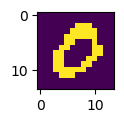

[3.510000000000002e-07, 4.1000000000000026e-07]
4.1000000000000026e-07
[2.7600000000000004e-07, 3.150000000000001e-07]
3.150000000000001e-07
[6.0000002930000065, 2.0000003780000033]
6.0000002930000065
[17.000000382000007, 10.000000390000015]
17.000000382000007
[21.000000286000017, 14.000000387000014]
21.000000286000017
[3.900000000000003e-07, 2.48e-07]
3.900000000000003e-07
[4.090000000000003e-07, 4.0400000000000023e-07]
4.090000000000003e-07
[2.54e-07, 4.150000000000004e-07]
4.150000000000004e-07
[3.980000000000003e-07, 3.560000000000002e-07]
3.980000000000003e-07
[2.000000370000005, 3.440000000000001e-07]
2.000000370000005
[5.0000002680000035, 3.00000037400001]
5.0000002680000035
[11.000000384000018, 10.000000405000018]
11.000000384000018
[2.68e-07, 3.8400000000000026e-07]
3.8400000000000026e-07
[6.000000343000012, 1.0000004090000039]
6.000000343000012
[2.000000361000003, 1.0000003490000018]
2.000000361000003
[3.000000391000003, 3.000000368000007]
3.000000391000003
[1.000000393000001

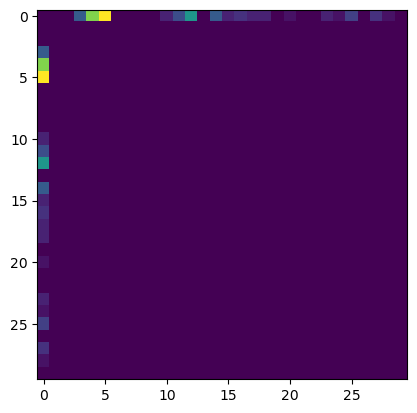

1


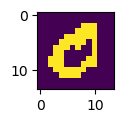

[3.7700000000000027e-07, 3.920000000000003e-07]
3.920000000000003e-07
[8.000000284000008, 1.0000003780000026]
8.000000284000008
[18.00000025900001, 12.000000391000018]
18.00000025900001
[22.000000356000015, 17.00000039400002]
22.000000356000015
[4.130000000000002e-07, 4.2400000000000036e-07]
4.2400000000000036e-07
[1.0000003720000017, 1.0000004070000013]
1.0000004070000013
[3.550000000000002e-07, 3.6100000000000023e-07]
3.6100000000000023e-07
[4.040000000000003e-07, 3.8400000000000026e-07]
4.040000000000003e-07
[1.000000394000004, 3.870000000000003e-07]
1.000000394000004
[4.000000417000008, 2.0000003800000057]
4.000000417000008
[8.00000033500001, 5.000000352000006]
8.00000033500001
[3.7600000000000024e-07, 3.7300000000000023e-07]
3.7600000000000024e-07
[4.000000348000005, 3.6000000000000026e-07]
4.000000348000005
[4.000000361000004, 3.000000375000003]
4.000000361000004
[3.0000003700000057, 3.000000363000003]
3.0000003700000057
[3.960000000000003e-07, 3.910000000000003e-07]
3.9600000000

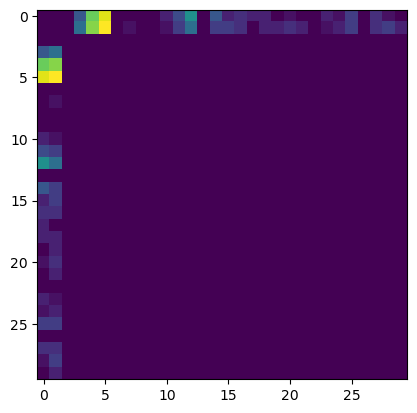

2


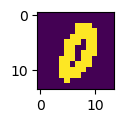

[2.000000390000003, 3.8600000000000025e-07]
2.000000390000003
[8.000000308000008, 4.000000376000008]
8.000000308000008
[12.000000362000012, 7.00000039700001]
12.000000362000012
[4.130000000000004e-07, 3.590000000000002e-07]
4.130000000000004e-07
[3.510000000000002e-07, 1.0000003240000013]
1.0000003240000013
[4.0700000000000035e-07, 3.980000000000003e-07]
4.0700000000000035e-07
[2.2099999999999998e-07, 3.7100000000000024e-07]
3.7100000000000024e-07
[3.930000000000003e-07, 2.49e-07]
3.930000000000003e-07
[3.000000583000014, 3.0000004100000104]
3.000000583000014
[14.000000556000021, 10.000000409000014]
14.000000556000021
[3.950000000000003e-07, 3.880000000000003e-07]
3.950000000000003e-07
[6.0000003940000095, 5.000000421000013]
6.0000003940000095
[1.0000004140000025, 1.0000003060000022]
1.0000004140000025
[1.0000003890000024, 2.000000368000004]
2.000000368000004
[4.110000000000003e-07, 1.000000231000002]
1.000000231000002
[4.290000000000004e-07, 3.7400000000000025e-07]
4.290000000000004e-

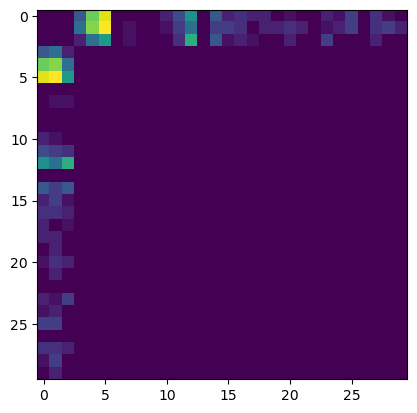

3


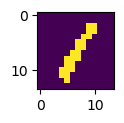

[5.00000038000001, 4.000000356000005]
5.00000038000001
[5.000000586000012, 4.000000394000008]
5.000000586000012
[3.000000378000006, 4.000000404000005]
4.000000404000005
[4.000000399000009, 5.000000345000008]
5.000000345000008
[7.000000369000007, 12.00000028100001]
12.00000028100001
[4.1600000000000034e-07, 3.0000002690000036]
3.0000002690000036
[2.000000385000006, 1.0000003900000027]
2.000000385000006
[11.000000385000012, 14.000000372000017]
14.000000372000017
[13.000000380000014, 15.000000382000016]
15.000000382000016
[3.5700000000000025e-07, 3.770000000000002e-07]
3.770000000000002e-07
[12.000000394000013, 12.000000382000014]
12.000000394000013
[2.0000004000000056, 2.0000003730000055]
2.0000004000000056
[3.9500000000000024e-07, 3.7800000000000023e-07]
3.9500000000000024e-07
[3.940000000000003e-07, 3.580000000000002e-07]
3.940000000000003e-07
[4.000000000000003e-07, 2.000000381000005]
2.000000381000005
[3.7400000000000025e-07, 1.000000416000001]
1.000000416000001
[1.0000003570000005, 

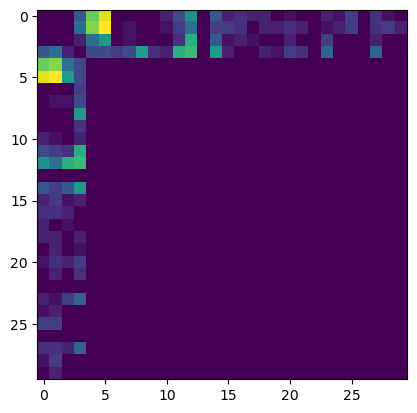

4


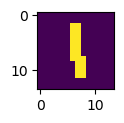

[4.080000000000003e-07, 3.020000000000001e-07]
4.080000000000003e-07
[4.000000394000003, 10.00000034400001]
10.00000034400001
[5.000000387000005, 14.00000024600001]
14.00000024600001
[9.000000393000011, 17.000000330000017]
17.000000330000017
[7.000000415000013, 12.000000350000013]
12.000000350000013
[2.0000003820000027, 4.000000293000004]
4.000000293000004
[4.000000393000007, 9.000000371000016]
9.000000371000016
[17.000000379000017, 20.00000028800002]
20.00000028800002
[6.000000398000009, 8.00000036300001]
8.00000036300001
[8.000000415000011, 14.000000376000017]
14.000000376000017
[8.000000396000013, 10.000000393000011]
10.000000393000011
[8.000000377000013, 8.000000360000012]
8.000000377000013
[8.00000038400001, 9.000000367000014]
9.000000367000014
[3.750000000000002e-07, 3.0000003260000034]
3.0000003260000034
[4.070000000000003e-07, 4.000000389000004]
4.000000389000004
[4.190000000000003e-07, 3.0000003650000036]
3.0000003650000036
[5.000000392000006, 9.000000344000012]
9.000000344000

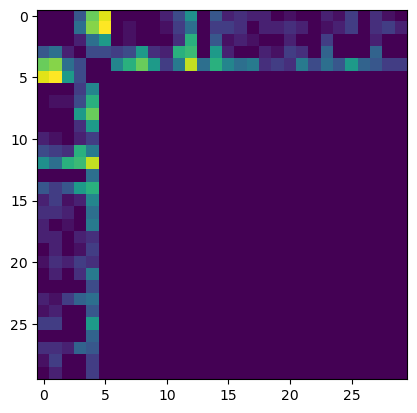

5


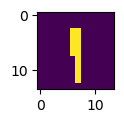

[7.000000399000006, 13.000000377000017]
13.000000377000017
[8.00000038000001, 15.000000331000011]
15.000000331000011
[11.00000038400001, 21.000000481000026]
21.000000481000026
[8.00000034400001, 12.000000369000013]
12.000000369000013
[3.000000371000002, 5.000000364000005]
5.000000364000005
[9.00000032400001, 13.000000374000013]
13.000000374000013
[15.000000395000017, 19.000000248000013]
19.000000248000013
[6.000000380000008, 9.999999827691845]
9.999999827691845
[12.000000430000014, 18.000000340000017]
18.000000340000017
[8.000000404000012, 11.000000355000008]
11.000000355000008
[7.000000383000012, 9.000000395000011]
9.000000395000011
[8.000000373000013, 10.000000340000014]
10.000000340000014
[3.0000003710000045, 8.000000358000012]
8.000000358000012
[3.8400000000000026e-07, 6.000000390000007]
6.000000390000007
[2.000000369000004, 8.000000361000005]
8.000000361000005
[5.000000381000006, 7.000000343000008]
7.000000343000008
[3.000000359000003, 3.0000004010000048]
3.0000004010000048
[4.000

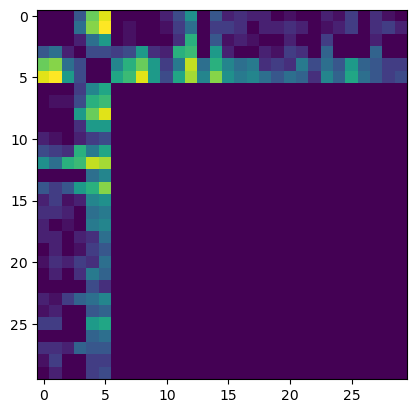

6


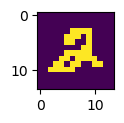

[4.0200000000000034e-07, 3.980000000000003e-07]
4.0200000000000034e-07
[4.010000000000003e-07, 4.160000000000003e-07]
4.160000000000003e-07
[3.5700000000000025e-07, 4.110000000000003e-07]
4.110000000000003e-07
[5.530000000000001e-07, 2.43e-07]
5.530000000000001e-07
[2.0000003360000047, 2.0000003890000073]
2.0000003890000073
[15.00000032500002, 11.000000386000018]
15.00000032500002
[3.7800000000000023e-07, 1.0000003900000007]
1.0000003900000007
[6.000000369000011, 4.000000412000013]
6.000000369000011
[3.460000000000002e-07, 3.4500000000000014e-07]
3.460000000000002e-07
[5.000000386000008, 6.000000395000011]
6.000000395000011
[2.000000402000005, 2.0000003830000046]
2.000000402000005
[2.65e-07, 4.010000000000003e-07]
4.010000000000003e-07
[1.000000413000001, 1.000000397000002]
1.000000413000001
[1.000000412000001, 1.0000003950000012]
1.000000412000001
[1.0000003710000012, 1.0000003920000002]
1.0000003920000002
[1.000000345000001, 2.0000003510000033]
2.0000003510000033
[1.0000002780000021,

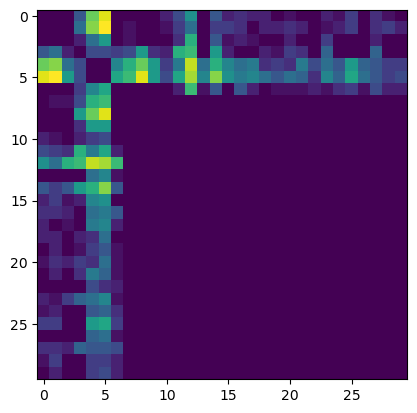

7


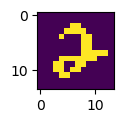

[1.0000004110000025, 3.220000000000001e-07]
1.0000004110000025
[2.000000250000002, 3.650000000000002e-07]
2.000000250000002
[1.0000003800000021, 1.0000003940000015]
1.0000003940000015
[2.0000003710000054, 1.0000004040000043]
2.0000003710000054
[9.000000341000014, 8.000000429000014]
9.000000341000014
[4.000000379000008, 1.000000384000003]
4.000000379000008
[4.0000004600000105, 1.0000003730000029]
4.0000004600000105
[2.0000003610000046, 2.000000357000004]
2.0000003610000046
[8.00000029000001, 8.000000388000013]
8.000000388000013
[4.0000003940000095, 4.000000415000006]
4.000000415000006
[1.0000003880000026, 3.890000000000002e-07]
1.0000003880000026
[1.0000003640000013, 1.000000401000002]
1.000000401000002
[1.0000003160000026, 1.0000004040000028]
1.0000004040000028
[1.000000406000002, 4.120000000000003e-07]
1.000000406000002
[3.870000000000002e-07, 3.7900000000000026e-07]
3.870000000000002e-07
[3.800000000000002e-07, 4.030000000000003e-07]
4.030000000000003e-07
[3.0000004250000076, 2.00000

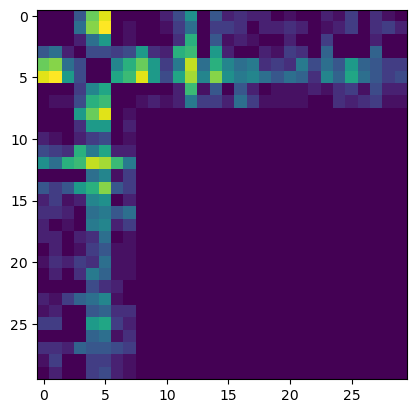

8


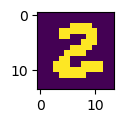

[1.000000339000001, 3.9300000000000025e-07]
1.000000339000001
[3.6200000000000025e-07, 4.0700000000000035e-07]
4.0700000000000035e-07
[1.000000349000003, 1.0000003620000022]
1.0000003620000022
[9.000000372000017, 9.000000403000017]
9.000000403000017
[1.0000003540000029, 3.3300000000000014e-07]
1.0000003540000029
[1.9999996821366517, 3.5500000000000025e-07]
1.9999996821366517
[4.010000000000003e-07, 3.690000000000002e-07]
4.010000000000003e-07
[8.00000026200001, 5.000000393000005]
8.00000026200001
[4.000000283000005, 2.000000366000002]
4.000000283000005
[2.000000370000002, 3.4600000000000016e-07]
2.000000370000002
[3.9200000000000033e-07, 4.310000000000004e-07]
4.310000000000004e-07
[2.000000372000006, 1.0000004080000031]
2.000000372000006
[2.000000412000002, 1.0000004050000013]
2.000000412000002
[4.000000369000003, 3.0000004170000043]
4.000000369000003
[3.5100000000000017e-07, 1.000000364000002]
1.000000364000002
[5.000000415000003, 4.0000003570000064]
5.000000415000003
[6.000000366000

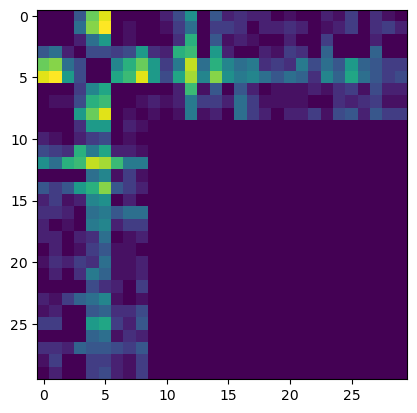

9


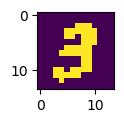

[3.050000000000001e-07, 2.72e-07]
3.050000000000001e-07
[2.000000396000006, 2.0000003860000057]
2.000000396000006
[14.000000375000017, 15.000000631000026]
15.000000631000026
[2.92e-07, 4.070000000000003e-07]
4.070000000000003e-07
[6.000000363000008, 4.0000004070000115]
6.000000363000008
[3.7900000000000026e-07, 1.0000003690000026]
1.0000003690000026
[3.690000000000002e-07, 3.9400000000000027e-07]
3.9400000000000027e-07
[4.000000000000003e-07, 4.240000000000003e-07]
4.240000000000003e-07
[3.970000000000003e-07, 2.3699999999999996e-07]
3.970000000000003e-07
[2.64e-07, 4.130000000000003e-07]
4.130000000000003e-07
[3.000000056545462, 1.0000004000000018]
3.000000056545462
[2.8900000000000006e-07, 3.200000000000001e-07]
3.200000000000001e-07
[3.450000000000002e-07, 4.120000000000003e-07]
4.120000000000003e-07
[3.0000003670000046, 3.0000003570000047]
3.0000003670000046
[3.860000000000003e-07, 3.0100000000000006e-07]
3.860000000000003e-07
[3.650000000000002e-07, 3.930000000000003e-07]
3.930000

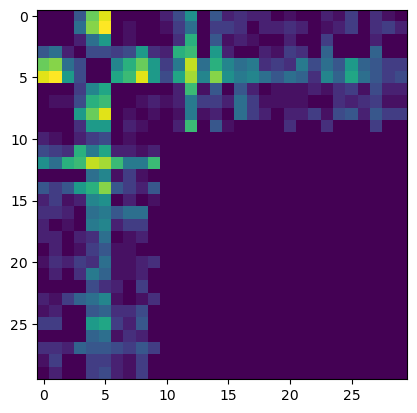

10


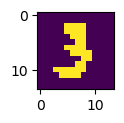

[2.000000397000006, 2.000000393000006]
2.000000397000006
[16.000000385000018, 15.000000513000025]
16.000000385000018
[2.0000003860000066, 4.000000421000009]
4.000000421000009
[4.000000331000011, 4.000000388000008]
4.000000388000008
[1.0000003880000035, 2.0000003840000056]
2.0000003840000056
[5.0000003910000155, 6.0000003840000105]
6.0000003840000105
[2.0000003920000067, 3.0000004870000083]
3.0000004870000083
[4.180000000000003e-07, 4.1000000000000026e-07]
4.180000000000003e-07
[4.080000000000003e-07, 4.070000000000003e-07]
4.080000000000003e-07
[1.0000002870000007, 2.3299999999999998e-07]
1.0000002870000007
[4.080000000000003e-07, 4.1000000000000026e-07]
4.1000000000000026e-07
[3.4300000000000025e-07, 4.0400000000000034e-07]
4.0400000000000034e-07
[1.000000373000003, 1.0000003800000026]
1.0000003800000026
[4.130000000000003e-07, 3.9200000000000023e-07]
4.130000000000003e-07
[1.0000003840000027, 3.0000004000000073]
3.0000004000000073
[4.070000000000003e-07, 3.5900000000000024e-07]
4.070

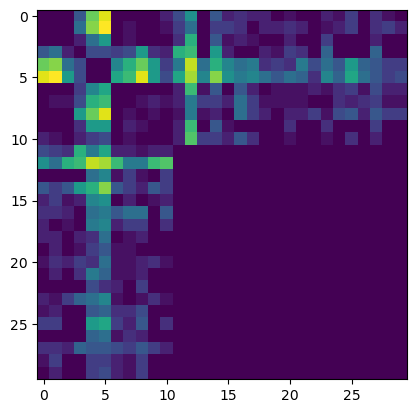

11


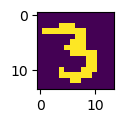

[12.000000265000008, 11.000000532000021]
12.000000265000008
[7.000000364000015, 7.000000365000012]
7.000000365000012
[1.0000004050000004, 1.0000003290000026]
1.0000004050000004
[2.000000344000006, 3.0000003350000077]
3.0000003350000077
[17.000000326000016, 16.00000043200003]
17.000000326000016
[7.000000372000016, 7.000000357000015]
7.000000372000016
[2.000000395000006, 2.0000004060000083]
2.0000004060000083
[2.000000384000007, 2.0000003940000073]
2.0000003940000073
[4.000000383000014, 2.000000402000007]
4.000000383000014
[2.0000004930000075, 2.0000003550000054]
2.0000004930000075
[6.000000255000009, 5.000000401000012]
6.000000255000009
[1.000000365000001, 5.540000000000002e-07]
1.000000365000001
[6.0000003830000095, 5.000000396000012]
6.0000003830000095
[9.00000037800001, 8.000000356000013]
9.00000037800001
[2.0000004020000066, 2.000000349000007]
2.0000004020000066
[5.000000352000008, 4.000000431000009]
5.000000352000008
[4.000000397000009, 3.000000392000006]
4.000000397000009
[5.00000

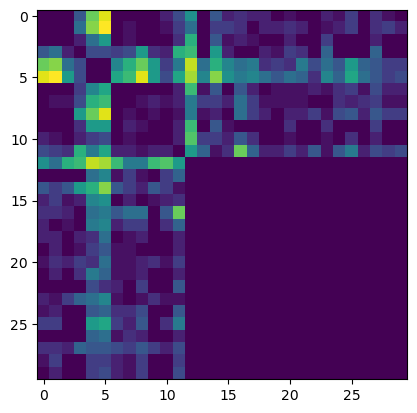

12


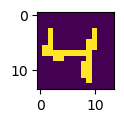

[6.00000037800001, 8.000000405000012]
8.000000405000012
[4.150000000000003e-07, 4.0800000000000027e-07]
4.150000000000003e-07
[15.000000364000016, 16.000000373000013]
16.000000373000013
[6.000000537000014, 9.000000416000011]
9.000000416000011
[7.000000406000011, 10.000000362000012]
10.000000362000012
[9.000000394000017, 11.000000331000013]
11.000000331000013
[9.000000395000013, 11.000000333000017]
11.000000333000017
[13.000000397000026, 14.000000443000022]
14.000000443000022
[10.000000293000012, 10.000000393000011]
10.000000393000011
[10.000000403000017, 12.000000388000014]
12.000000388000014
[5.000000346000011, 5.00000038900001]
5.00000038900001
[14.000000368000016, 16.000000372000017]
16.000000372000017
[15.000000371000016, 17.000000382000014]
17.000000382000014
[11.00000040000002, 14.000000354000015]
14.000000354000015
[2.0000003790000065, 4.000000371000008]
4.000000371000008
[13.000000393000013, 14.000000393000015]
14.000000393000015
[12.000000404000017, 13.000000384000012]
13.0000

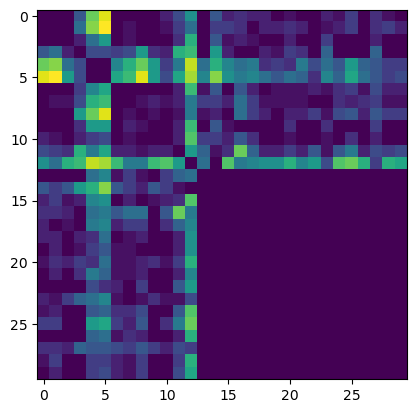

13


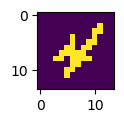

[7.00000034500001, 4.000000376000009]
7.00000034500001
[2.0000004020000026, 3.000000371000005]
3.000000371000005
[3.750000000000002e-07, 3.8100000000000025e-07]
3.8100000000000025e-07
[3.7900000000000026e-07, 4.2100000000000034e-07]
4.2100000000000034e-07
[4.060000000000003e-07, 3.7800000000000023e-07]
4.060000000000003e-07
[2.0000003700000057, 2.0000003890000055]
2.0000003890000055
[4.000000369000009, 4.000000381000013]
4.000000381000013
[3.560000000000002e-07, 3.610000000000001e-07]
3.610000000000001e-07
[3.560000000000002e-07, 3.760000000000002e-07]
3.760000000000002e-07
[5.000000552000013, 4.00000041500001]
5.000000552000013
[4.010000000000002e-07, 2.4999999999999994e-07]
4.010000000000002e-07
[3.630000000000002e-07, 3.620000000000002e-07]
3.630000000000002e-07
[2.6499999999999995e-07, 4.040000000000003e-07]
4.040000000000003e-07
[1.000000365, 2.0000004160000033]
2.0000004160000033
[3.490000000000002e-07, 1.0000003820000032]
1.0000003820000032
[3.550000000000002e-07, 3.670000000000

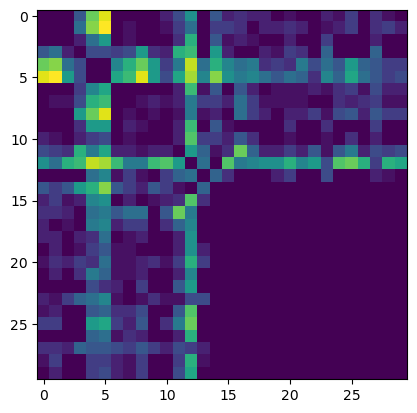

14


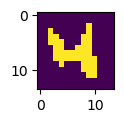

[6.000000296000003, 8.000000386000012]
8.000000386000012
[11.000000391000013, 15.000000412000018]
15.000000412000018
[6.000000387000016, 11.000000590000028]
11.000000590000028
[1.0000003770000028, 3.0000003490000093]
3.0000003490000093
[3.0000003910000093, 4.000000387000013]
4.000000387000013
[4.000000388000011, 7.000000355000013]
7.000000355000013
[4.000000366000003, 9.000000365000005]
9.000000365000005
[6.000000390000009, 9.000000399000008]
9.000000399000008
[6.04e-07, 2.000000368000005]
2.000000368000005
[8.000000347000011, 10.000000342000009]
10.000000342000009
[11.000000391000013, 16.000000359000015]
16.000000359000015
[3.0000003930000068, 4.000000350000007]
4.000000350000007
[3.5800000000000027e-07, 3.000000365000004]
3.000000365000004
[9.000000380000014, 12.00000040400001]
12.00000040400001
[6.000000390000011, 12.000000362000012]
12.000000362000012


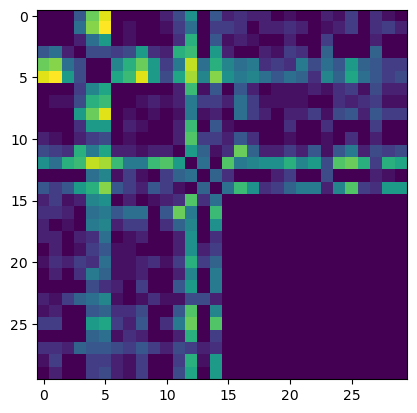

15


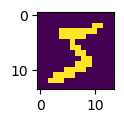

[3.0000003900000065, 4.000000383000009]
4.000000383000009
[3.6600000000000023e-07, 3.870000000000002e-07]
3.870000000000002e-07
[3.9800000000000026e-07, 4.100000000000003e-07]
4.100000000000003e-07
[3.0000002850000027, 3.000000429000008]
3.000000429000008
[2.0000003960000043, 2.0000003880000046]
2.0000003960000043
[4.040000000000003e-07, 4.010000000000004e-07]
4.040000000000003e-07
[1.000000396000003, 1.0000003480000021]
1.000000396000003
[6.000000388000007, 5.000000340000005]
6.000000388000007
[4.0700000000000035e-07, 3.4300000000000015e-07]
4.0700000000000035e-07
[1.000000260000002, 1.000000312000002]
1.000000312000002
[3.680000000000002e-07, 2.8e-07]
3.680000000000002e-07
[6.000000405000005, 6.000000405000005]
6.000000405000005
[3.730000000000003e-07, 3.9800000000000036e-07]
3.9800000000000036e-07
[1.0000003900000005, 1.0000003470000003]
1.0000003900000005


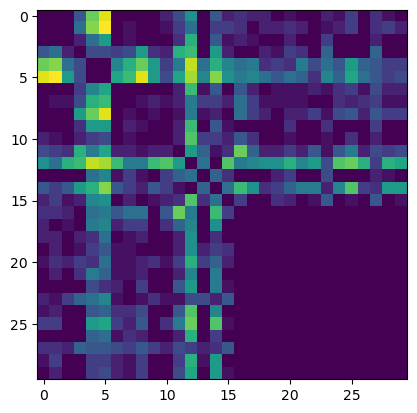

16


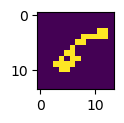

[3.930000000000003e-07, 3.720000000000002e-07]
3.930000000000003e-07
[4.000000380000012, 5.000000387000009]
5.000000387000009
[4.000000383000006, 5.000000380000011]
5.000000380000011
[9.000000392000015, 10.000000356000017]
10.000000356000017
[2.000000377000002, 1.000000377]
2.000000377000002
[3.5600000000000017e-07, 3.8400000000000026e-07]
3.8400000000000026e-07
[9.000000423000014, 8.999999441353072]
9.000000423000014
[3.760000000000003e-07, 3.8200000000000027e-07]
3.8200000000000027e-07
[3.7900000000000026e-07, 1.000000359000002]
1.000000359000002
[3.650000000000002e-07, 3.7000000000000027e-07]
3.7000000000000027e-07
[4.0000003780000055, 6.000000397000008]
6.000000397000008
[4.000000376000006, 5.000000382000007]
5.000000382000007
[2.0000003690000048, 2.0000003880000046]
2.0000003880000046


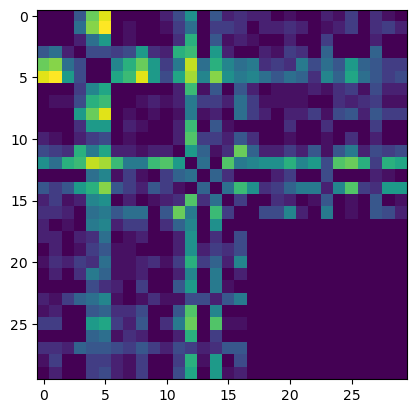

17


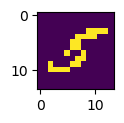

[2.0000003440000036, 1.0000003550000032]
2.0000003440000036
[4.000000400000009, 4.000000395000007]
4.000000400000009
[5.000000333000005, 5.000000383000012]
5.000000383000012
[3.0000003870000014, 2.0000003610000014]
3.0000003870000014
[3.5700000000000025e-07, 3.6800000000000017e-07]
3.6800000000000017e-07
[6.000000370000013, 5.000000391000009]
6.000000370000013
[3.740000000000002e-07, 3.7800000000000023e-07]
3.7800000000000023e-07
[3.760000000000003e-07, 3.890000000000003e-07]
3.890000000000003e-07
[3.660000000000002e-07, 3.750000000000002e-07]
3.750000000000002e-07
[6.000000326000006, 4.000000399000003]
6.000000326000006
[3.000000363000005, 3.0000003810000044]
3.0000003810000044
[3.0000003950000047, 3.0000004090000036]
3.0000004090000036


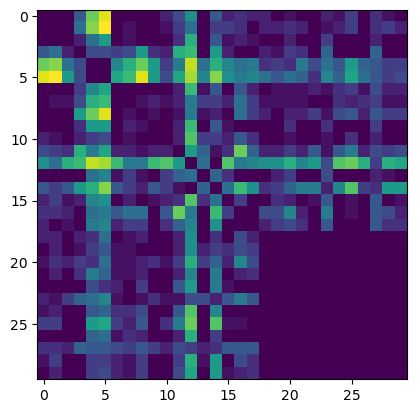

18


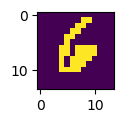

[2.2099999999999995e-07, 3.6300000000000017e-07]
3.6300000000000017e-07
[3.5900000000000024e-07, 3.910000000000003e-07]
3.910000000000003e-07
[1.0000003780000006, 1.000000378]
1.0000003780000006
[2.0000003620000033, 2.0000003870000063]
2.0000003870000063
[3.0000004060000114, 3.0000002890000066]
3.0000004060000114
[3.7700000000000027e-07, 4.130000000000003e-07]
4.130000000000003e-07
[3.660000000000002e-07, 3.5300000000000016e-07]
3.660000000000002e-07
[4.160000000000003e-07, 3.300000000000001e-07]
4.160000000000003e-07
[1.0000004050000002, 2.000000389000001]
2.000000389000001
[1.0000003810000002, 1.0000003629999998]
1.0000003810000002
[3.670000000000002e-07, 3.650000000000002e-07]
3.670000000000002e-07


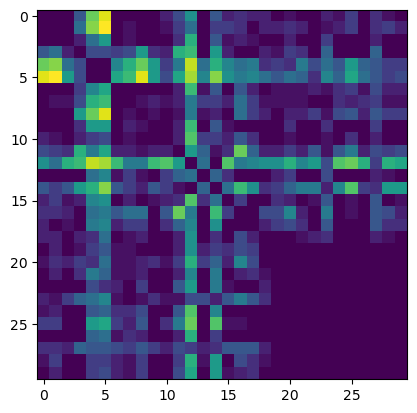

19


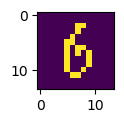

[3.8100000000000025e-07, 3.940000000000002e-07]
3.940000000000002e-07
[3.9600000000000026e-07, 2.8800000000000004e-07]
3.9600000000000026e-07
[3.460000000000001e-07, 3.870000000000003e-07]
3.870000000000003e-07
[2.0000003950000065, 1.0000004110000038]
2.0000003950000065
[1.0000005300000017, 4.1500000000000026e-07]
1.0000005300000017
[3.0000003070000036, 1.0000003900000032]
3.0000003070000036
[3.920000000000003e-07, 2.4100000000000005e-07]
3.920000000000003e-07
[1.0000003800000008, 3.780000000000003e-07]
1.0000003800000008
[1.0000003770000008, 4.0600000000000033e-07]
1.0000003770000008
[3.820000000000002e-07, 3.680000000000002e-07]
3.820000000000002e-07


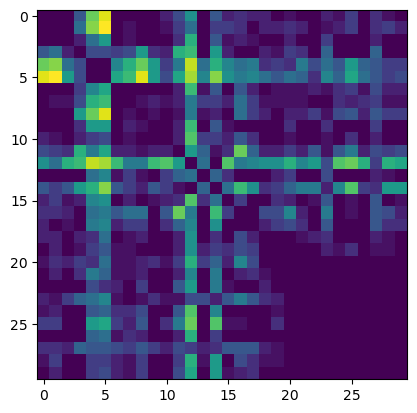

20


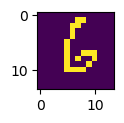

[2.000000387000004, 3.0000003720000055]
3.0000003720000055
[3.00000041400001, 3.000000352000007]
3.00000041400001
[5.000000368000015, 3.00000038900001]
5.000000368000015
[2.0000004660000053, 3.0000002660000065]
3.0000002660000065
[3.0000004080000062, 3.000000376000009]
3.0000004080000062
[1.000000377000002, 2.000000414000006]
2.000000414000006
[3.0000003880000037, 2.000000379000003]
3.0000003880000037
[3.0000003650000053, 2.0000003920000027]
3.0000003650000053
[3.6400000000000024e-07, 1.000000355]
1.000000355


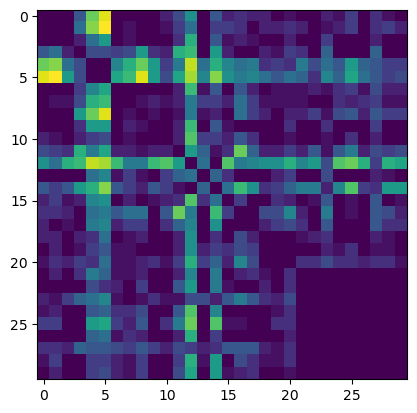

21


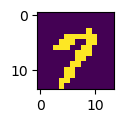

[3.520000000000002e-07, 3.740000000000002e-07]
3.740000000000002e-07
[3.0000003820000014, 3.0000004030000005]
3.0000004030000005
[3.490000000000002e-07, 4.140000000000003e-07]
4.140000000000003e-07
[3.7600000000000024e-07, 1.000000390000001]
1.000000390000001
[3.980000000000003e-07, 2.7400000000000004e-07]
3.980000000000003e-07
[3.0000003920000005, 3.000000405]
3.000000405
[3.4600000000000016e-07, 3.960000000000003e-07]
3.960000000000003e-07
[3.370000000000001e-07, 3.850000000000003e-07]
3.850000000000003e-07


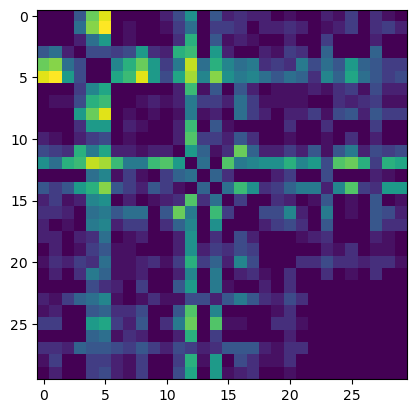

22


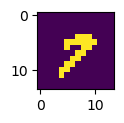

[3.0000005420000067, 1.000000391000003]
3.0000005420000067
[3.9800000000000026e-07, 3.610000000000002e-07]
3.9800000000000026e-07
[3.540000000000001e-07, 3.750000000000002e-07]
3.750000000000002e-07
[3.9600000000000026e-07, 3.7200000000000026e-07]
3.9600000000000026e-07
[3.0000003750000026, 4.000000558000002]
4.000000558000002
[3.8200000000000027e-07, 3.6700000000000026e-07]
3.8200000000000027e-07
[4.100000000000003e-07, 3.9900000000000033e-07]
4.100000000000003e-07


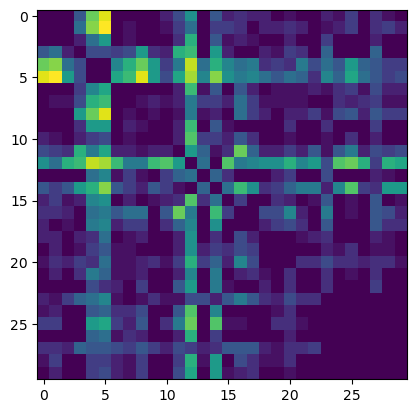

23


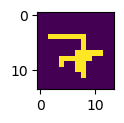

[3.000000404000005, 3.0000006230000094]
3.0000006230000094
[6.000000355000012, 5.00000039500001]
6.000000355000012
[2.000000386000005, 2.000000303000003]
2.000000386000005
[1.0000003840000025, 4.110000000000004e-07]
1.0000003840000025
[6.00000039500001, 4.0000004180000035]
6.00000039500001
[3.000000419000007, 4.000000378000005]
4.000000378000005


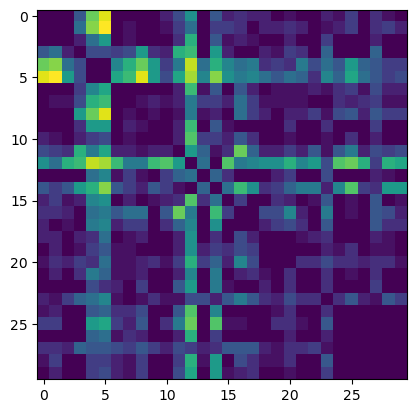

24


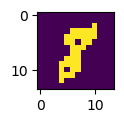

[3.9200000000000023e-07, 3.6800000000000017e-07]
3.9200000000000023e-07
[3.6300000000000017e-07, 3.760000000000003e-07]
3.760000000000003e-07
[2.000000386000001, 2.0000003840000016]
2.000000386000001
[3.790000000000003e-07, 3.6500000000000026e-07]
3.790000000000003e-07
[3.4700000000000013e-07, 3.7600000000000024e-07]
3.7600000000000024e-07


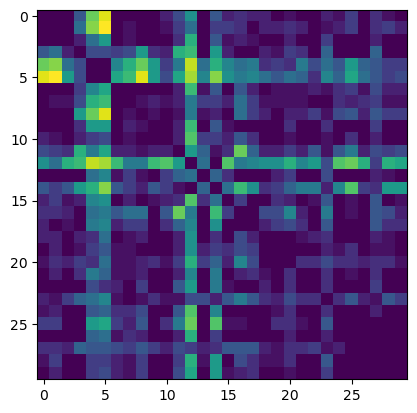

25


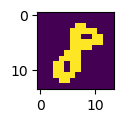

[3.690000000000002e-07, 3.560000000000002e-07]
3.690000000000002e-07
[4.000000360000002, 5.000000380000005]
5.000000380000005
[3.9600000000000026e-07, 3.6800000000000017e-07]
3.9600000000000026e-07
[3.8400000000000026e-07, 3.970000000000003e-07]
3.970000000000003e-07


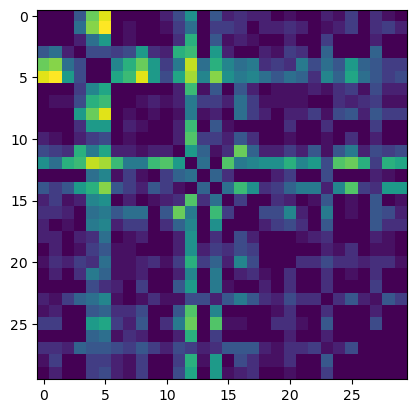

26


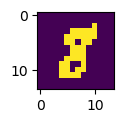

[1.000000406000001, 1.0000003740000005]
1.000000406000001
[3.700000000000002e-07, 3.960000000000002e-07]
3.960000000000002e-07
[3.860000000000002e-07, 3.870000000000003e-07]
3.870000000000003e-07


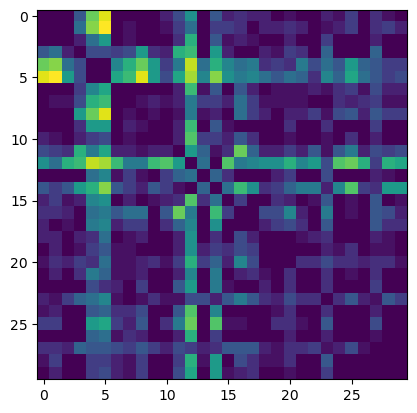

27


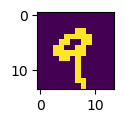

[3.000000536000001, 3.0000003890000015]
3.000000536000001
[1.000000382, 2.000000356000001]
2.000000356000001


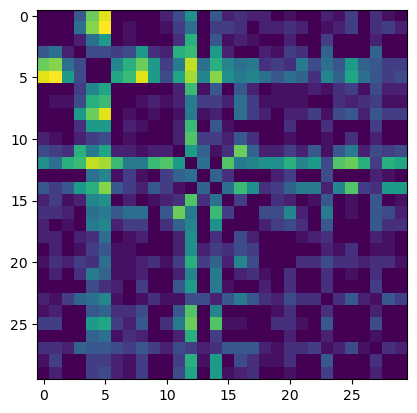

28


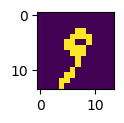

[3.5900000000000024e-07, 3.850000000000003e-07]
3.850000000000003e-07


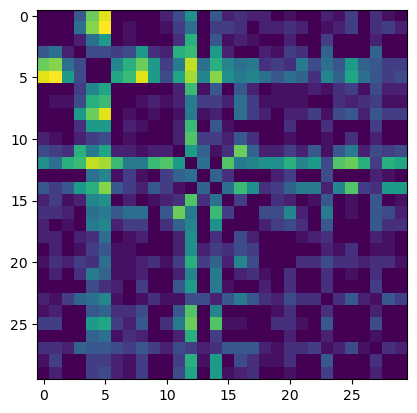

29


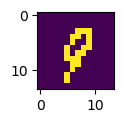

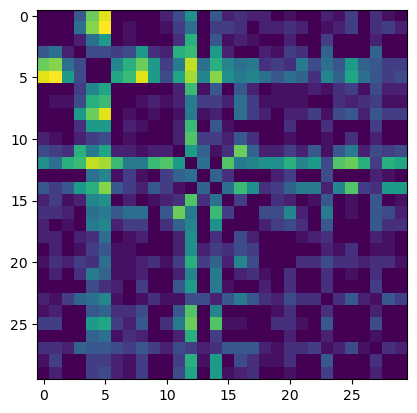

In [20]:
# TODO: TEST WITH BINARY IMAGES SO COLOR INTENSITY ISN'T A FACTOR

# new window=2
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

thresh = torch.Tensor([0.3])  # threshold
for i in range(len(dataset[1])):
    print(i)
    im1 = (dataset[0][i, 0] > thresh).float() * 1
    plt.figure(figsize=[1, 1])
    plt.imshow(im1)
    plt.show()
    
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = get_similarity_score(im1, im2, image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()

0
[3.600000000000002e-07, 3.600000000000002e-07]
3.600000000000002e-07
[3.6700000000000026e-07, 3.820000000000002e-07]
3.820000000000002e-07
[7.000000294000006, 3.8600000000000025e-07]
7.000000294000006
[11.000000354000012, 10.000000392000013]
11.000000354000012
[15.000000353000013, 11.00000038900001]
15.000000353000013
[4.0300000000000026e-07, 2.57e-07]
4.0300000000000026e-07
[3.7100000000000024e-07, 1.0000004100000015]
1.0000004100000015
[4.220000000000003e-07, 4.080000000000003e-07]
4.220000000000003e-07
[4.2300000000000033e-07, 4.160000000000004e-07]
4.2300000000000033e-07
[2.0000003710000036, 3.930000000000003e-07]
2.0000003710000036
[3.000000378000004, 2.000000401000008]
3.000000378000004
[12.000000364000012, 10.000000400000008]
12.000000364000012
[3.8800000000000025e-07, 3.7000000000000027e-07]
3.8800000000000025e-07
[10.000000285000011, 4.000000367000006]
10.000000285000011
[2.000000391000004, 1.0000003780000017]
2.000000391000004
[3.000000027199769, 1.0000003710000018]
3.00000

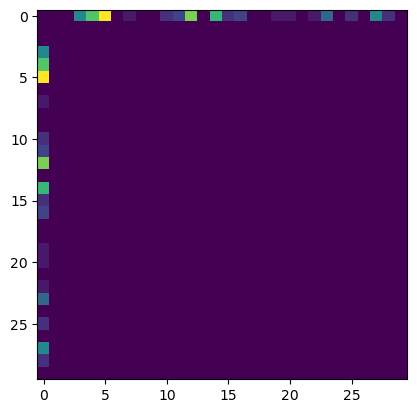

1
[3.6900000000000025e-07, 3.760000000000003e-07]
3.760000000000003e-07
[6.000000273000004, 3.7800000000000023e-07]
6.000000273000004
[10.000000356000012, 9.000000429000014]
10.000000356000012
[14.000000378000014, 11.00000038300001]
14.000000378000014
[4.0900000000000034e-07, 4.2300000000000033e-07]
4.2300000000000033e-07
[3.7600000000000024e-07, 2.000000276000002]
2.000000276000002
[3.6100000000000023e-07, 2.5500000000000005e-07]
3.6100000000000023e-07
[3.7300000000000023e-07, 4.260000000000003e-07]
4.260000000000003e-07
[2.000000373000004, 1.0000003540000013]
2.000000373000004
[3.000000397000006, 4.000000356000008]
4.000000356000008
[12.999999847224505, 9.000000393000011]
12.999999847224505
[3.8200000000000027e-07, 3.6400000000000024e-07]
3.8200000000000027e-07
[10.000000278000005, 3.000000384000005]
10.000000278000005
[2.0000003740000034, 1.0000003890000022]
2.0000003740000034
[3.000000326000001, 2.000000376000004]
3.000000326000001
[3.6200000000000025e-07, 3.830000000000003e-07]
3.

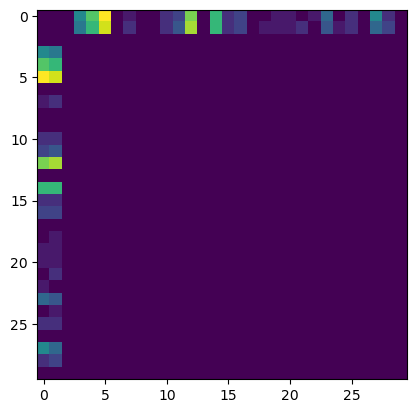

2
[3.000000379000004, 3.870000000000003e-07]
3.000000379000004
[10.000000348000011, 7.000000388000014]
10.000000348000011
[12.000000332000011, 8.000000390000011]
12.000000332000011
[3.8600000000000025e-07, 3.890000000000002e-07]
3.890000000000002e-07
[3.150000000000001e-07, 1.0000004320000018]
1.0000004320000018
[2.2999999999999997e-07, 4.180000000000003e-07]
4.180000000000003e-07
[2.5200000000000003e-07, 4.2100000000000034e-07]
4.2100000000000034e-07
[3.870000000000003e-07, 2.2599999999999993e-07]
3.870000000000003e-07
[1.0000003990000028, 2.0000004140000063]
2.0000004140000063
[11.000000387000018, 11.000000393000013]
11.000000393000013
[3.6400000000000024e-07, 2.7700000000000006e-07]
3.6400000000000024e-07
[7.000000286000009, 6.000000410000008]
7.000000286000009
[2.45e-07, 3.9000000000000024e-07]
3.9000000000000024e-07
[1.0000003250000018, 1.0000003710000032]
1.0000003710000032
[2.53e-07, 3.500000000000002e-07]
3.500000000000002e-07
[2.6799999999999996e-07, 3.820000000000002e-07]
3.8

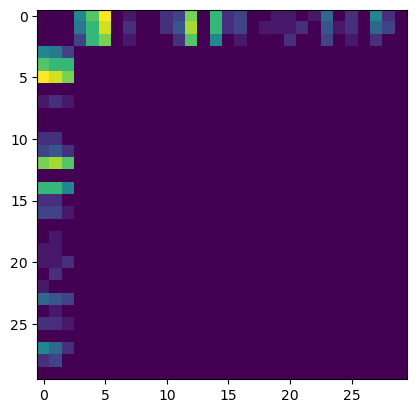

3
[3.0000003570000042, 2.0000003400000037]
3.0000003570000042
[2.0000003650000036, 2.000000363000004]
2.0000003650000036
[1.0000003960000012, 3.000000360000004]
3.000000360000004
[4.0000003910000075, 4.000000396000008]
4.000000396000008
[6.000000418000007, 10.00000034600001]
10.00000034600001
[1.0000003960000032, 4.000000388000008]
4.000000388000008
[3.810000000000002e-07, 3.4000000000000013e-07]
3.810000000000002e-07
[9.000000405000018, 10.000000348000011]
10.000000348000011
[11.000000534000016, 10.000000404000016]
11.000000534000016
[3.760000000000003e-07, 1.0000003560000017]
1.0000003560000017
[14.00000040800002, 12.000000389000014]
14.00000040800002
[4.000000408000013, 4.000000386000008]
4.000000408000013
[4.110000000000003e-07, 3.8500000000000023e-07]
4.110000000000003e-07
[3.520000000000002e-07, 3.860000000000003e-07]
3.860000000000003e-07
[3.9600000000000026e-07, 3.000000365000008]
3.000000365000008
[3.850000000000003e-07, 2.0000003920000027]
2.0000003920000027
[3.62000000000000

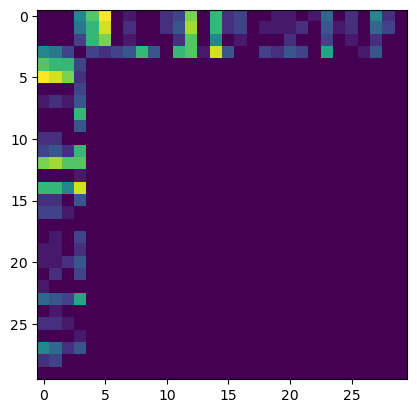

4
[4.060000000000003e-07, 3.6100000000000023e-07]
4.060000000000003e-07
[5.000000397000006, 11.000000312000008]
11.000000312000008
[4.000000402000007, 6.000000346000006]
6.000000346000006
[10.000000396000013, 13.00000034500001]
13.00000034500001
[6.0000004280000105, 11.000000312000012]
11.000000312000012
[2.0000004220000016, 4.000000343000004]
4.000000343000004
[4.000000403000004, 8.000000249000006]
8.000000249000006
[12.000000388000016, 13.000000405000016]
13.000000405000016
[7.000000370000013, 10.000000353000011]
10.000000353000011
[9.000000390000015, 15.000000355000019]
15.000000355000019
[3.000000360000002, 6.000000365000006]
6.000000365000006
[5.00000037100001, 6.000000402000037]
6.000000402000037
[4.0000003850000025, 5.000000362000009]
5.000000362000009
[4.000000394000006, 7.000000349000008]
7.000000349000008
[4.1300000000000027e-07, 3.0000003760000036]
3.0000003760000036
[4.1200000000000035e-07, 4.000000403000005]
4.000000403000005
[4.000000395000009, 6.000000355000008]
6.000000

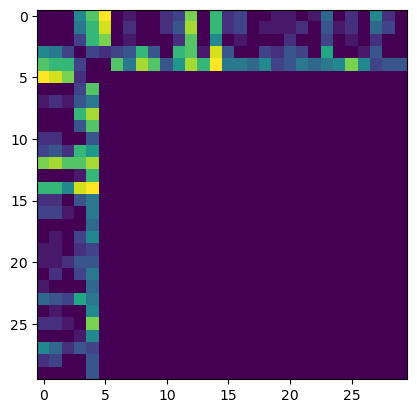

5
[6.000000402000007, 11.00000035400001]
11.00000035400001
[4.000000365000002, 6.000000360000008]
6.000000360000008
[12.000000395000011, 19.00000024900001]
19.00000024900001
[6.0000004270000105, 11.00000038500001]
11.00000038500001
[2.0000003790000016, 4.000000346000005]
4.000000346000005
[8.000000405000012, 12.000000368000014]
12.000000368000014
[10.000000379000017, 12.000000097212506]
12.000000097212506
[7.00000036600001, 10.000000255000012]
10.000000255000012
[12.00000041800002, 18.000000341000014]
18.000000341000014
[3.000000380000005, 6.0000003730000095]
6.0000003730000095
[4.000000392000008, 5.000000566000014]
5.000000566000014
[4.000000388000009, 5.0000003500000085]
5.0000003500000085
[5.000000378000007, 9.00000035900001]
9.00000035900001
[4.1800000000000033e-07, 5.000000311000005]
5.000000311000005
[2.0000003880000023, 8.000000279000005]
8.000000279000005
[4.000000389000007, 4.000000380000008]
4.000000389000007
[1.0000004010000014, 1.000000387000001]
1.0000004010000014
[4.00000

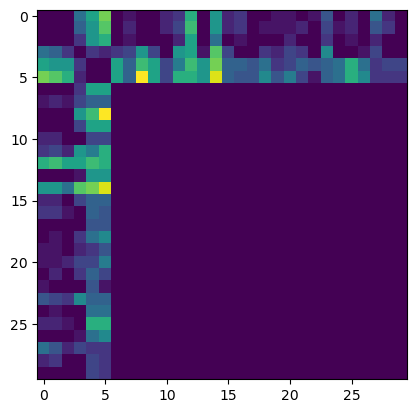

6
[3.5300000000000016e-07, 3.150000000000001e-07]
3.5300000000000016e-07
[2.2899999999999995e-07, 2.3199999999999996e-07]
2.3199999999999996e-07
[3.9800000000000026e-07, 3.930000000000003e-07]
3.9800000000000026e-07
[1.0000003820000016, 1.0000004150000013]
1.0000004150000013
[1.0000004050000038, 1.000000392000003]
1.0000004050000038
[12.00000029800001, 8.000000390000016]
12.00000029800001
[1.000000386000001, 1.0000004280000017]
1.0000004280000017
[7.000000273000009, 3.0000003920000085]
7.000000273000009
[4.130000000000001e-07, 4.0000000000000025e-07]
4.130000000000001e-07
[2.000000412000003, 3.000000411000007]
3.000000411000007
[1.0000003870000007, 1.0000003710000005]
1.0000003870000007
[2.8600000000000005e-07, 3.8300000000000024e-07]
3.8300000000000024e-07
[1.0000003500000008, 4.100000000000003e-07]
1.0000003500000008
[4.050000000000003e-07, 3.880000000000003e-07]
4.050000000000003e-07
[1.0000004010000016, 1.0000004030000023]
1.0000004030000023
[1.0000003100000008, 1.0000003650000011]

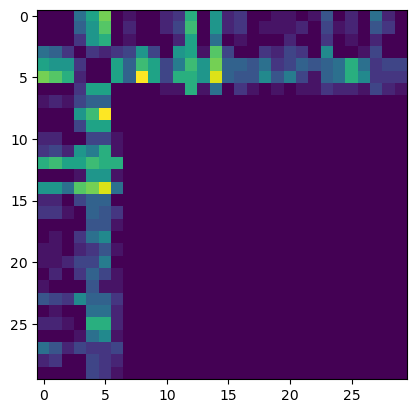

7
[3.280000000000001e-07, 3.210000000000001e-07]
3.280000000000001e-07
[1.0000002900000011, 4.110000000000003e-07]
1.0000002900000011
[2.0000003890000038, 2.0000003910000035]
2.0000003910000035
[2.000000368000003, 2.53e-07]
2.000000368000003
[5.000000346000008, 3.000000380000005]
5.000000346000008
[3.000000420000007, 1.0000004110000036]
3.000000420000007
[5.0000003450000055, 2.000000399000003]
5.0000003450000055
[1.0000003880000012, 1.000000386000001]
1.0000003880000012
[2.0000003780000037, 3.0000003740000047]
3.0000003740000047
[2.0000003940000037, 2.0000004100000046]
2.0000004100000046
[4.040000000000003e-07, 4.110000000000004e-07]
4.110000000000004e-07
[2.0000004160000033, 1.0000004110000023]
2.0000004160000033
[4.010000000000003e-07, 3.870000000000003e-07]
4.010000000000003e-07
[1.0000003840000016, 4.1000000000000026e-07]
1.0000003840000016
[1.0000003680000022, 1.0000004140000016]
1.0000004140000016
[1.0000003870000025, 4.070000000000003e-07]
1.0000003870000025
[1.000000404000002, 

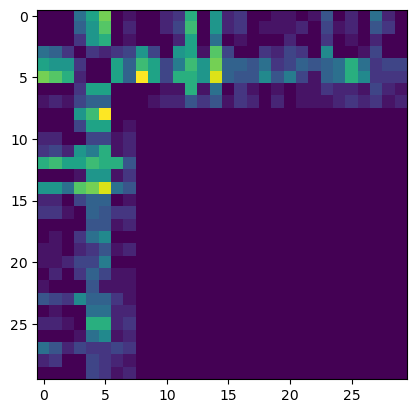

8
[3.680000000000002e-07, 3.5100000000000017e-07]
3.680000000000002e-07
[1.0000005820000026, 1.000000416000002]
1.0000005820000026
[3.3900000000000016e-07, 3.4100000000000016e-07]
3.4100000000000016e-07
[15.000000378000014, 12.000000392000015]
15.000000378000014
[1.0000003950000014, 1.0000003440000014]
1.0000003950000014
[5.000000365000007, 3.0000003540000026]
5.000000365000007
[3.800000000000003e-07, 4.1400000000000035e-07]
4.1400000000000035e-07
[7.00000025300001, 5.000000398000011]
7.00000025300001
[3.9999994084087014, 3.0000004030000054]
3.9999994084087014
[3.200000000000001e-07, 3.9400000000000027e-07]
3.9400000000000027e-07
[3.8000000000000033e-07, 4.210000000000003e-07]
4.210000000000003e-07
[2.000000365000004, 1.0000004070000033]
2.000000365000004
[2.000000408000002, 1.0000004130000013]
2.000000408000002
[5.999999337313739, 3.0000004240000058]
5.999999337313739
[7.000000253000004, 2.000000404000002]
7.000000253000004
[3.000000386000003, 3.0000002980000016]
3.000000386000003
[6.

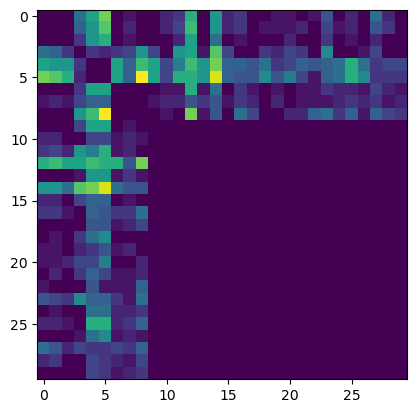

9
[3.810000000000003e-07, 3.8900000000000027e-07]
3.8900000000000027e-07
[1.000000328000002, 1.000000402000003]
1.000000402000003
[10.00000049300002, 11.000000412000015]
11.000000412000015
[3.180000000000001e-07, 3.8400000000000026e-07]
3.8400000000000026e-07
[9.000000452000018, 7.99999952450728]
9.000000452000018
[3.800000000000003e-07, 1.0000005650000037]
1.0000005650000037
[1.0000003940000008, 3.990000000000002e-07]
1.0000003940000008
[2.3799999999999993e-07, 3.930000000000003e-07]
3.930000000000003e-07
[4.0900000000000023e-07, 2.399999999999999e-07]
4.0900000000000023e-07
[1.0000003100000008, 4.110000000000003e-07]
1.0000003100000008
[1.9999995039024767, 2.0000003870000076]
2.0000003870000076
[2.3599999999999994e-07, 2.3399999999999995e-07]
2.3599999999999994e-07
[3.4500000000000014e-07, 3.5100000000000017e-07]
3.5100000000000017e-07
[4.000000387000004, 3.0000003950000034]
4.000000387000004
[3.9700000000000034e-07, 2.1699999999999994e-07]
3.9700000000000034e-07
[3.780000000000003e-

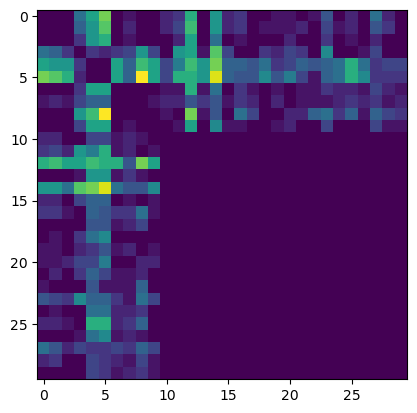

10
[2.000000391000003, 3.0000004110000087]
3.0000004110000087
[14.000000396000019, 15.000000369000016]
15.000000369000016
[3.000000387000006, 4.000000370000009]
4.000000370000009
[7.000000375000012, 6.000000380000009]
7.000000375000012
[3.3200000000000017e-07, 1.000000376000003]
1.000000376000003
[2.000000347000006, 3.000000371000005]
3.000000371000005
[2.0000003530000052, 1.0000003810000035]
2.0000003530000052
[3.590000000000002e-07, 1.0000003850000023]
1.0000003850000023
[1.000000340000001, 2.3099999999999996e-07]
1.000000340000001
[1.0000003290000026, 1.0000003580000016]
1.0000003580000016
[3.900000000000003e-07, 3.850000000000003e-07]
3.900000000000003e-07
[1.0000003840000038, 1.0000003750000033]
1.0000003840000038
[5.000000307000006, 3.0000004130000044]
5.000000307000006
[3.630000000000002e-07, 3.8600000000000025e-07]
3.8600000000000025e-07
[1.0000003740000019, 2.0000003680000056]
2.0000003680000056
[1.0000003720000041, 1.0000003520000025]
1.0000003720000041
[3.000000380000003, 2.

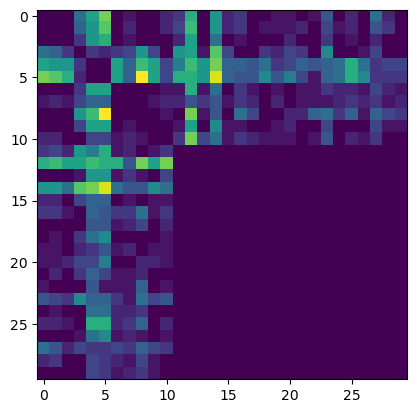

11
[10.000000368000014, 10.000000392000016]
10.000000392000016
[4.000000399000009, 4.000000350000009]
4.000000399000009
[3.000000328000002, 3.000000361000006]
3.000000361000006
[3.850000000000003e-07, 4.010000000000003e-07]
4.010000000000003e-07
[11.000000281000013, 9.000000396000013]
11.000000281000013
[5.00000038200001, 5.00000038700001]
5.00000038700001
[1.0000004090000039, 1.0000003920000033]
1.0000004090000039
[2.000000262000002, 2.000000400000007]
2.000000400000007
[2.0000004030000067, 2.000000389000003]
2.0000004030000067
[2.000000383000006, 2.000000395000003]
2.000000395000003
[4.000000367000006, 3.0000004110000034]
4.000000367000006
[4.000000398000004, 2.000000417000002]
4.000000398000004
[4.0000003670000055, 4.000000386000005]
4.000000386000005
[8.000000357000012, 7.000000366000012]
8.000000357000012
[1.0000003950000034, 1.0000003660000023]
1.0000003950000034
[4.0000003570000064, 5.00000041500001]
5.00000041500001
[4.000000489000007, 5.000000432000009]
5.000000432000009
[4.00

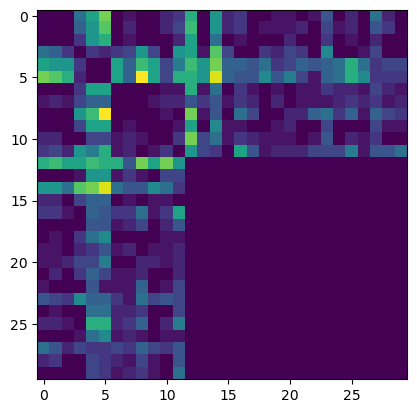

12
[5.000000397000008, 6.000000389000009]
6.000000389000009
[3.680000000000002e-07, 3.940000000000003e-07]
3.940000000000003e-07
[12.00000039900001, 12.000000390000016]
12.00000039900001
[5.000000532000009, 5.000000383000007]
5.000000532000009
[8.000000384000012, 7.0000003920000085]
8.000000384000012
[9.000000372000018, 10.000000376000013]
10.000000376000013
[7.000000410000014, 7.000000402000012]
7.000000410000014
[9.000000460000015, 11.000000372000013]
11.000000372000013
[7.000000521000013, 6.000000398000005]
7.000000521000013
[7.000000384000009, 8.00000039800001]
8.00000039800001
[3.0000005690000067, 4.000000376000007]
4.000000376000007
[8.000000389000014, 8.000000395000011]
8.000000395000011
[12.000000367000009, 10.000000389000014]
12.000000367000009
[13.000000413000018, 14.000000383000017]
14.000000383000017
[2.000000390000006, 3.0000003850000083]
3.0000003850000083
[10.000000389000013, 9.000000395000011]
10.000000389000013
[8.000000511000017, 8.00000039500001]
8.000000511000017


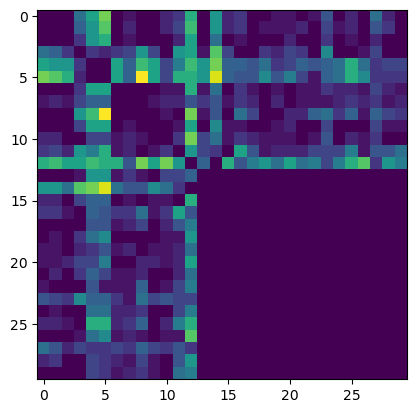

13
[8.000000336000006, 4.000000387000007]
8.000000336000006
[1.0000004070000015, 2.0000003900000034]
2.0000003900000034
[3.900000000000003e-07, 4.080000000000003e-07]
4.080000000000003e-07
[3.8500000000000023e-07, 4.160000000000002e-07]
4.160000000000002e-07
[2.000000408000008, 2.0000003780000055]
2.000000408000008
[2.0000003610000032, 2.0000004010000056]
2.0000004010000056
[3.0000003540000066, 3.0000003610000054]
3.0000003610000054
[3.8600000000000025e-07, 3.720000000000002e-07]
3.8600000000000025e-07
[3.820000000000002e-07, 3.920000000000003e-07]
3.920000000000003e-07
[4.000000384000007, 3.0000005470000066]
4.000000384000007
[3.860000000000003e-07, 3.8400000000000026e-07]
3.860000000000003e-07
[3.6400000000000024e-07, 4.070000000000003e-07]
4.070000000000003e-07
[3.7800000000000023e-07, 3.940000000000003e-07]
3.940000000000003e-07
[3.620000000000002e-07, 3.690000000000002e-07]
3.690000000000002e-07
[1.0000003590000008, 1.0000003890000022]
1.0000003890000022
[2.4299999999999994e-07, 3

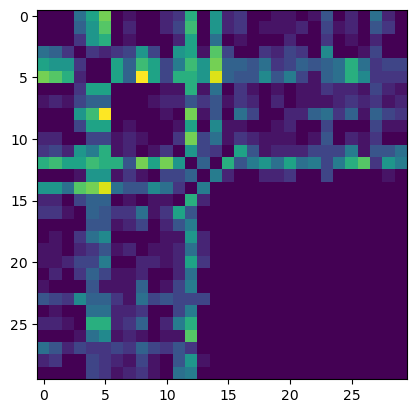

14
[7.000000353000006, 7.0000003750000115]
7.0000003750000115
[9.000000464000017, 12.000000413000016]
12.000000413000016
[6.0000004030000085, 11.000000420000022]
11.000000420000022
[1.0000004070000033, 6.000000371000011]
6.000000371000011
[3.00000040100001, 4.000000388000009]
4.000000388000009
[4.000000383000012, 5.000000394000012]
5.000000394000012
[5.000000390000006, 7.0000003930000085]
7.0000003930000085
[6.0000005330000175, 8.000000396000011]
8.000000396000011
[1.0000003010000025, 2.0000003830000037]
2.0000003830000037
[8.000000371000008, 9.000000353000011]
9.000000353000011
[12.000000353000015, 15.000000390000018]
15.000000390000018
[6.0000003950000105, 9.000000358000012]
9.000000358000012
[2.0000003910000057, 3.0000004070000057]
3.0000004070000057
[15.00000039100002, 16.00000039200002]
16.00000039200002
[8.000000376000012, 9.000000401000012]
9.000000401000012


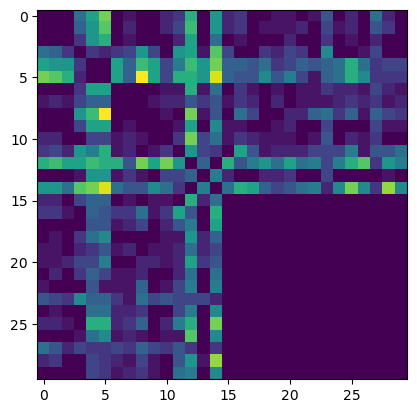

15
[2.0000003950000056, 1.000000380000002]
2.0000003950000056
[1.0000003930000034, 2.0000004220000047]
2.0000004220000047
[4.0500000000000025e-07, 4.0600000000000033e-07]
4.0600000000000033e-07
[1.0000003310000003, 4.0600000000000033e-07]
1.0000003310000003
[3.860000000000003e-07, 4.030000000000003e-07]
4.030000000000003e-07
[3.9700000000000023e-07, 2.6599999999999997e-07]
3.9700000000000023e-07
[1.0000003400000024, 3.9700000000000034e-07]
1.0000003400000024
[5.000000351000006, 4.000000397000003]
5.000000351000006
[2.5599999999999996e-07, 4.2300000000000033e-07]
4.2300000000000033e-07
[3.0000003810000098, 3.000000392000007]
3.000000392000007
[2.78e-07, 3.3900000000000016e-07]
3.3900000000000016e-07
[4.000000508000003, 3.000000406000003]
4.000000508000003
[3.4000000000000013e-07, 4.0700000000000024e-07]
4.0700000000000024e-07
[3.350000000000002e-07, 1.000000418000003]
1.000000418000003


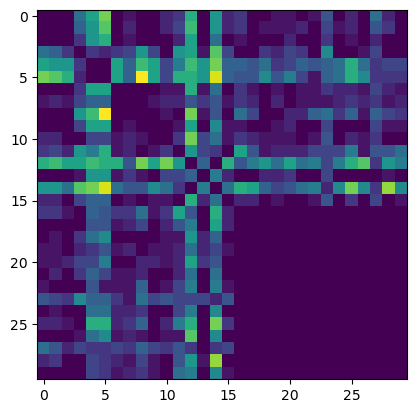

16
[3.970000000000003e-07, 3.9000000000000024e-07]
3.970000000000003e-07
[3.000000371000004, 6.00000036000001]
6.00000036000001
[3.0000003570000042, 3.0000003500000054]
3.0000003570000042
[6.00000038700001, 6.000000338000011]
6.00000038700001
[4.000000369000005, 3.0000003420000034]
4.000000369000005
[4.100000000000003e-07, 3.9400000000000027e-07]
4.100000000000003e-07
[5.000000393000008, 5.000000253000006]
5.000000393000008
[3.710000000000002e-07, 3.710000000000002e-07]
3.710000000000002e-07
[3.8600000000000025e-07, 3.6800000000000017e-07]
3.8600000000000025e-07
[3.900000000000003e-07, 1.0000003730000029]
1.0000003730000029
[2.000000385000002, 3.000000381000002]
3.000000381000002
[2.000000396000001, 2.0000003580000003]
2.000000396000001
[1.0000004010000008, 1.0000003900000003]
1.0000004010000008


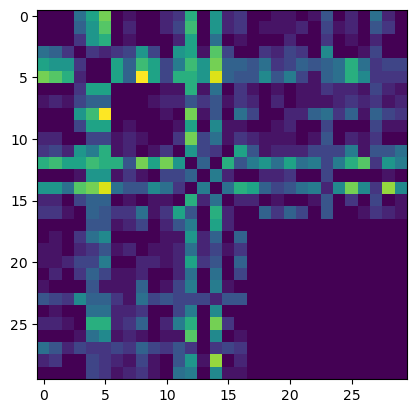

17
[1.0000004050000038, 1.000000347000002]
1.0000004050000038
[2.0000003740000034, 1.0000003950000038]
2.0000003740000034
[1.0000003470000025, 1.0000003500000032]
1.0000003500000032
[3.780000000000003e-07, 3.7900000000000026e-07]
3.7900000000000026e-07
[3.4000000000000013e-07, 3.950000000000003e-07]
3.950000000000003e-07
[6.00000040000001, 3.000000396000008]
6.00000040000001
[3.8900000000000027e-07, 3.8400000000000026e-07]
3.8900000000000027e-07
[3.800000000000003e-07, 3.640000000000002e-07]
3.800000000000003e-07
[3.9300000000000025e-07, 3.770000000000002e-07]
3.9300000000000025e-07
[4.000000372000003, 3.000000366000002]
4.000000372000003
[3.7700000000000027e-07, 3.7900000000000026e-07]
3.7900000000000026e-07
[4.0100000000000027e-07, 3.9100000000000026e-07]
4.0100000000000027e-07


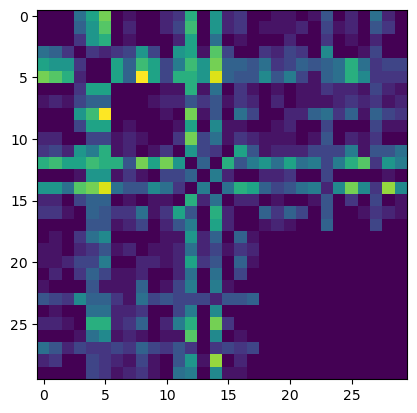

18
[3.730000000000003e-07, 2.1799999999999994e-07]
3.730000000000003e-07
[3.630000000000002e-07, 4.3400000000000037e-07]
4.3400000000000037e-07
[1.0000003850000043, 1.0000004100000035]
1.0000004100000035
[2.0000003820000067, 1.0000003800000035]
2.0000003820000067
[4.000000283000005, 1.0000003900000043]
4.000000283000005
[3.690000000000002e-07, 2.5399999999999997e-07]
3.690000000000002e-07
[1.000000333000001, 3.570000000000002e-07]
1.000000333000001
[4.1600000000000034e-07, 3.520000000000002e-07]
4.1600000000000034e-07
[3.000000351000006, 2.000000393000003]
3.000000351000006
[1.0000003890000042, 1.000000369000003]
1.0000003890000042
[3.6100000000000023e-07, 3.8300000000000024e-07]
3.8300000000000024e-07


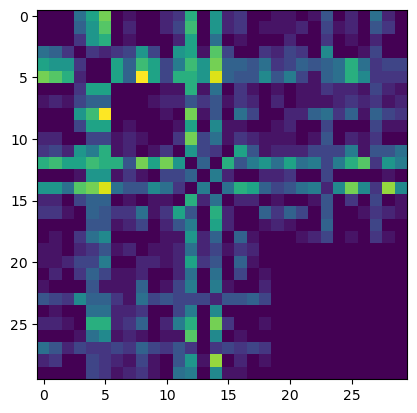

19
[3.6700000000000026e-07, 3.7000000000000016e-07]
3.7000000000000016e-07
[3.840000000000002e-07, 1.0000003860000022]
1.0000003860000022
[4.130000000000004e-07, 3.7600000000000024e-07]
4.130000000000004e-07
[4.000000369000008, 3.8500000000000023e-07]
4.000000369000008
[3.750000000000003e-07, 3.8900000000000027e-07]
3.8900000000000027e-07
[2.0000004010000048, 2.0000003600000027]
2.0000004010000048
[4.350000000000004e-07, 3.6700000000000026e-07]
4.350000000000004e-07
[1.000000389000001, 1.000000370000002]
1.000000389000001
[3.7200000000000026e-07, 3.7700000000000027e-07]
3.7700000000000027e-07
[3.8900000000000027e-07, 3.640000000000002e-07]
3.8900000000000027e-07


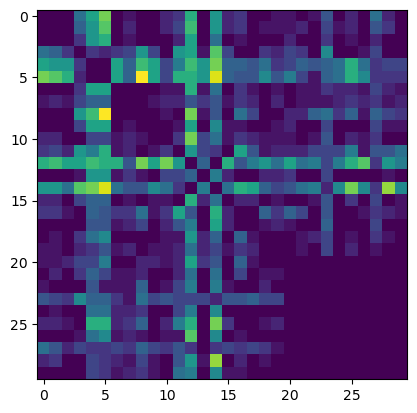

20
[3.0000003850000057, 5.0000000733083265]
5.0000000733083265
[1.0000003810000027, 1.000000368000003]
1.0000003810000027
[5.000000536000012, 1.000000356000003]
5.000000536000012
[1.0000003670000028, 3.000000373000008]
3.000000373000008
[3.000000353000006, 2.0000003630000047]
3.000000353000006
[4.1100000000000033e-07, 1.0000003960000032]
1.0000003960000032
[2.0000004070000044, 2.0000003760000067]
2.0000004070000044
[2.000000365000005, 2.0000003570000042]
2.000000365000005
[3.570000000000002e-07, 1.0000003570000007]
1.0000003570000007


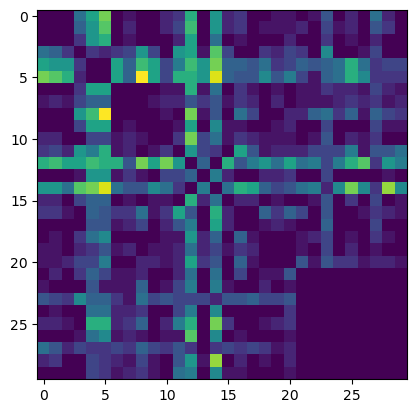

21
[3.6500000000000026e-07, 3.960000000000003e-07]
3.960000000000003e-07
[3.000000399000002, 3.0000004120000026]
3.0000004120000026
[3.4100000000000016e-07, 4.030000000000003e-07]
4.030000000000003e-07
[1.000000391000003, 2.000000357000003]
2.000000357000003
[3.2000000000000017e-07, 1.0000003910000015]
1.0000003910000015
[2.000000351000001, 1.0000003850000012]
2.000000351000001
[1.000000373000002, 1.0000003800000021]
1.0000003800000021
[3.620000000000002e-07, 3.8900000000000027e-07]
3.8900000000000027e-07


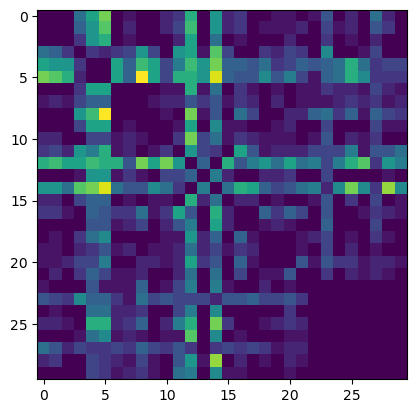

22
[1.000000381000001, 2.0000005630000035]
2.0000005630000035
[3.970000000000003e-07, 3.8900000000000027e-07]
3.970000000000003e-07
[3.750000000000002e-07, 3.8600000000000025e-07]
3.8600000000000025e-07
[3.680000000000002e-07, 3.5100000000000017e-07]
3.680000000000002e-07
[2.0000003660000014, 2.000000380000001]
2.000000380000001
[4.000000000000003e-07, 3.6400000000000024e-07]
4.000000000000003e-07
[4.2900000000000036e-07, 4.000000000000003e-07]
4.2900000000000036e-07


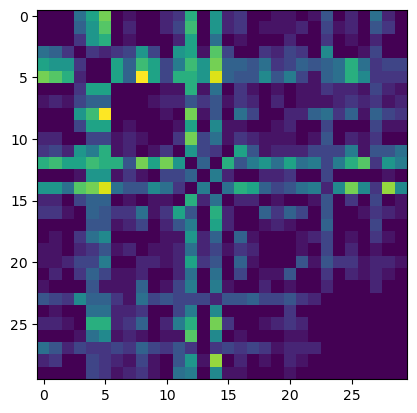

23
[3.0000004240000036, 4.000000412000006]
4.000000412000006
[7.00000039200001, 8.000000260000007]
8.000000260000007
[3.0000005770000047, 5.0000003560000055]
5.0000003560000055
[1.0000003560000013, 1.000000393000003]
1.000000393000003
[5.000000429000007, 4.000000371000005]
5.000000429000007
[3.0000004080000022, 3.0000003880000037]
3.0000004080000022


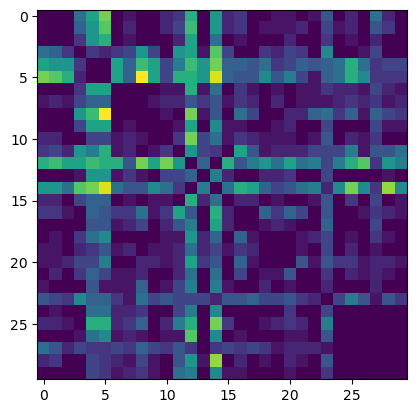

24
[3.590000000000002e-07, 3.770000000000002e-07]
3.770000000000002e-07
[2.17e-07, 3.710000000000003e-07]
3.710000000000003e-07
[2.0000003590000017, 2.000000366000001]
2.000000366000001
[3.6900000000000014e-07, 3.820000000000002e-07]
3.820000000000002e-07
[3.700000000000002e-07, 3.7800000000000023e-07]
3.7800000000000023e-07


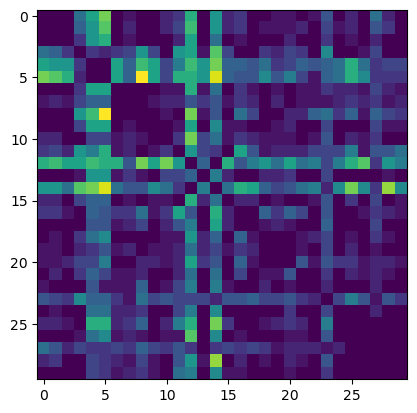

25
[3.720000000000002e-07, 3.3900000000000016e-07]
3.720000000000002e-07
[3.000000369000002, 3.000000375000002]
3.000000375000002
[1.0000003590000006, 3.7100000000000024e-07]
1.0000003590000006
[3.7400000000000025e-07, 3.9500000000000024e-07]
3.9500000000000024e-07


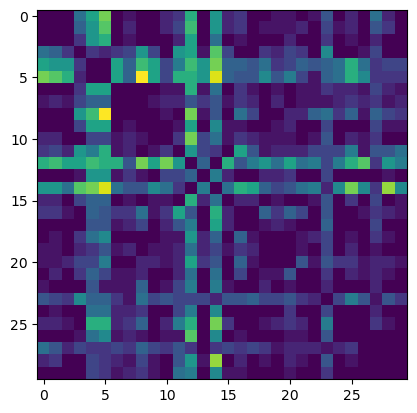

26
[3.0000003330000027, 2.0000004200000014]
3.0000003330000027
[3.650000000000002e-07, 3.7600000000000024e-07]
3.7600000000000024e-07
[3.970000000000003e-07, 3.900000000000003e-07]
3.970000000000003e-07


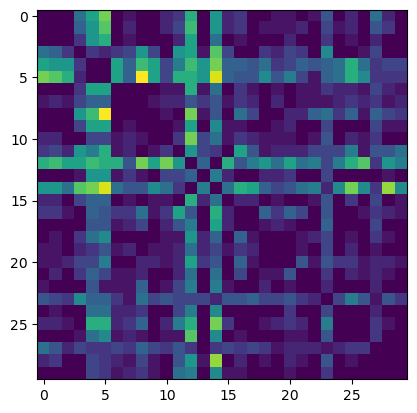

27
[2.0000003730000016, 3.000000380000002]
3.000000380000002
[3.580000000000002e-07, 1.0000003930000005]
1.0000003930000005


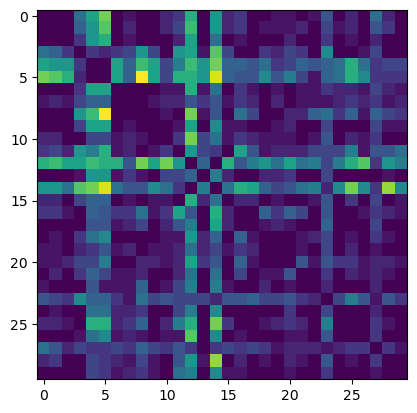

28
[3.870000000000003e-07, 1.0000003470000027]
1.0000003470000027


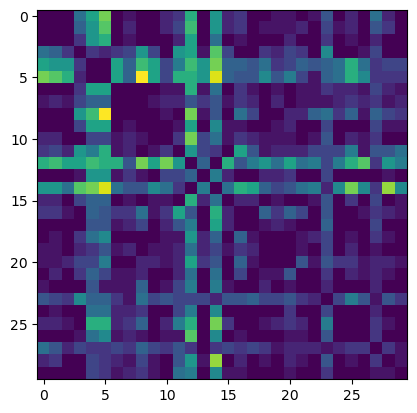

29


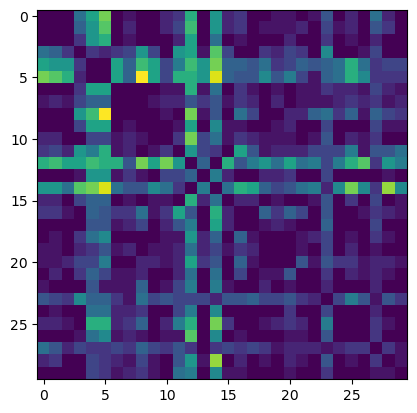

In [13]:
# TODO: TEST WITH BINARY IMAGES SO COLOR INTENSITY ISN'T A FACTOR

# new window=2
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

for i in range(len(dataset[1])):
    print(i)
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        thresh = torch.Tensor([0.5])  # threshold
        im1 = (dataset[0][i, 0] > thresh).float() * 1
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = get_similarity_score(im1, im2, image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()


0
[0.7893985889298003, 0.9417457692509648]
0.9417457692509648
[0.6898916716692624, 0.8463843349413314]
0.8463843349413314
[3.4200695506041816, 0.8239237868018343]
3.4200695506041816
[7.2761009433743435, 5.3919324965805915]
7.2761009433743435
[9.501440408358306, 8.197143809899151]
9.501440408358306
[1.036419967721643, 1.1865823874733916]
1.1865823874733916
[1.5004367363766353, 1.1436066169063746]
1.5004367363766353
[0.9301588287554285, 1.6656490701222855]
1.6656490701222855
[1.1897936804387985, 1.3687930482263129]
1.3687930482263129
[1.733562365503377, 0.6337142661223686]
1.733562365503377
[3.203232606059998, 3.095536666177378]
3.203232606059998
[7.294143066292955, 5.3133925248963925]
7.294143066292955
[1.3845764387150852, 0.9719006424265519]
1.3845764387150852
[5.4589872571008815, 3.1010469571236547]
5.4589872571008815
[1.6306482328922198, 1.5428030953819782]
1.6306482328922198
[2.9540064551605294, 1.5743342848052249]
2.9540064551605294
[2.0698915908792848, 1.3484912441487276]
2.069891

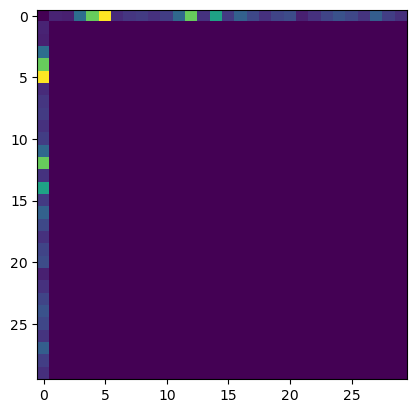

1
[1.068294104132607, 0.8223608538299626]
1.068294104132607
[4.355548041671273, 1.0080067768563514]
4.355548041671273
[8.679491968555817, 7.052890617865409]
8.679491968555817
[11.75356724506477, 10.21593546882805]
11.75356724506477
[0.8909662284934482, 1.009159281392124]
1.009159281392124
[2.009977137104483, 1.9114862274484443]
2.009977137104483
[1.0182470872395644, 1.7811651472211947]
1.7811651472211947
[1.0267111696723281, 1.3540698222501653]
1.3540698222501653
[1.8177339454441843, 0.9267995798586551]
1.8177339454441843
[2.2360036065535067, 3.5019783116040855]
3.5019783116040855
[6.418370963428012, 4.455656780159301]
6.418370963428012
[1.8018283986795836, 1.1914467813525087]
1.8018283986795836
[4.641484412374544, 1.9662796658566974]
4.641484412374544
[1.9657605402910132, 2.1119688264683996]
2.1119688264683996
[3.27559709910846, 2.6652444584996777]
3.27559709910846
[1.8214457810915523, 1.1301838626583285]
1.8214457810915523
[1.4673878357443246, 1.2403031507302718]
1.4673878357443246
[

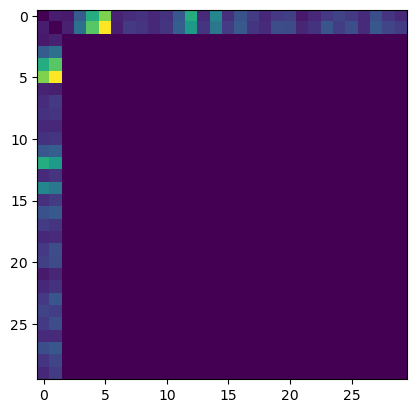

2
[1.7230414648812333, 0.5107183276594687]
1.7230414648812333
[2.91423538305085, 1.3811567757145635]
2.91423538305085
[6.068997892572966, 3.115675160181768]
6.068997892572966
[1.1682230948357024, 1.0877674697051094]
1.1682230948357024
[1.2587247497402996, 1.1803078778074558]
1.2587247497402996
[0.8127790074941432, 1.1691535286253771]
1.1691535286253771
[1.1124589672474399, 1.0148379632211393]
1.1124589672474399
[1.370024258799069, 0.8099377536994293]
1.370024258799069
[2.7525887293808933, 3.5249963176429344]
3.5249963176429344
[7.898805527021867, 5.693472008502354]
7.898805527021867
[1.0609162648623836, 0.8401444412362983]
1.0609162648623836
[5.646502675651484, 4.8233142695816245]
5.646502675651484
[0.9085143040946487, 1.37612482088465]
1.37612482088465
[2.1568312740936433, 1.4270023819376774]
2.1568312740936433
[1.8539380708740183, 1.3342448262401323]
1.8539380708740183
[0.9636219033764476, 1.130697146031988]
1.130697146031988
[2.4052040256335268, 1.901919895152485]
2.4052040256335268

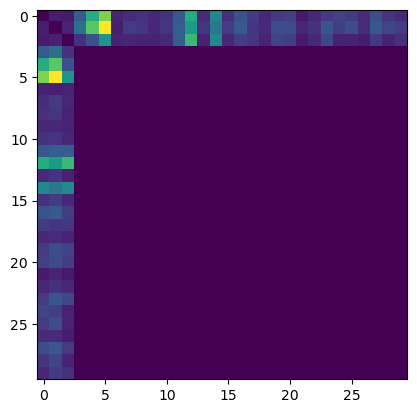

3
[2.191278800627778, 1.8869958005649548]
2.191278800627778
[1.6486700539638357, 1.5153242460984053]
1.6486700539638357
[1.4640374043768734, 2.7490584053098175]
2.7490584053098175
[1.642805015669046, 2.360702976182247]
2.360702976182247
[4.142264909879073, 6.276860115626635]
6.276860115626635
[0.8003501825260786, 2.388281682996995]
2.388281682996995
[0.7366015719362955, 0.8799897053846362]
0.8799897053846362
[6.9335122665088065, 8.054657084983816]
8.054657084983816
[6.971082764719609, 6.513225155825932]
6.971082764719609
[0.6168573519650989, 1.2181578716005903]
1.2181578716005903
[9.078215635294121, 7.547809019214842]
9.078215635294121
[1.4713689934657548, 1.4338008534676094]
1.4713689934657548
[0.4788383098845823, 0.5065718555623573]
0.5065718555623573
[0.6508048712572219, 0.8528492217176239]
0.8528492217176239
[0.7027127294091647, 2.0712872492053784]
2.0712872492053784
[1.16131139337839, 1.840809644437631]
1.840809644437631
[1.229656234873958, 2.5405385164158525]
2.5405385164158525
[

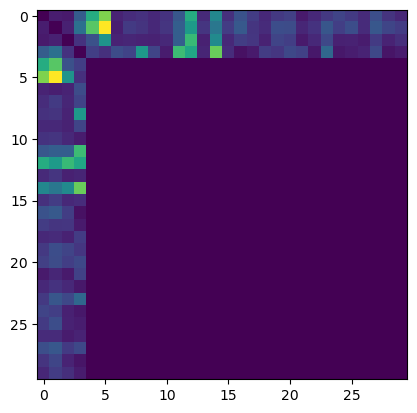

4
[0.6781826550403491, 0.532071717024894]
0.6781826550403491
[4.269796627535466, 5.405972989126437]
5.405972989126437
[3.4549946533805618, 5.356054841612054]
5.356054841612054
[3.888977698269332, 5.657312941689051]
5.657312941689051
[4.40340389534082, 6.165961593149312]
6.165961593149312
[1.0528925746045728, 1.9549935895336148]
1.9549935895336148
[3.550177257405324, 6.167952987027371]
6.167952987027371
[6.91837800662677, 8.074359275710037]
8.074359275710037
[3.061216349835663, 3.454700645985189]
3.454700645985189
[6.655080111738796, 9.12575674244107]
9.12575674244107
[2.9031434840609016, 3.268405854035732]
3.268405854035732
[3.7418842105492236, 3.737108198040252]
3.7418842105492236
[4.467659753516388, 3.9078684882237704]
4.467659753516388
[1.2369901222555058, 1.9875013424668655]
1.9875013424668655
[1.6032635589855173, 2.3782885090400234]
2.3782885090400234
[0.8085499261400053, 1.1147043303039592]
1.1147043303039592
[2.6803013822097057, 3.349905304412381]
3.349905304412381
[1.3353175368

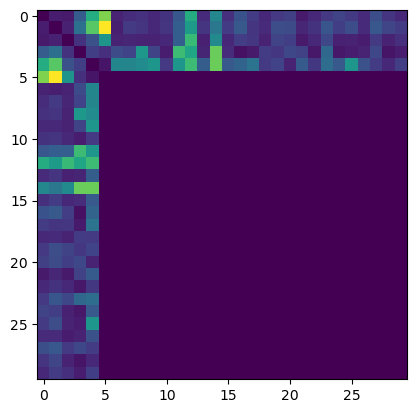

5
[4.6030310664614005, 6.130115726120927]
6.130115726120927
[3.223273256332802, 4.789592964483212]
4.789592964483212
[7.061077816278768, 10.674656176658113]
10.674656176658113
[5.634152544499594, 8.061464983266662]
8.061464983266662
[2.018952749173904, 2.5018073244648957]
2.5018073244648957
[6.111775756786991, 8.829228655679472]
8.829228655679472
[5.354307503388167, 6.450451255803554]
6.450451255803554
[3.498889312094534, 4.614065141311169]
4.614065141311169
[8.137526336012938, 9.896754350982528]
9.896754350982528
[3.059753336355123, 4.053262555060342]
4.053262555060342
[3.7748599754188152, 3.54737151086424]
3.7748599754188152
[3.939574612778503, 4.217303358511321]
4.217303358511321
[2.6601935902304743, 4.25919489788087]
4.25919489788087
[0.6697312636395291, 1.8722657115727928]
1.8722657115727928
[1.0125072053527104, 2.924394936696015]
2.924394936696015
[3.335345446832629, 3.908052005871523]
3.908052005871523
[0.729679347080998, 1.0979991247633545]
1.0979991247633545
[3.227177299818338

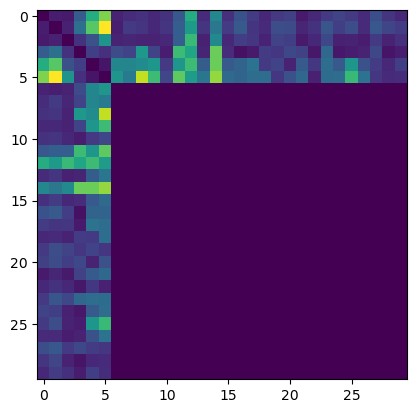

6
[1.0908567011734516, 0.9489084100036382]
1.0908567011734516
[0.666497864187946, 0.9647014304848957]
0.9647014304848957
[1.00693222853468, 1.0626492372415195]
1.0626492372415195
[1.3199359705193856, 0.9607999803598185]
1.3199359705193856
[1.7036355481937784, 1.7322043051436162]
1.7322043051436162
[6.05571046788506, 4.726801432363642]
6.05571046788506
[1.3051589487625215, 1.2724782682491032]
1.3051589487625215
[3.0831471987865062, 2.713778692386229]
3.0831471987865062
[1.0793660088900978, 1.0803367573613898]
1.0803367573613898
[3.129323657077926, 2.5791824106635546]
3.129323657077926
[2.4702443684850657, 1.671400851014436]
2.4702443684850657
[0.8266496322854782, 0.9705068486248699]
0.9705068486248699
[1.82571260161123, 1.6310441756165215]
1.82571260161123
[1.6147090332543876, 1.085299202454172]
1.6147090332543876
[1.0799570752285352, 0.9943717014529404]
1.0799570752285352
[2.0360998951738996, 1.361142240713676]
2.0360998951738996
[1.274644668046251, 0.7684768809492565]
1.27464466804625

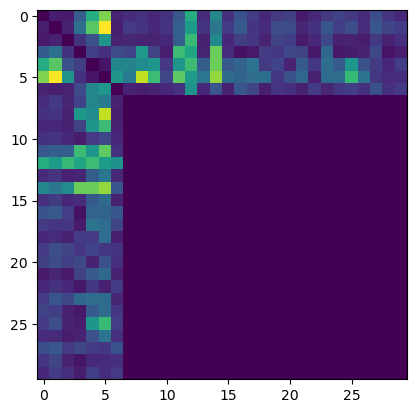

7
[1.1004491513990464, 2.337170519144214]
2.337170519144214
[0.9899820589876218, 1.1853645607783072]
1.1853645607783072
[1.5921707161364533, 1.5349426202974792]
1.5921707161364533
[1.4721620305813075, 1.642853042010109]
1.642853042010109
[3.5095621634437784, 3.1802754885498676]
3.5095621634437784
[1.8730635817393824, 1.3334183060079545]
1.8730635817393824
[2.440414609399133, 2.2919025048474206]
2.440414609399133
[1.4930712762388605, 1.9222186668118757]
1.9222186668118757
[2.6290439161991723, 2.4341506436601]
2.6290439161991723
[2.5131866041327093, 2.116450825776779]
2.5131866041327093
[1.471126764413152, 1.432283096810516]
1.471126764413152
[1.3225955676958596, 1.170849167630773]
1.3225955676958596
[1.2309211271670484, 0.9995697837656441]
1.2309211271670484
[1.4337276493713704, 1.0921974919383564]
1.4337276493713704
[1.3386210751185, 0.6639555835993644]
1.3386210751185
[1.1097513828049084, 1.0429127015504411]
1.1097513828049084
[1.2945927489541236, 1.2257673049411675]
1.294592748954123

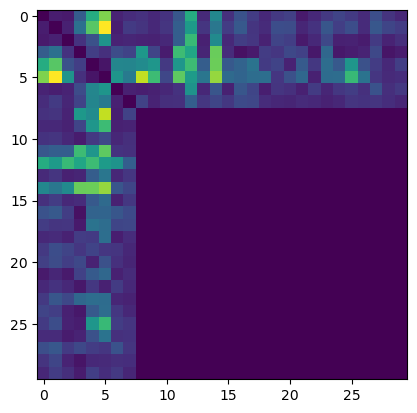

8
[1.3975185758389208, 0.7763199444887678]
1.3975185758389208
[1.4220572645133944, 0.5667497056973212]
1.4220572645133944
[1.4192082471523926, 1.0826665701777736]
1.4192082471523926
[8.582983588098314, 6.802568481742102]
8.582983588098314
[2.3705596602763084, 1.0103367466429956]
2.3705596602763084
[3.5759865303165093, 1.9132096451724252]
3.5759865303165093
[1.7304069156184723, 1.0827194654973165]
1.7304069156184723
[6.399169775580397, 4.4561893455906345]
6.399169775580397
[4.008913066491374, 2.305290493484732]
4.008913066491374
[1.750639415265933, 0.996341133661157]
1.750639415265933
[3.242552088119181, 2.4091131876502123]
3.242552088119181
[3.822603951645193, 1.9367351341474885]
3.822603951645193
[2.457569525370342, 1.1223975265608552]
2.457569525370342
[4.299954274757958, 2.501566163932488]
4.299954274757958
[3.3989834456643964, 1.1309547679784764]
3.3989834456643964
[3.9819082269605723, 2.829582252273741]
3.9819082269605723
[3.9716141023450153, 3.0323745188768347]
3.9716141023450153

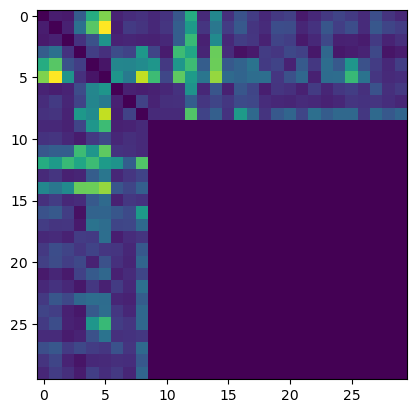

9
[1.0297149101347969, 0.7617400802222595]
1.0297149101347969
[2.102518590000536, 1.9358691466761457]
2.102518590000536
[7.980338699940442, 8.189472622929333]
8.189472622929333
[1.5854540436901132, 1.2241824143206985]
1.5854540436901132
[4.771805573313058, 4.4931222674961395]
4.771805573313058
[1.3174378271243554, 1.3681577566296879]
1.3681577566296879
[2.7984422956633104, 1.1428723615598564]
2.7984422956633104
[2.188871829195633, 0.9093697878969372]
2.188871829195633
[1.2332759746364972, 1.2546534173254134]
1.2546534173254134
[3.213916088945277, 2.665026378376479]
3.213916088945277
[3.5137093915286726, 2.5040458899758544]
3.5137093915286726
[0.8532547823484227, 0.7636862905537084]
0.8532547823484227
[1.6037517995737027, 0.6851319534732374]
1.6037517995737027
[2.752498446581021, 2.0492015540121447]
2.752498446581021
[1.0348108817119854, 0.6982125827920775]
1.0348108817119854
[1.1155252021778557, 0.7909057102662068]
1.1155252021778557
[1.2485681861564706, 0.9876782112936991]
1.248568186

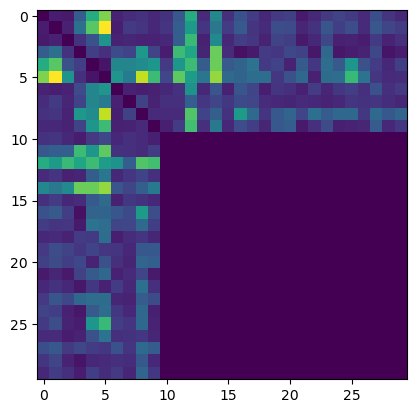

10
[2.2913931069229436, 2.745244483414721]
2.745244483414721
[8.112220490530227, 7.739759953594652]
8.112220490530227
[1.5755549666068784, 2.4375782074455707]
2.4375782074455707
[4.773616280134939, 5.091103826684823]
5.091103826684823
[0.7948140101642471, 1.21393638730181]
1.21393638730181
[2.5701068981560917, 2.703796955470378]
2.703796955470378
[1.9382817837136543, 2.0240852788560924]
2.0240852788560924
[0.9067468370193901, 1.2759720784265258]
1.2759720784265258
[2.340393348412002, 1.6819708398988906]
2.340393348412002
[1.5809595383448638, 1.4917304600650565]
1.5809595383448638
[0.5677281476380786, 1.0062489069983687]
1.0062489069983687
[1.0183124490844877, 1.0591237199930807]
1.0591237199930807
[1.9069360054476392, 1.7417389955749942]
1.9069360054476392
[1.013957421740305, 1.2094880239153927]
1.2094880239153927
[0.9789122785344484, 1.7893083638238505]
1.7893083638238505
[1.0809450998538297, 1.4236460254450627]
1.4236460254450627
[1.6580386366005033, 1.5876992633528382]
1.65803863660

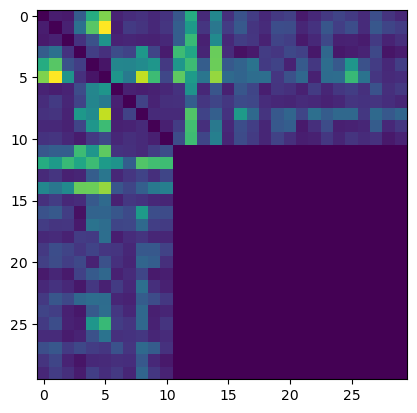

11
[6.7732731167481735, 6.744666727388926]
6.7732731167481735
[4.770702980995767, 3.8964257803502527]
4.770702980995767
[3.2764459841399227, 2.473725888239175]
3.2764459841399227
[1.7480596796106411, 1.5618812982966852]
1.7480596796106411
[9.415299182500684, 8.789937832268308]
9.415299182500684
[5.96234922837672, 5.381958114440725]
5.96234922837672
[2.3732210996835055, 2.141743878701955]
2.3732210996835055
[4.261959220625231, 3.843281867065107]
4.261959220625231
[3.417710756305193, 2.8688247626864034]
3.417710756305193
[2.2267899444246555, 1.4589573605052448]
2.2267899444246555
[3.8198313216243918, 2.848913410074187]
3.8198313216243918
[2.732169725137935, 1.6260193780397294]
2.732169725137935
[4.5849436290684435, 4.032425332727965]
4.5849436290684435
[5.915907597762043, 5.708032849743922]
5.915907597762043
[2.6969072897594506, 2.4994198168587687]
2.6969072897594506
[3.7320409359039646, 2.947459896413183]
3.7320409359039646
[3.9033624678945578, 3.317173491650111]
3.9033624678945578
[4.3

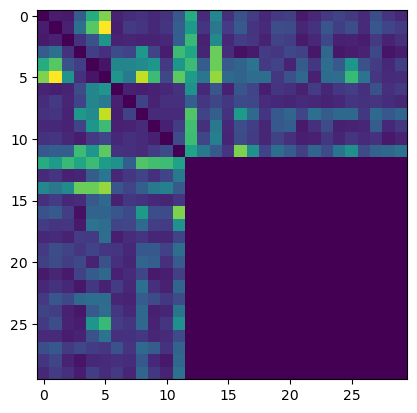

12
[3.106394147141891, 4.431440240910645]
4.431440240910645
[0.8681500213617688, 1.1189343746404679]
1.1189343746404679
[8.366376799290263, 8.283672038363152]
8.366376799290263
[2.742183122984915, 3.446590003122707]
3.446590003122707
[3.547344436086837, 3.859415900993992]
3.859415900993992
[4.371716987626902, 6.161680420406477]
6.161680420406477
[3.8847407352945083, 4.5839602289425425]
4.5839602289425425
[5.815473318295041, 6.982966608382974]
6.982966608382974
[3.861987992737541, 4.140428941534818]
4.140428941534818
[3.4271341421377333, 4.387408082063113]
4.387408082063113
[2.665019668824155, 2.7268150746064808]
2.7268150746064808
[6.217260108714031, 6.632626343237029]
6.632626343237029
[7.435341570840732, 8.134113209161935]
8.134113209161935
[6.333324966643601, 7.271819811978936]
7.271819811978936
[1.812777185136301, 2.2810922453398623]
2.2810922453398623
[5.508754743977464, 5.581560421898795]
5.581560421898795
[4.7846187536810945, 5.177419643376257]
5.177419643376257


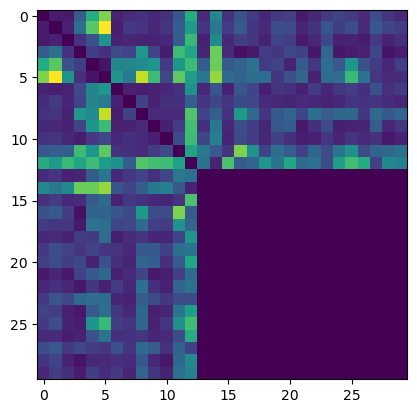

13
[4.861113317209681, 3.827487894156605]
4.861113317209681
[1.569078645596659, 2.2620101926879554]
2.2620101926879554
[1.3032989905149766, 0.566044192207575]
1.3032989905149766
[1.0324944311501256, 0.6304617095715902]
1.0324944311501256
[0.9890122319366039, 1.0119793819240797]
1.0119793819240797
[1.6764776063677544, 1.493071268835791]
1.6764776063677544
[2.5847157576092545, 2.36984456840744]
2.5847157576092545
[0.7429098038037444, 1.0397936531022969]
1.0397936531022969
[1.2673955830700931, 0.6401858134734917]
1.2673955830700931
[2.321204697375315, 2.2376512325424147]
2.321204697375315
[0.9978290626285619, 0.8803713287659551]
0.9978290626285619
[1.0499792419753982, 1.1271331041708388]
1.1271331041708388
[0.5741074088559297, 0.6690092976464432]
0.6690092976464432
[1.0854145973204958, 1.0466813874835237]
1.0854145973204958
[1.0081750725775591, 0.9348388503679981]
1.0081750725775591
[0.5102944326963202, 0.4846831516683901]
0.5102944326963202


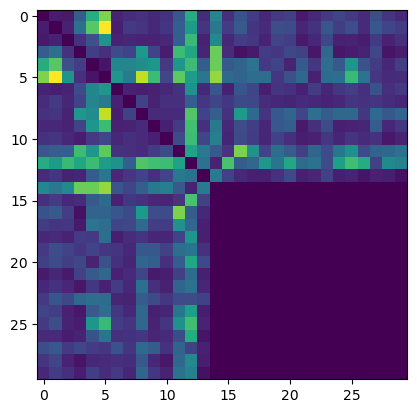

14
[4.487780139185773, 4.220330155414143]
4.487780139185773
[7.3128636155151305, 7.830757831910259]
7.830757831910259
[5.04085278582126, 6.2339785792238995]
6.2339785792238995
[2.0610249158395173, 3.1623425165835624]
3.1623425165835624
[5.116116234788936, 5.323428789521751]
5.323428789521751
[4.448643997078092, 4.514738933487233]
4.514738933487233
[2.958486489646217, 3.9837978465317243]
3.9837978465317243
[4.222080360751068, 4.763325052811846]
4.763325052811846
[1.6462574968326396, 1.6658672150306735]
1.6658672150306735
[5.764739854242048, 6.475295365171265]
6.475295365171265
[7.3602224523002535, 9.328248157996462]
9.328248157996462
[4.180608846460855, 4.60825580888168]
4.60825580888168
[1.698009728780989, 1.835480871564319]
1.835480871564319
[7.051168129647582, 7.368460634008031]
7.368460634008031
[5.554751321728471, 5.967083249495277]
5.967083249495277


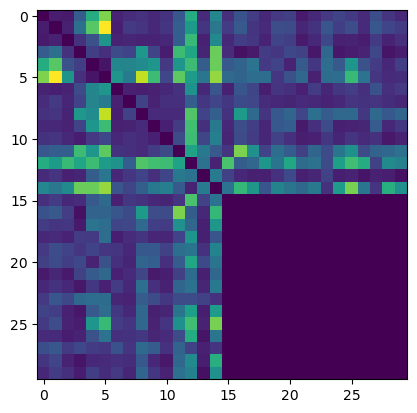

15
[2.157943390221156, 1.5842468011448225]
2.157943390221156
[1.4736420044860732, 1.1698223678234472]
1.4736420044860732
[1.2156259766341586, 1.1566679304591418]
1.2156259766341586
[1.7693698125013504, 1.323107905547181]
1.7693698125013504
[1.4964515707014714, 1.2481971535038674]
1.4964515707014714
[0.8746149874470026, 0.7048879513520333]
0.8746149874470026
[0.9611152354937855, 0.786991889900394]
0.9611152354937855
[2.86872304887396, 2.6825629150375643]
2.86872304887396
[0.8798032584904364, 0.8789987818938099]
0.8798032584904364
[1.3010980354650623, 1.9177945131994485]
1.9177945131994485
[0.7237344206324653, 0.9785373666141697]
0.9785373666141697
[2.887217079063324, 2.9390932504911262]
2.9390932504911262
[1.1494371060979947, 0.6913806523345412]
1.1494371060979947
[1.8558037148214774, 1.2664738581596375]
1.8558037148214774


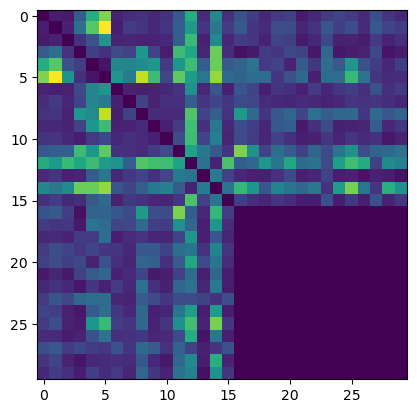

16
[0.4974801478647369, 0.5026684535024092]
0.5026684535024092
[2.3051204292498277, 4.096531364011331]
4.096531364011331
[1.406070100877837, 1.8755634315096754]
1.8755634315096754
[4.128087689527323, 4.69257235943615]
4.69257235943615
[1.1981903395851996, 1.8088064725530217]
1.8088064725530217
[0.4450272512157501, 0.5086969998073314]
0.5086969998073314
[3.3622985402651158, 3.791708323990601]
3.791708323990601
[0.596429594358867, 0.976932302351277]
0.976932302351277
[0.7927810866653089, 1.8965804244214093]
1.8965804244214093
[0.6629271221859669, 1.3158951329415434]
1.3158951329415434
[0.9279703337198929, 2.090718244239054]
2.090718244239054
[1.093810461987583, 1.2268737583494134]
1.2268737583494134
[0.8463565720508556, 1.1616219167291444]
1.1616219167291444


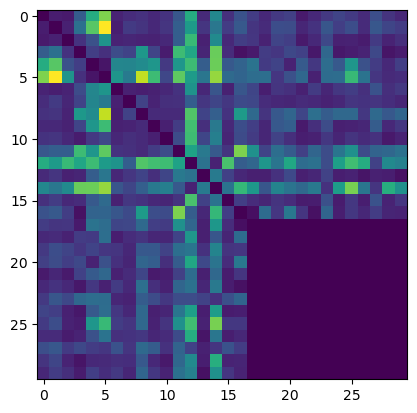

17
[1.3004924643844396, 1.8030846497346882]
1.8030846497346882
[1.314564962082347, 1.3064517305420629]
1.314564962082347
[2.016989008738671, 2.140217548166273]
2.140217548166273
[0.8020928100462815, 1.2831469652250123]
1.2831469652250123
[0.7161757748363128, 0.6775886388200746]
0.7161757748363128
[3.327817608323146, 3.3358597278621605]
3.3358597278621605
[0.5612575681298414, 0.866023940821121]
0.866023940821121
[0.9801963404559375, 1.5390669202714649]
1.5390669202714649
[0.5696399210676507, 0.8965507075363455]
0.8965507075363455
[2.0465285737318646, 2.3745466635766297]
2.3745466635766297
[0.9536432107900659, 1.0101041102399626]
1.0101041102399626
[0.7713516449161296, 0.8220447703991063]
0.8220447703991063


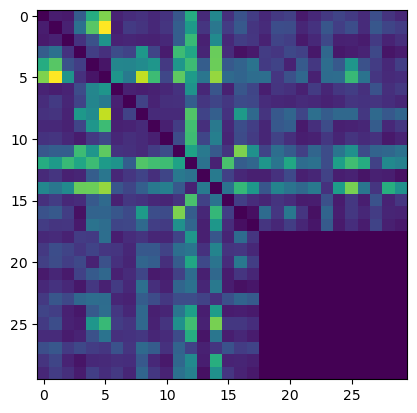

18
[1.8772763193930193, 1.4945091484041932]
1.8772763193930193
[0.7975205461877564, 0.6090795674868026]
0.7975205461877564
[1.0476059698818514, 0.6987661575429049]
1.0476059698818514
[2.5003222500982742, 1.521635318025009]
2.5003222500982742
[2.545523153933283, 1.4608345837916377]
2.545523153933283
[1.0334249163960618, 0.7585470447101771]
1.0334249163960618
[1.3336642344717697, 1.121051801495783]
1.3336642344717697
[1.0094321946327087, 0.8801723429360029]
1.0094321946327087
[1.4050666562069594, 1.440067548456502]
1.440067548456502
[1.2539468831702723, 0.6876983425819723]
1.2539468831702723
[1.1429414855083735, 0.7814247830628934]
1.1429414855083735


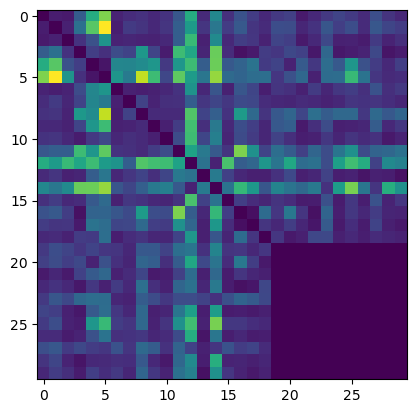

19
[0.8130222790486166, 0.8965910169346116]
0.8965910169346116
[1.6134336053599017, 1.8474405830170464]
1.8474405830170464
[1.2448590041230656, 0.9830874835770816]
1.2448590041230656
[1.8390016613314115, 1.917883743758882]
1.917883743758882
[2.19151127177917, 1.9428010735719243]
2.19151127177917
[2.7036894216341105, 2.706597804342724]
2.706597804342724
[1.512158248330984, 1.6662834165407852]
1.6662834165407852
[1.4943227625537148, 1.4612787540750756]
1.4943227625537148
[1.5224626681587372, 0.9247984542870419]
1.5224626681587372
[0.7643265640921582, 0.6596562867866813]
0.7643265640921582


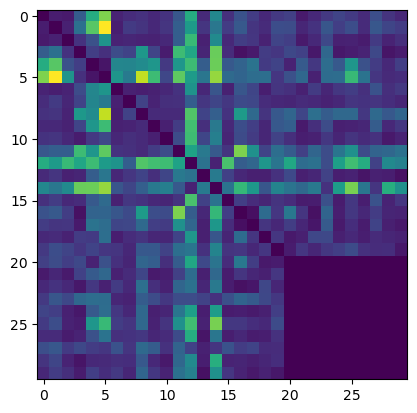

20
[2.1909211243863855, 3.1245926331170857]
3.1245926331170857
[2.1533597056196827, 1.8112508508463858]
2.1533597056196827
[2.4519641801849197, 1.8644322490704628]
2.4519641801849197
[1.5887613906906182, 2.1216669563386703]
2.1216669563386703
[2.4893996150851234, 2.70056541786652]
2.70056541786652
[0.9950156765634464, 1.6418514518232503]
1.6418514518232503
[1.5404781240881111, 2.0532597127564305]
2.0532597127564305
[1.2888719137798386, 1.2667111181167134]
1.2888719137798386
[0.5525253146658992, 0.5675436193258833]
0.5675436193258833


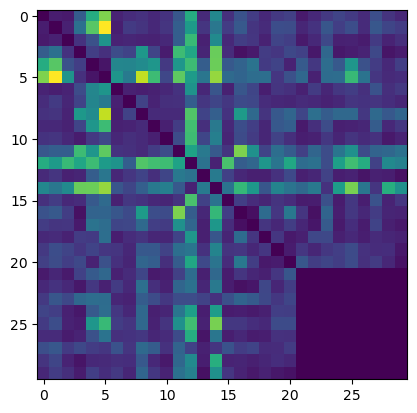

21
[0.9685672187890119, 0.39928138384848]
0.9685672187890119
[1.7774148310200786, 1.7453079313083837]
1.7774148310200786
[1.2103808854170102, 0.826941871684931]
1.2103808854170102
[1.721543919643444, 1.3419034235010536]
1.721543919643444
[0.9833461234086323, 1.1197311608213512]
1.1197311608213512
[1.4118726251247058, 1.1147014372109818]
1.4118726251247058
[0.8003405760935592, 0.5385239636493088]
0.8003405760935592
[1.14775104734374, 0.885292465891789]
1.14775104734374


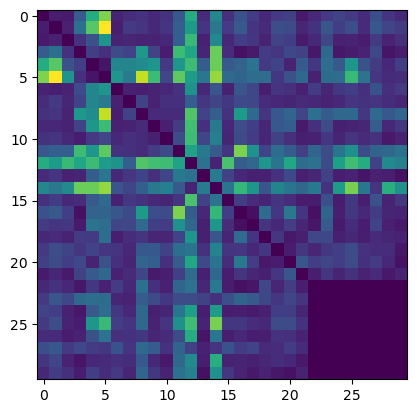

22
[1.4719849784644277, 1.637765546540505]
1.637765546540505
[0.5166497173598542, 0.9659325589052992]
0.9659325589052992
[0.9657884437552936, 1.6789505856721119]
1.6789505856721119
[0.644046880206655, 1.145008913798793]
1.145008913798793
[1.2555635890411514, 1.5815873127938018]
1.5815873127938018
[0.40500902735358046, 0.6823754157015098]
0.6823754157015098
[0.5619130293159521, 0.7744659294218238]
0.7744659294218238


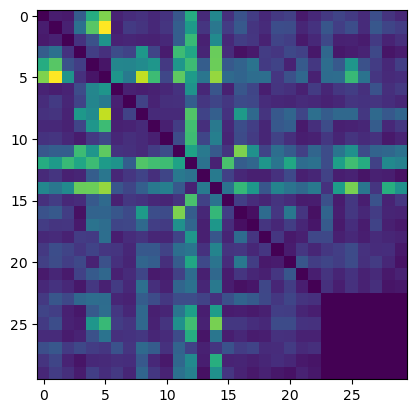

23
[2.4819467384475318, 2.4772417993221754]
2.4819467384475318
[3.711341077358296, 4.17784429902783]
4.17784429902783
[1.9213575502274363, 2.2795496595447164]
2.2795496595447164
[1.2657519990261965, 1.4800936424596292]
1.4800936424596292
[2.274850383053084, 1.9698714777243496]
2.274850383053084
[1.7232212002755778, 1.4753551738308515]
1.7232212002755778


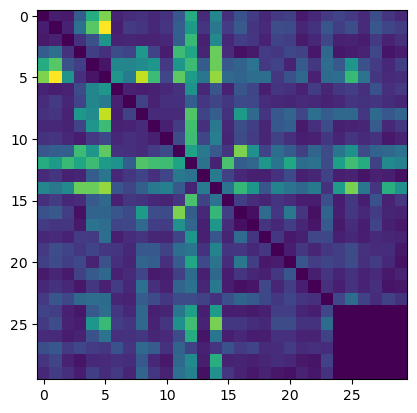

24
[0.5858798135401833, 0.6347042735546634]
0.6347042735546634
[0.7341525169404148, 0.8209970240956825]
0.8209970240956825
[1.7496119816781195, 1.8503607130214175]
1.8503607130214175
[0.7856616160426676, 0.453024211068206]
0.7856616160426676
[1.0227982156064694, 0.8854088126872206]
1.0227982156064694


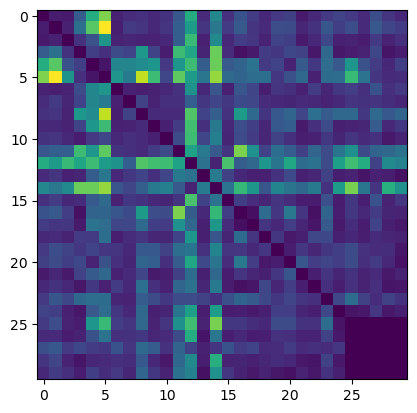

25
[1.0877261797481932, 1.0407903450194216]
1.0877261797481932
[2.8446140362578847, 2.903908549840421]
2.903908549840421
[1.1365256313965377, 0.7539421017467552]
1.1365256313965377
[1.495478915753392, 0.9947897820894145]
1.495478915753392


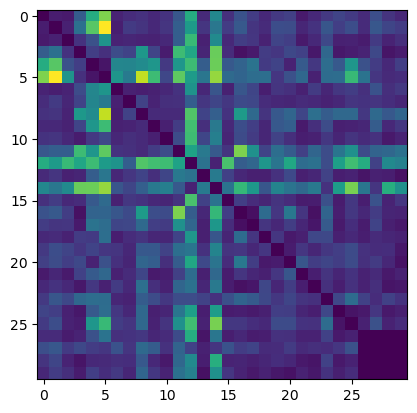

26
[1.7747947226452803, 1.3261893049434432]
1.7747947226452803
[1.0096485409815223, 0.627476310240236]
1.0096485409815223
[0.8639602330272412, 0.5094908558884317]
0.8639602330272412


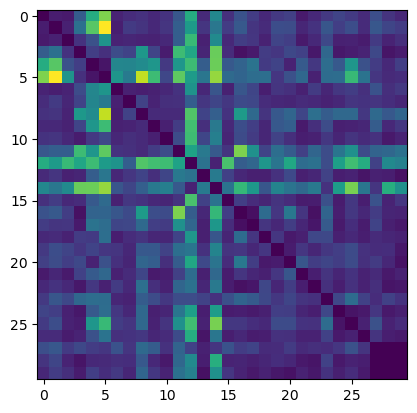

27
[1.1326455267459123, 1.0027349512987853]
1.1326455267459123
[1.1929376958883309, 0.9947793508266686]
1.1929376958883309


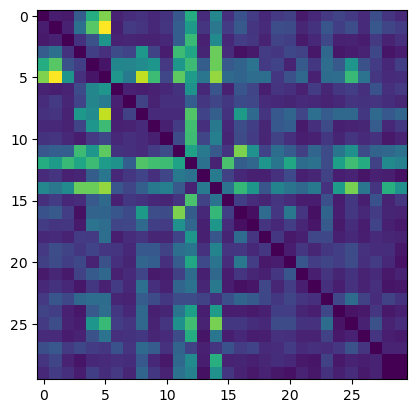

28
[0.6912431720454252, 0.5796216389667657]
0.6912431720454252


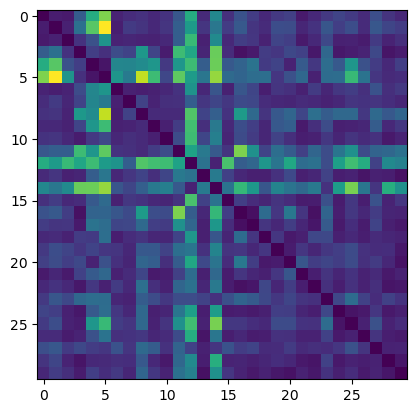

29


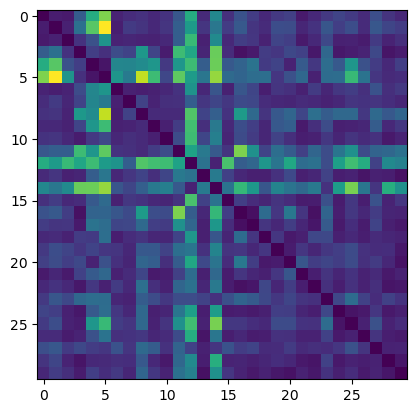

In [12]:
# new window=2
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

for i in range(len(dataset[1])):
    print(i)
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        image_diff = get_similarity_score(dataset[0][i, 0], dataset[0][j, 0], image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()

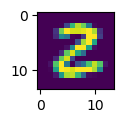

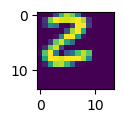

[0.5224877672082613, 0.3119773943502376]


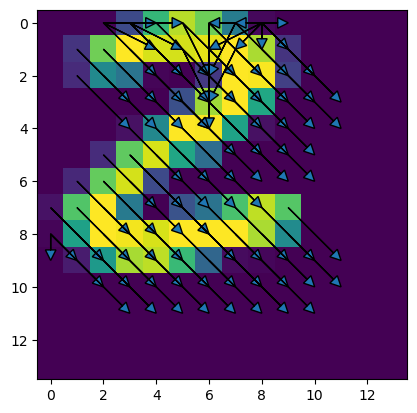

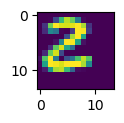

[0.0032337958182970935, 0.003233602818297095]


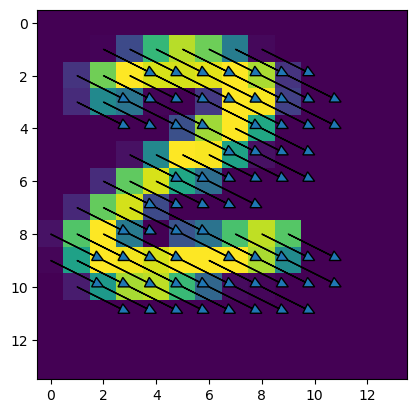

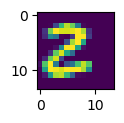

[0.0032336548182970944, 0.0032336038182970953]


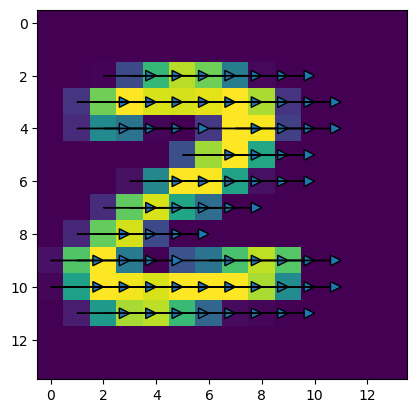

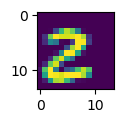

[0.0032337838182970946, 0.0032336018182970946]


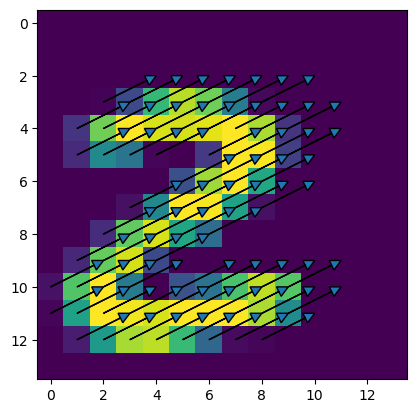

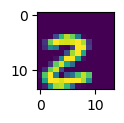

[0.7622830627480486, 0.9597311494361319]


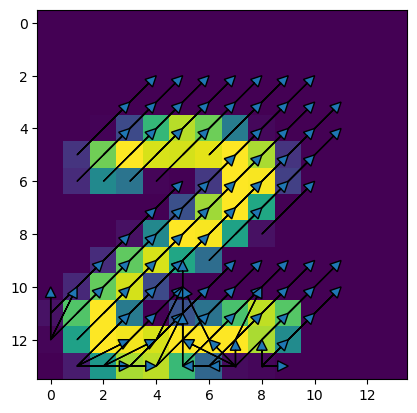

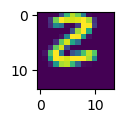

[0.4091256054403444, 0.2614843344570248]


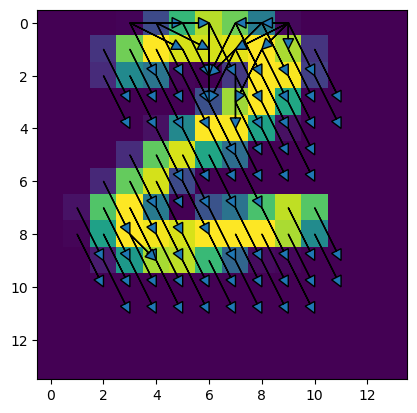

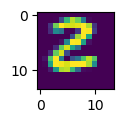

[0.003233657818297094, 0.003233672818297094]


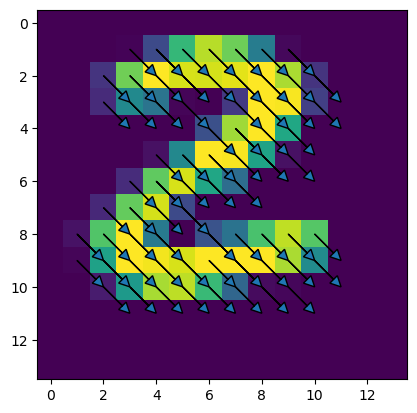

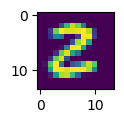

[0.0032336548182970944, 0.0032336678182970945]


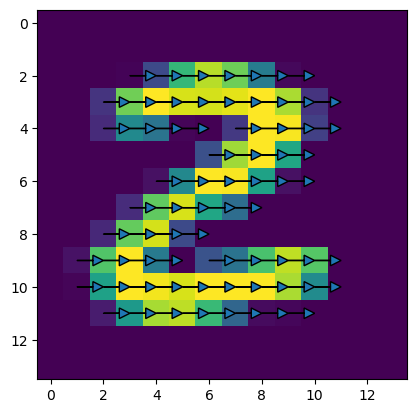

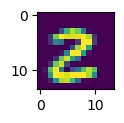

[0.0032336558182970952, 0.0032336528182970946]


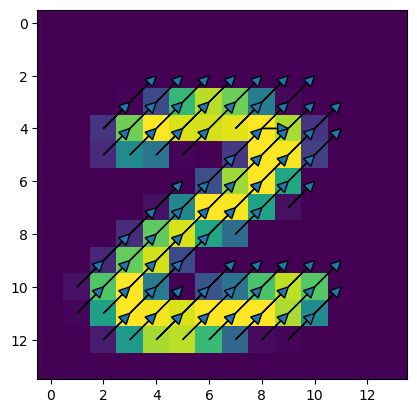

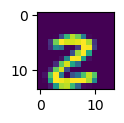

[0.47892284866426116, 0.5023878346035798]


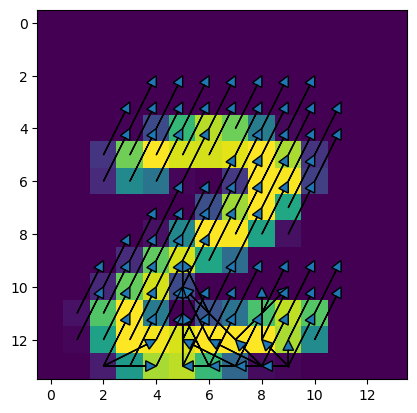

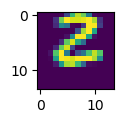

[0.35933326119542014, 0.2642332476878974]


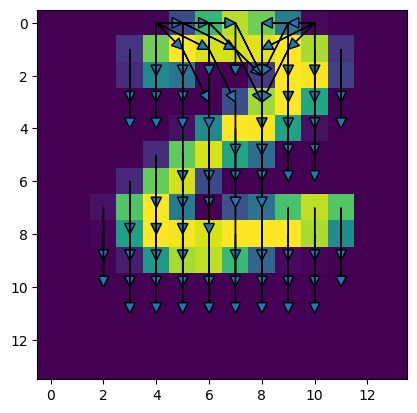

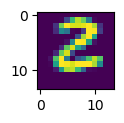

[0.0032336678182970937, 0.0032336458182970944]


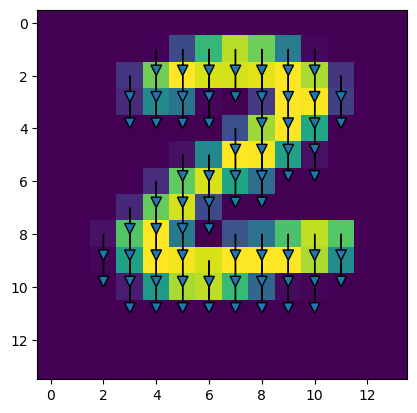

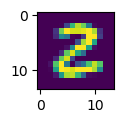

[0.0032335678182970947, 0.0032335678182970947]


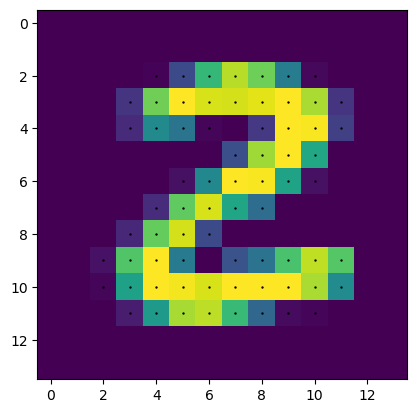

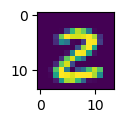

[0.0032336588182970945, 0.003233654818297095]


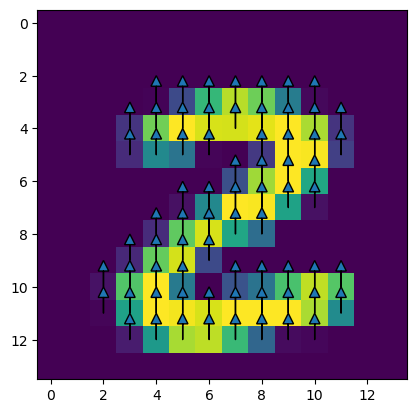

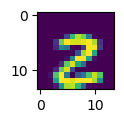

[0.5207971034986845, 0.3889170438085647]


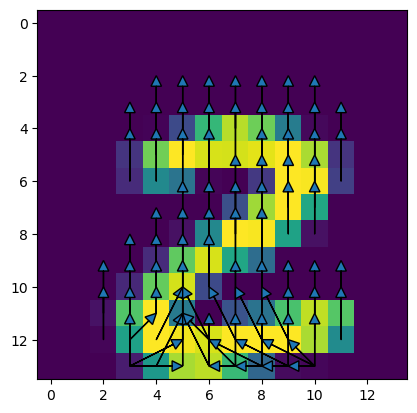

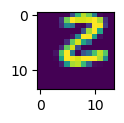

[0.25265501505497834, 0.16312502315488658]


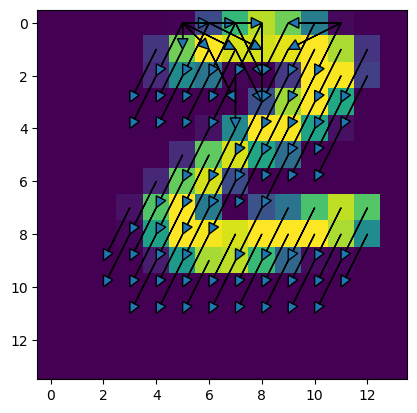

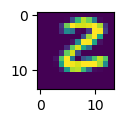

[0.0032336648182970944, 0.0032336048182970943]


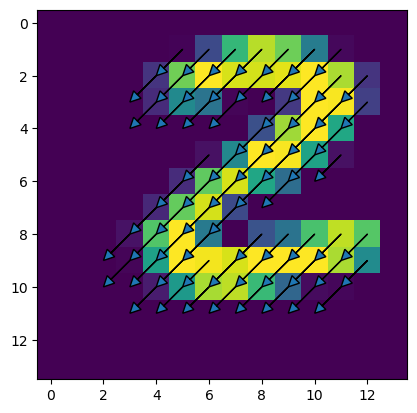

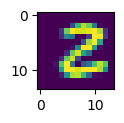

[0.0032336708182970943, 0.0032336748182970943]


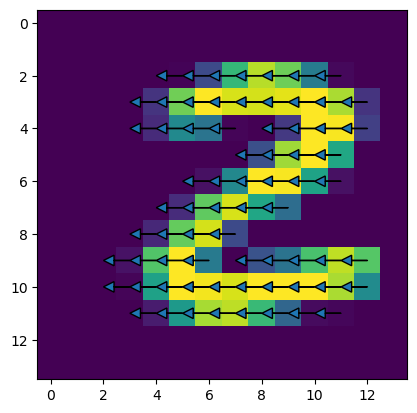

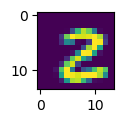

[0.0032336688182970945, 0.003233636818297095]


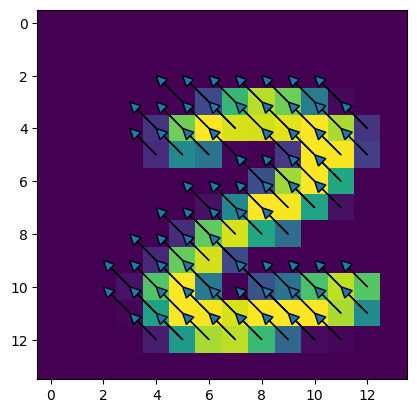

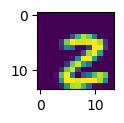

[0.5023609233640326, 0.44480519464215995]


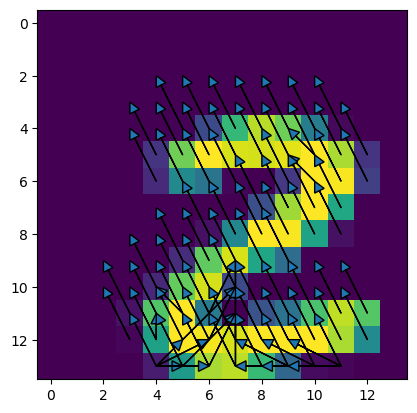

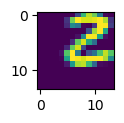

[0.6219303263863649, 0.5640795849135327]


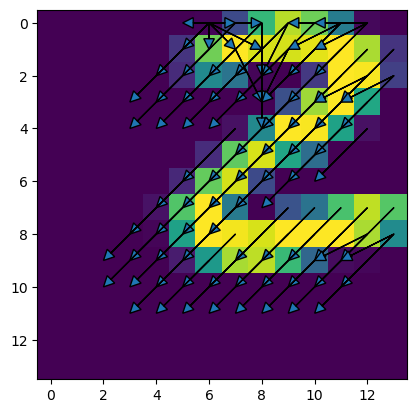

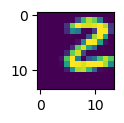

[0.003233801818297093, 0.003233657818297094]


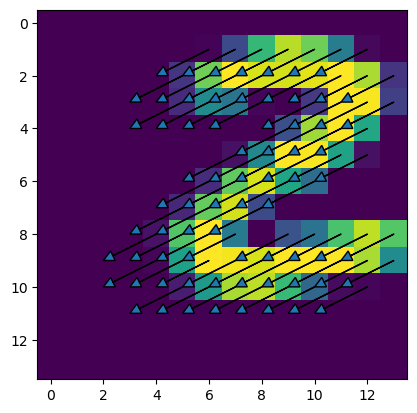

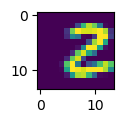

[0.0032336488182970946, 0.0032336218182970945]


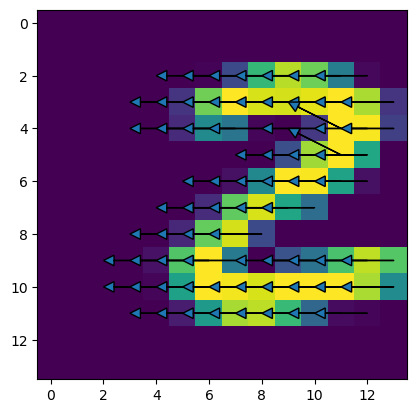

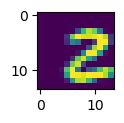

[0.0032336518182970947, 0.0032336098182970947]


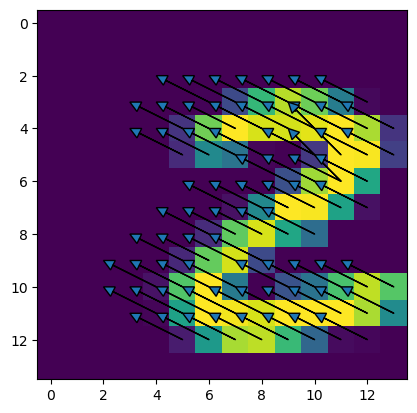

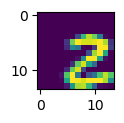

[1.0373012825201398, 0.5349118393714944]


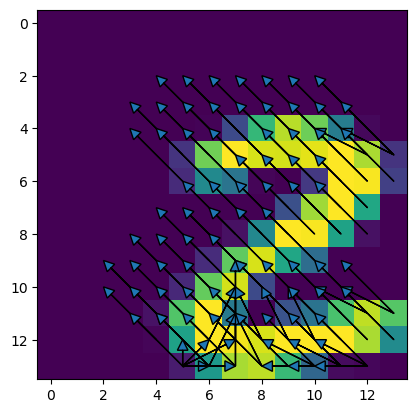

In [11]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()

for x in range(2*window_size+1):
    for y in range(2*window_size+1):
        test_img2 = torch.zeros(test_img1.shape)
        test_img2[y:test_img2.shape[0]+y-2*window_size, x:test_img2.shape[1]+x-2*window_size] = test_img1[window_size:-1*window_size, window_size:-1*window_size]
        
        plt.figure(figsize=[1, 1])
        plt.imshow(test_img2)
        plt.show()

        image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

        shift_vals = m.getVars()

#         plt.imshow(test_img2)
#         for val in shift_vals:
#             if val.X == 1:
#                 index = find_between(val.VarName, "[", "]").split(",")
#                 if len(index) != 4:
#                     continue
#                 if test_img2[int(index[0]), int(index[1])] > 0:
#                     if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
#                         plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
#         plt.show()
        
        plt.imshow(test_img2)
        for val in shift_vals:
            if val.X == 1:
                index = find_between(val.VarName, "[", "]").split(",")
                if len(index) != 4:
                    continue
                if test_img2[int(index[0]), int(index[1])] > 0:
                    if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                        plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
                    else:
                        plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
        plt.show()

0
[1.1246088122446762, 1.0985534677583526]
1.1246088122446762
[1.5756007432561165, 1.578956156982388]
1.578956156982388
[9.766730224214088, 10.24366221870226]
10.24366221870226
[15.088657518221083, 14.153758423031581]
15.088657518221083
[15.176551554728128, 14.473358526157325]
15.176551554728128
[2.9861322343660284, 3.4358314929975737]
3.4358314929975737
[3.9625327275989837, 3.9840032536016983]
3.9840032536016983
[4.555540138971315, 4.972040490139735]
4.972040490139735
[4.4212861494153755, 4.888460308002202]
4.888460308002202
[5.937778796889275, 6.319560786774896]
6.319560786774896
[7.969482859070768, 8.204698109212126]
8.204698109212126
[14.428295046316805, 13.829781036251783]
14.428295046316805
[5.573438180240644, 5.336790680160953]
5.573438180240644
[13.768404753276277, 13.98972722482221]
13.98972722482221
[6.364111040637079, 6.514831888094073]
6.514831888094073
[7.27231364783137, 7.488844824889938]
7.488844824889938
[4.946898445490926, 5.091003576868417]
5.091003576868417
[4.322179

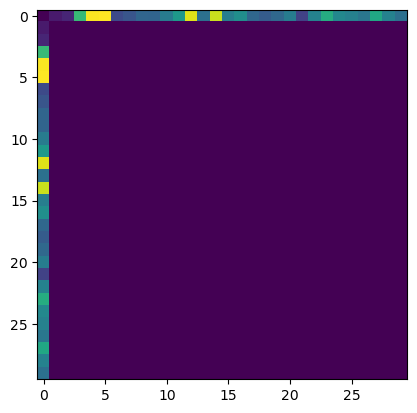

1
[2.1651431987879595, 1.9732208045077215]
2.1651431987879595
[10.903374739198272, 10.970357526739456]
10.970357526739456
[17.102248275977992, 16.47568731690067]
17.102248275977992
[17.598388124462073, 17.18528354529719]
17.598388124462073
[3.1128325397605154, 3.2778509036890657]
3.2778509036890657
[5.746261059744537, 5.629921216725308]
5.746261059744537
[3.48836900985165, 3.8259112677409384]
3.8259112677409384
[3.9702970787707486, 4.497828804048167]
4.497828804048167
[5.75958582969833, 5.959591608533339]
5.959591608533339
[8.302895824754199, 8.628284172332432]
8.628284172332432
[13.14522982078811, 12.557738478167893]
13.14522982078811
[5.94463859378592, 5.542288437142084]
5.94463859378592
[12.22535683557386, 11.28376715985539]
12.22535683557386
[6.788286238129396, 6.7785736351498995]
6.788286238129396
[7.501263947547197, 7.532980639807558]
7.532980639807558
[5.4284849974139835, 5.437493099047596]
5.437493099047596
[5.224865419721283, 5.236882025649926]
5.236882025649926
[7.86987591273

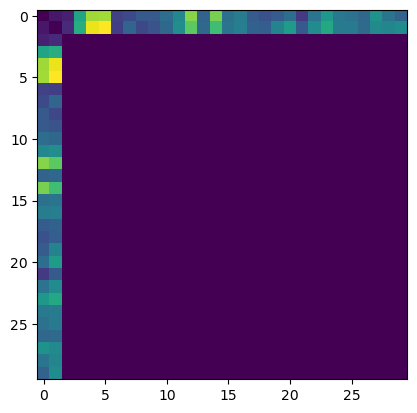

2
[4.741254423031082, 3.477761417351233]
4.741254423031082
[9.680105014588841, 9.405373178971418]
9.680105014588841
[13.31810666732715, 12.703412342132054]
13.31810666732715
[2.4940273561519932, 2.380037572539917]
2.4940273561519932
[5.067906426561653, 4.902100176344722]
5.067906426561653
[3.2466859971489095, 4.000346081284288]
4.000346081284288
[2.566958849063238, 2.8521098219597163]
2.8521098219597163
[4.167942337990881, 2.6292618841522937]
4.167942337990881
[6.2343656024035345, 6.126635843433045]
6.2343656024035345
[14.121693491835728, 14.165889019937941]
14.165889019937941
[3.061660924724392, 2.8834159754173365]
3.061660924724392
[12.074187827781206, 11.70498656962285]
12.074187827781206
[4.1188159503054615, 4.259001454931142]
4.259001454931142
[6.70808345957631, 6.228142149689468]
6.70808345957631
[3.8049191972430445, 3.6974143745062125]
3.8049191972430445
[2.8349855330362517, 2.8929258312939328]
2.8929258312939328
[4.553943635648031, 4.683366918718913]
4.683366918718913
[5.359474

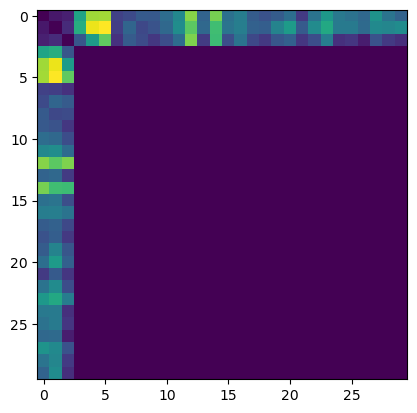

3
[8.957605888274376, 9.016813867515156]
9.016813867515156
[6.39036828124829, 6.6073550236951695]
6.6073550236951695
[4.841324628682515, 5.652950920108747]
5.652950920108747
[4.205838263914311, 4.449553173011554]
4.449553173011554
[9.608801504812796, 10.350351882472957]
10.350351882472957
[5.7441407042708486, 6.0938610893710425]
6.0938610893710425
[4.603578479143573, 4.6525634038509525]
4.6525634038509525
[14.300484427246827, 14.447519227949353]
14.447519227949353
[10.08037694843838, 10.009926160712212]
10.08037694843838
[1.9893983972558513, 2.55022013830742]
2.55022013830742
[14.307755781298091, 13.985637366740676]
14.307755781298091
[6.266576174166538, 6.6385129630120305]
6.6385129630120305
[1.6041446357372042, 1.706247659221933]
1.706247659221933
[1.5937956599776393, 1.7116907290392094]
1.7116907290392094
[6.472359789095438, 6.9047819907940555]
6.9047819907940555
[3.8154172357658904, 3.8177721338784902]
3.8177721338784902
[9.075534697039798, 9.328927687025326]
9.328927687025326
[4.1

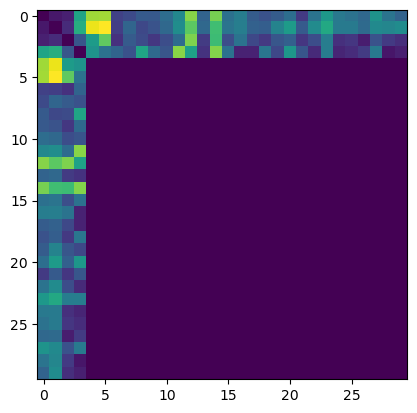

4
[0.6781823641403493, 0.6691675579273146]
0.6781823641403493
[10.047352152568003, 10.530907525564404]
10.530907525564404
[7.136065133427401, 7.443401808238588]
7.443401808238588
[13.630458615332643, 14.507643243708973]
14.507643243708973
[10.557540490970744, 11.251307288479444]
11.251307288479444
[2.728936968706341, 3.0017204871995515]
3.0017204871995515
[9.996987758366929, 11.462911436510547]
11.462911436510547
[11.664831943207401, 11.92098248990838]
11.92098248990838
[8.164398655570123, 8.659961872223484]
8.659961872223484
[16.86060191960846, 17.07911597310433]
17.07911597310433
[5.744209243780038, 5.923047140183885]
5.923047140183885
[8.160487388637994, 8.056801375644454]
8.160487388637994
[7.707734578929127, 7.299749201737375]
7.707734578929127
[6.895075177538405, 7.220085693001137]
7.220085693001137
[2.5270317917398306, 3.8437869366886064]
3.8437869366886064
[3.4784276229261684, 3.755006785496927]
3.755006785496927
[9.785018415341655, 10.290986339736701]
10.290986339736701
[6.699

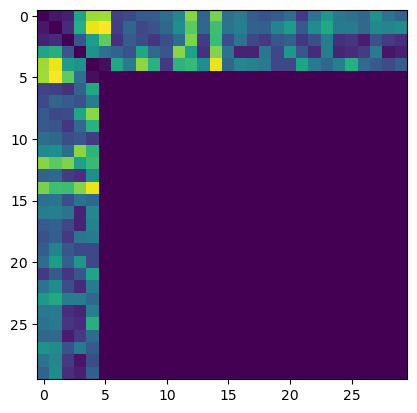

5
[11.387107955067384, 11.713421865318042]
11.713421865318042
[7.629854199570416, 8.32957930236683]
8.32957930236683
[17.048003862590132, 17.857480908041513]
17.857480908041513
[12.758592964950184, 13.354835767116773]
13.354835767116773
[3.7499144289401993, 3.8971529621805816]
3.8971529621805816
[13.013257448618372, 13.732000218535395]
13.732000218535395
[11.671066236823602, 11.752797314108898]
11.752797314108898
[6.993075853621488, 7.675015470648435]
7.675015470648435
[19.708115347462115, 19.97105748403224]
19.97105748403224
[7.3257758983643075, 7.760934449795739]
7.760934449795739
[5.6394367554019045, 5.772370306031668]
5.772370306031668
[5.912453905336692, 6.00637164023324]
6.00637164023324
[8.638333541782139, 9.083974586523237]
9.083974586523237
[2.482755611232862, 3.1358601390842047]
3.1358601390842047
[4.311775523119483, 4.543101905449364]
4.543101905449364
[9.648060423031163, 10.089592543743805]
10.089592543743805
[4.861149463285023, 5.081642593037604]
5.081642593037604
[5.26032

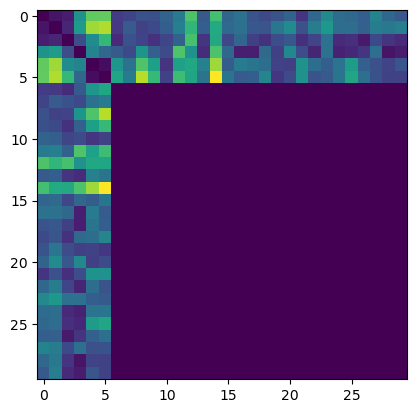

6
[1.7215109663498065, 1.5986908948355705]
1.7215109663498065
[2.4744972576877937, 2.3231929487383822]
2.4744972576877937
[2.268936979108436, 2.2159141364727883]
2.268936979108436
[4.431350681276309, 2.653368013349197]
4.431350681276309
[6.779941421741541, 6.590534507021231]
6.779941421741541
[13.164487749214318, 13.127023265769807]
13.164487749214318
[3.9466974753053834, 3.828633250645371]
3.9466974753053834
[9.49495302369489, 9.07313930338827]
9.49495302369489
[3.922784657620514, 4.088788114310509]
4.088788114310509
[6.327527897922895, 6.010327801322336]
6.327527897922895
[4.4753634070427655, 3.799049471271961]
4.4753634070427655
[2.5932737387814253, 2.662557651176983]
2.662557651176983
[4.90230011934969, 5.117406816216048]
5.117406816216048
[6.195384533317593, 6.074314747916608]
6.195384533317593
[4.885180791575817, 4.549326310365424]
4.885180791575817
[2.9190783233365667, 2.6700366400705575]
2.9190783233365667
[3.0630189994810406, 2.8560649540636205]
3.0630189994810406
[2.950909245

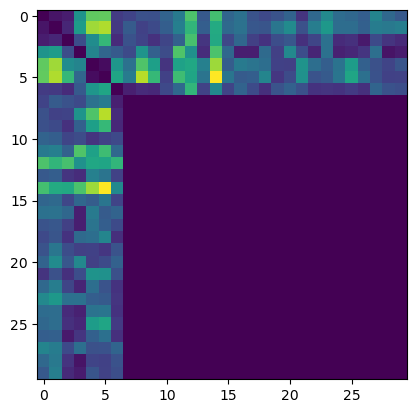

7
[4.9418137352561295, 4.989336748267506]
4.989336748267506
[1.9925692481936723, 2.119581945424546]
2.119581945424546
[4.677791245669926, 4.576337953364443]
4.677791245669926
[6.353259425441798, 6.527496192563981]
6.527496192563981
[9.751884216364337, 9.587156198043711]
9.751884216364337
[5.713075846354687, 5.670104932276942]
5.713075846354687
[9.24201371647983, 9.481034324396031]
9.481034324396031
[4.5349232334393985, 4.824681990380992]
4.824681990380992
[6.266943598097819, 6.515894019417734]
6.515894019417734
[5.868538168272876, 5.9166495576895315]
5.9166495576895315
[3.7784506846664137, 3.7187400221575615]
3.7784506846664137
[4.502448154025461, 4.176566772045023]
4.502448154025461
[5.045030920743056, 5.143722711721698]
5.143722711721698
[5.584404905878777, 5.1774450475148885]
5.584404905878777
[4.154918411499964, 3.526104431585875]
4.154918411499964
[2.047060776238874, 1.9676317211569392]
2.047060776238874
[3.572345316110872, 3.7478826410305857]
3.7478826410305857
[4.126805104925941

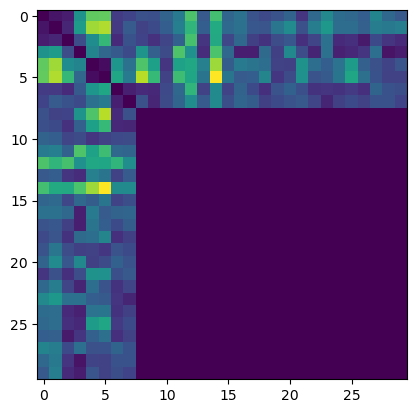

8
[2.62316615851568, 2.07839491618691]
2.62316615851568
[5.263503622476885, 4.471655265944256]
5.263503622476885
[5.302361435731418, 4.631484811362959]
5.302361435731418
[16.20249612361415, 15.963934038962666]
16.20249612361415
[9.342553981037192, 8.41613712311128]
9.342553981037192
[11.379352155925062, 10.941241784154025]
11.379352155925062
[4.900573874489733, 4.748754356995347]
4.900573874489733
[11.93936672457379, 11.424890653310294]
11.93936672457379
[9.453224844032864, 8.468805289991113]
9.453224844032864
[5.326096817552896, 5.690522900339718]
5.690522900339718
[7.839869210973574, 7.396816559029016]
7.839869210973574
[8.802779617469971, 8.44615329022048]
8.802779617469971
[8.956432302315285, 8.418374935220356]
8.956432302315285
[11.769834837555319, 11.243445952268232]
11.769834837555319
[9.320182878928534, 8.418249877696272]
9.320182878928534
[5.453313215802306, 5.381994493408593]
5.453313215802306
[6.450839198667289, 6.273064278711524]
6.450839198667289
[3.716833024557212, 3.5856

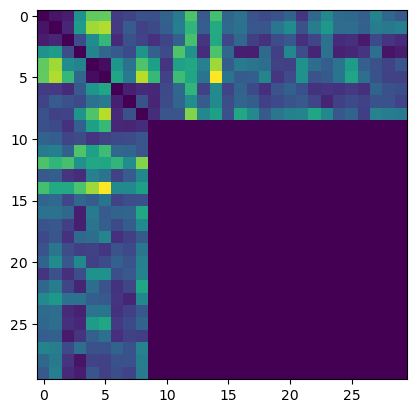

9
[2.9862603152976543, 2.2483305250246843]
2.9862603152976543
[4.9804026827757975, 5.008876357214614]
5.008876357214614
[13.683929335490419, 13.642347198394937]
13.683929335490419
[5.091989776553205, 4.730571083680701]
5.091989776553205
[11.53850174475728, 11.647443520157216]
11.647443520157216
[2.270709311352363, 2.7187312171149007]
2.7187312171149007
[8.799096489448385, 8.458274693822736]
8.799096489448385
[4.0861216112852645, 3.591301388038211]
4.0861216112852645
[3.907491469480967, 4.088900561651589]
4.088900561651589
[7.243181536103233, 7.138452651343984]
7.243181536103233
[9.328616886214519, 9.509875062921706]
9.509875062921706
[2.94224616282126, 2.1692233287171376]
2.94224616282126
[6.528954368994722, 6.08200129697978]
6.528954368994722
[7.6557709066533945, 7.524694373142291]
7.6557709066533945
[2.1126250394492256, 1.8655392944933242]
2.1126250394492256
[2.852611576765064, 2.386735007086444]
2.852611576765064
[2.159317605089614, 1.960910273934423]
2.159317605089614
[5.4309265555

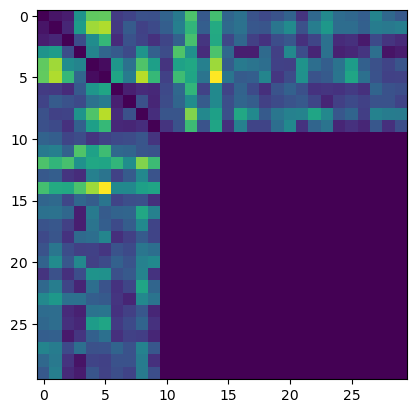

10
[4.550025041168094, 4.867669275028336]
4.867669275028336
[14.811676480225076, 14.907522346124548]
14.907522346124548
[7.26222152950651, 7.616137245052976]
7.616137245052976
[14.628756212305182, 14.515760269668107]
14.628756212305182
[1.8543811505265144, 1.990004889273242]
1.990004889273242
[7.927816167369452, 7.747784480317495]
7.927816167369452
[4.890753452359024, 4.696012964737017]
4.890753452359024
[2.6060978025541743, 2.7886726691747628]
2.7886726691747628
[3.5434197247143193, 3.353721574470332]
3.5434197247143193
[5.350383578799202, 5.152323149143214]
5.350383578799202
[4.206168769614201, 4.75153215617794]
4.75153215617794
[4.9098770713309, 4.89479149644802]
4.9098770713309
[5.643041176727634, 5.912811367249795]
5.912811367249795
[2.6630931177435024, 2.63702909642284]
2.6630931177435024
[3.8439341530675666, 4.455699825010073]
4.455699825010073
[1.8948500753319322, 2.270143210070138]
2.270143210070138
[4.035780582556235, 4.292178165560554]
4.292178165560554
[2.0107208938624166, 

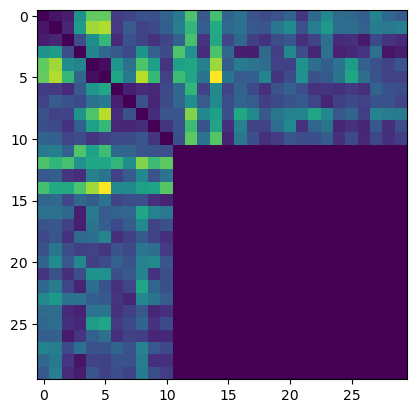

11
[13.356464009362607, 13.287563616226548]
13.356464009362607
[12.693814067639467, 11.85736928017337]
12.693814067639467
[10.184826203901919, 10.559207265908183]
10.559207265908183
[3.3735563680474274, 3.2082728353838403]
3.3735563680474274
[18.383564029491026, 18.136638762430678]
18.383564029491026
[13.193827439924638, 13.220011569555622]
13.220011569555622
[7.319478209512975, 7.342727913163262]
7.342727913163262
[6.534686560385046, 6.36395327358877]
6.534686560385046
[7.461815645088941, 7.425064429025616]
7.461815645088941
[10.763945634424438, 10.711046824516524]
10.763945634424438
[13.312001324565795, 13.287715513987619]
13.312001324565795
[6.380193266373038, 6.408137340522098]
6.408137340522098
[10.672407741627767, 11.10415898789963]
11.10415898789963
[13.459973009578881, 13.850796811280276]
13.850796811280276
[7.62037502277585, 7.474388826827619]
7.62037502277585
[11.646582017170694, 12.221854852682826]
12.221854852682826
[10.171918418639429, 11.363743662533004]
11.36374366253300

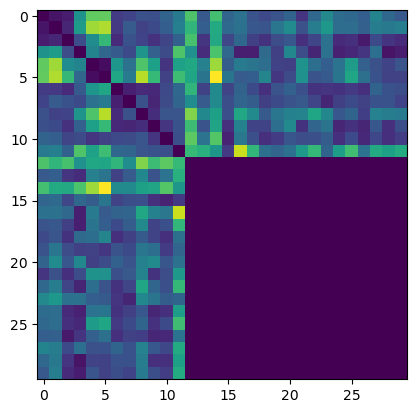

12
[7.649359080061744, 7.418672808006613]
7.649359080061744
[1.662589386072773, 1.6472933785907937]
1.662589386072773
[15.705760481265639, 15.695670030105415]
15.705760481265639
[7.953443825546635, 7.993967634220133]
7.993967634220133
[8.486649554617328, 8.730409632021779]
8.730409632021779
[13.221042978269578, 13.579217782495206]
13.579217782495206
[7.533380590363311, 7.579477300925902]
7.579477300925902
[9.723986323441729, 10.113665317786571]
10.113665317786571
[10.635529705194696, 10.16109773262706]
10.635529705194696
[8.788893716839537, 9.322853733584862]
9.322853733584862
[6.443592764599715, 6.53235191325799]
6.53235191325799
[12.904164862472923, 13.106461050052786]
13.106461050052786
[15.912196382686197, 15.87395049326904]
15.912196382686197
[12.129684797414296, 12.238333387383637]
12.238333387383637
[6.89350844956433, 7.133195047631789]
7.133195047631789
[10.524433176331412, 10.769471564242615]
10.769471564242615
[8.170469278090877, 8.737178265243447]
8.737178265243447


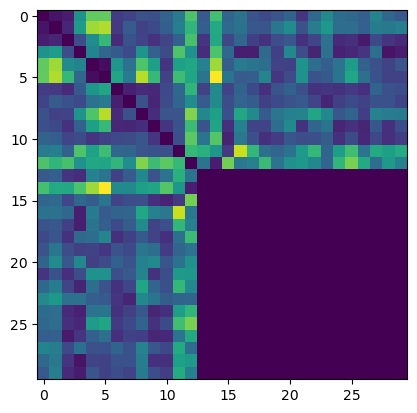

13
[10.082495382479038, 9.460477049434532]
10.082495382479038
[5.294244602236775, 5.739282141195462]
5.739282141195462
[1.7642147411350029, 1.3900172960730797]
1.7642147411350029
[2.1423576636304307, 2.0436234918699903]
2.1423576636304307
[4.4394060794908725, 4.622601050905296]
4.622601050905296
[4.944738807178954, 5.10030394232194]
5.10030394232194
[5.665315505509513, 5.494159194717001]
5.665315505509513
[1.8059275013980567, 1.8495905678150908]
1.8495905678150908
[2.8108987852243406, 2.5051153883847093]
2.8108987852243406
[6.2630008057800275, 6.325245177886275]
6.325245177886275
[1.4131612697358327, 1.5522184026307768]
1.5522184026307768
[3.9217061894067244, 3.6432863240542255]
3.9217061894067244
[2.030275866205224, 1.789891454433936]
2.030275866205224
[3.1459323943808153, 3.2311208251657058]
3.2311208251657058
[2.801584046002543, 2.8224269460000975]
2.8224269460000975
[2.0652720948100476, 1.978808249214993]
2.0652720948100476


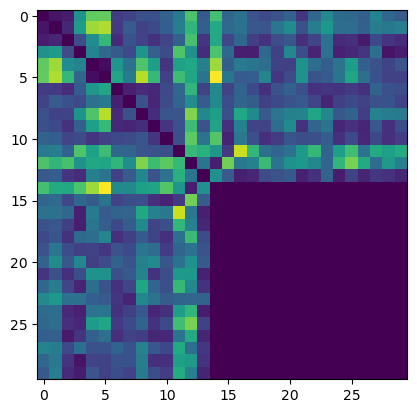

14
[16.249331239887315, 15.823514284943148]
16.249331239887315
[13.9685045628862, 14.60700794767645]
14.60700794767645
[11.639059108033956, 11.93975701906874]
11.93975701906874
[10.033228548671863, 10.83819204052907]
10.83819204052907
[10.540355615974889, 10.011112986695444]
10.540355615974889
[12.85505113152825, 13.14606511193183]
13.14606511193183
[11.047812233337515, 10.836355130422183]
11.047812233337515
[10.714105332642555, 11.323372005186691]
11.323372005186691
[5.953831185116689, 5.793270766462822]
5.953831185116689
[14.424001412990876, 14.501001622344186]
14.501001622344186
[15.887555917182116, 16.418023029069847]
16.418023029069847
[12.501517932035615, 12.77488973984988]
12.77488973984988
[8.76851026227842, 8.841016846820684]
8.841016846820684
[14.69763578703223, 14.40170353420242]
14.69763578703223
[11.923258419255177, 12.0666455344617]
12.0666455344617


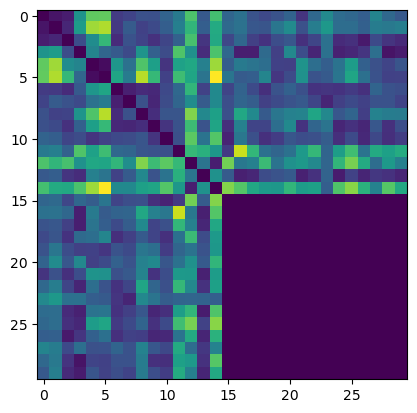

15
[8.622475015842543, 8.13776526661455]
8.622475015842543
[3.598882930217104, 3.6247614235945713]
3.6247614235945713
[4.86049212318321, 4.360306581784364]
4.86049212318321
[3.2899462687968715, 3.3395531235504095]
3.3395531235504095
[4.478485289384041, 4.409404195491369]
4.478485289384041
[3.365140346247723, 2.944407944351644]
3.365140346247723
[4.630371045532511, 4.235507545353067]
4.630371045532511
[7.728310469389203, 7.422429153165652]
7.728310469389203
[3.6279085018856088, 3.4478440797614622]
3.6279085018856088
[7.737595112541264, 7.4517003826311585]
7.737595112541264
[1.5418387099120918, 1.6662908269531544]
1.6662908269531544
[6.620116553465395, 6.639815706942574]
6.639815706942574
[2.8887658663829754, 2.379503100804984]
2.8887658663829754
[4.313652444820592, 4.195069215665193]
4.313652444820592


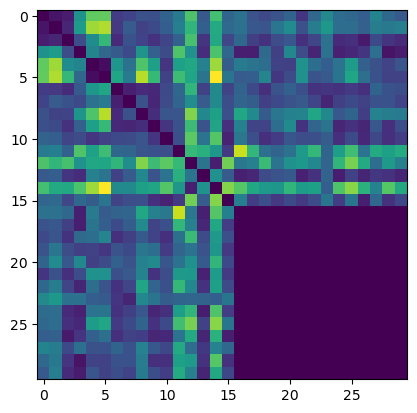

16
[0.6802556702583683, 0.71654463989027]
0.71654463989027
[8.211442712262409, 8.737227999782627]
8.737227999782627
[6.0185870710563645, 5.984186875551529]
6.0185870710563645
[8.680589508170048, 8.519408152055925]
8.680589508170048
[5.025141319247362, 5.545247993217258]
5.545247993217258
[1.295482436804497, 1.3859159530741472]
1.3859159530741472
[7.828796549407394, 7.64278533453625]
7.828796549407394
[2.20675410736112, 2.4865619405621064]
2.4865619405621064
[3.2947731675602023, 3.8808919515880644]
3.8808919515880644
[3.542818227713326, 3.9425788472485293]
3.9425788472485293
[3.930559485478742, 4.251767642236999]
4.251767642236999
[3.313614980180713, 3.6104614308395053]
3.6104614308395053
[2.7178739444592908, 3.25842662856988]
3.25842662856988


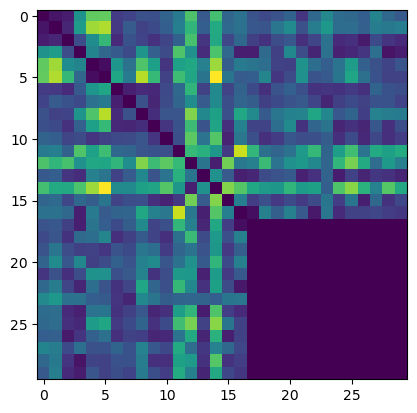

17
[5.992984452246835, 6.148365027575601]
6.148365027575601
[3.8944232896315323, 3.922588501842388]
3.922588501842388
[7.099921319929766, 7.113904439855396]
7.113904439855396
[4.04137916593402, 4.0361205958097255]
4.04137916593402
[2.161004413678677, 2.1455257359117823]
2.161004413678677
[6.853326630658871, 6.84991153362306]
6.853326630658871
[1.454821239997428, 1.81973572880046]
1.81973572880046
[2.528791814623422, 3.447996980262026]
3.447996980262026
[1.1854700272064815, 1.5532660483306264]
1.5532660483306264
[5.25205595198281, 5.571665723614474]
5.571665723614474
[3.6043637175470984, 3.77111882596755]
3.77111882596755
[3.434517596802398, 3.3715255262817476]
3.434517596802398


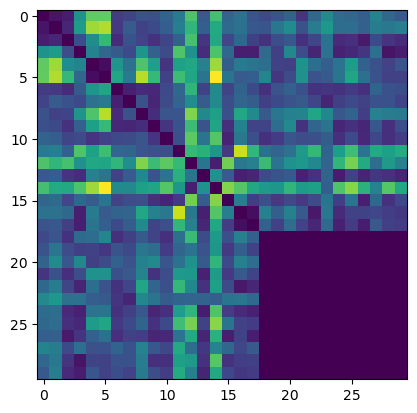

18
[2.606494609988899, 2.6879863967918074]
2.6879863967918074
[0.903926408291951, 0.8329777258817475]
0.903926408291951
[4.987247172535263, 4.832033905289752]
4.987247172535263
[4.471782028835733, 3.6213465778958804]
4.471782028835733
[5.221959916624859, 4.757415463797086]
5.221959916624859
[4.986500319647909, 4.406968383585855]
4.986500319647909
[4.419125447647359, 3.933107519190445]
4.419125447647359
[3.3062649677675147, 3.3975855886623028]
3.3975855886623028
[5.63743485186818, 5.266376612579345]
5.63743485186818
[4.714042735134868, 4.651671494021811]
4.714042735134868
[2.9003940831033885, 2.8268743106521477]
2.9003940831033885


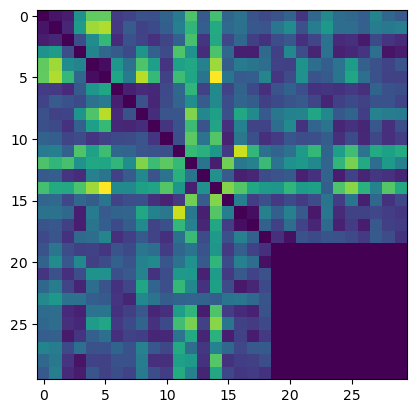

19
[1.0147203966819591, 0.9915465661459566]
1.0147203966819591
[5.716279293312104, 5.119556915679091]
5.716279293312104
[3.3855374350996414, 3.299277320517936]
3.3855374350996414
[4.373574602172093, 4.4323548270839765]
4.4323548270839765
[5.409076255360353, 5.6467425624773915]
5.6467425624773915
[8.235722001685426, 8.138702484803021]
8.235722001685426
[3.8017311210069904, 3.6203411963818857]
3.8017311210069904
[4.304750091973477, 4.29750766902153]
4.304750091973477
[2.994530851418847, 2.843415931674313]
2.994530851418847
[2.198922560788996, 2.0305776686333306]
2.198922560788996


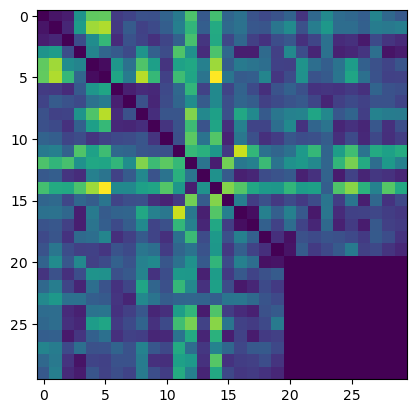

20
[7.750374994161183, 7.672924001057299]
7.750374994161183
[5.860285619650863, 5.433609333896499]
5.860285619650863
[5.955042418807356, 5.65802303700246]
5.955042418807356
[8.032961358476802, 8.21331315875275]
8.21331315875275
[11.12913502000446, 11.154029309581418]
11.154029309581418
[6.015794828753011, 5.918422686360877]
6.015794828753011
[6.824710917672309, 6.783601736011488]
6.824710917672309
[5.893309374942807, 5.729938573442107]
5.893309374942807
[4.79945412861183, 4.772241534433758]
4.79945412861183


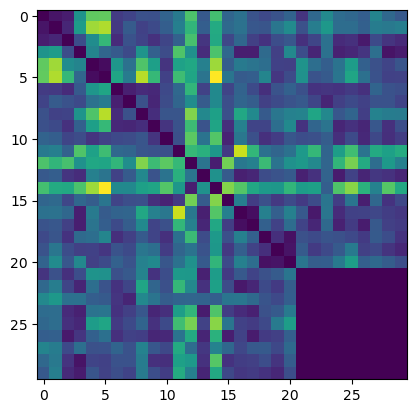

21
[1.466056325464808, 1.3348212503186165]
1.466056325464808
[6.0683882576963635, 6.61483287996063]
6.61483287996063
[2.438901410645967, 2.266717605707833]
2.438901410645967
[5.25992984585146, 5.294196410700097]
5.294196410700097
[1.997106849180693, 2.4343223475180498]
2.4343223475180498
[3.2675462013869634, 3.161210151772119]
3.2675462013869634
[1.998968625496989, 1.7598471186419506]
1.998968625496989
[1.781528202865809, 1.666828113805297]
1.781528202865809


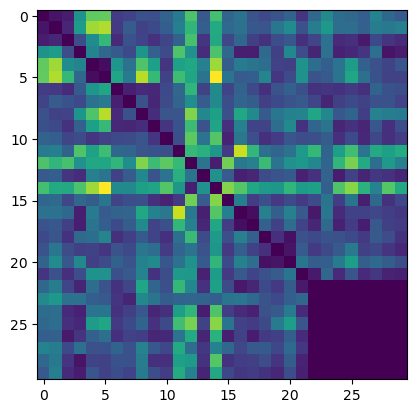

22
[3.4339629651370425, 3.225731497893419]
3.4339629651370425
[1.138870652496617, 1.3888956074712577]
1.3888956074712577
[2.682717301089577, 3.1293070150256286]
3.1293070150256286
[2.0727720359899307, 2.658387143374603]
2.658387143374603
[3.4063072172478335, 3.5684179529784537]
3.5684179529784537
[1.0274318465227215, 1.0832767061277448]
1.0832767061277448
[0.726716646727572, 0.8549807887243238]
0.8549807887243238


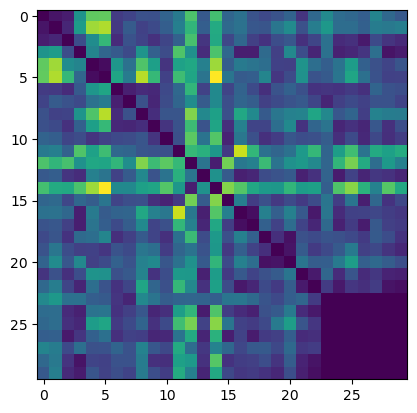

23
[6.284705012804115, 6.476497631135478]
6.476497631135478
[9.747075194436851, 10.47619471221306]
10.47619471221306
[5.83650519690451, 6.2219232951021475]
6.2219232951021475
[3.199719433032932, 3.4247271396039918]
3.4247271396039918
[5.526912791316822, 5.323268988072576]
5.526912791316822
[4.745893864888047, 4.725340211239526]
4.745893864888047


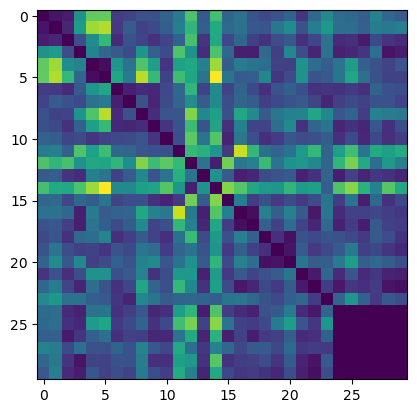

24
[0.7768809795767074, 0.7394818883773926]
0.7768809795767074
[0.9429364283122612, 1.0438620085572365]
1.0438620085572365
[4.636400436054877, 4.7132892236249]
4.7132892236249
[1.3882708792668965, 1.4242916179102885]
1.4242916179102885
[1.539865423272285, 1.381055352250591]
1.539865423272285


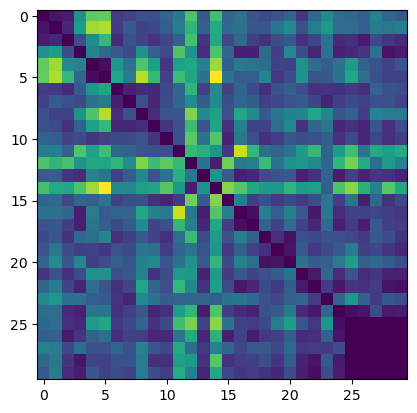

25
[1.6117810849776613, 1.7358390907058094]
1.7358390907058094
[6.9013082887297434, 6.981372636002245]
6.981372636002245
[3.1216907450275455, 3.1157901501959224]
3.1216907450275455
[4.332887380129595, 4.357911379602636]
4.357911379602636


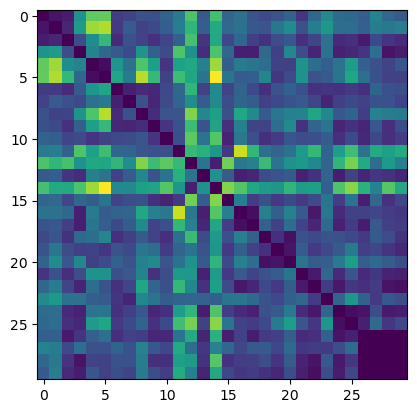

26
[4.283943851122776, 4.309974185028238]
4.309974185028238
[1.7226384029282393, 1.4046933766082932]
1.7226384029282393
[1.2362215849213511, 1.0775585738100193]
1.2362215849213511


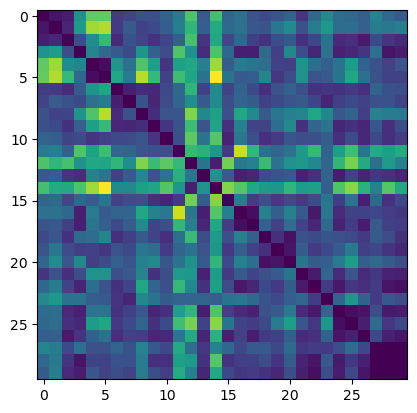

27
[3.175286595052088, 3.1387573825561597]
3.175286595052088
[2.8006642963655866, 2.7381095193776015]
2.8006642963655866


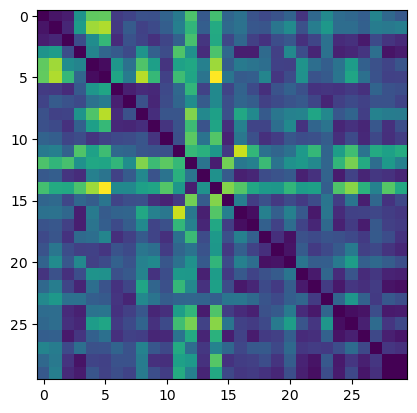

28
[0.7484208587587635, 0.864094600963178]
0.864094600963178


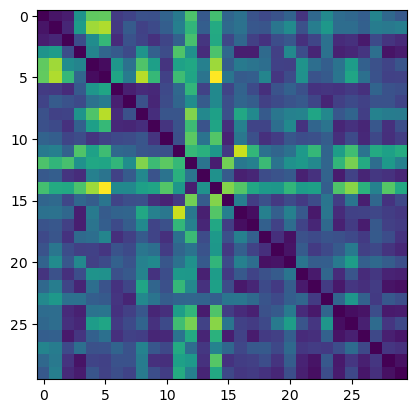

29


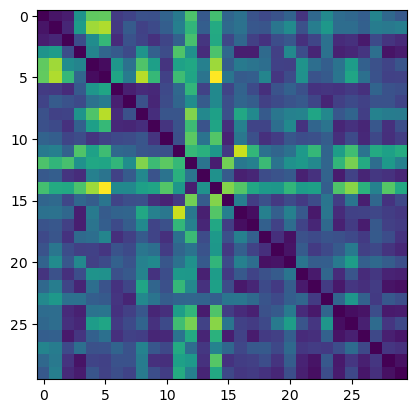

In [12]:
# new window=1
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

for i in range(len(dataset[1])):
    print(i)
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        image_diff = get_similarity_score(dataset[0][i, 0], dataset[0][j, 0], image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()

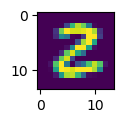

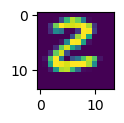

[2.2199999999999998e-09, 2.34e-09]


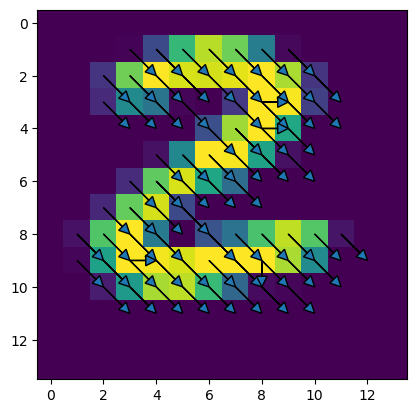

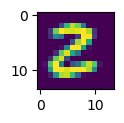

[2.3900000000000006e-09, 2.4000000000000004e-09]


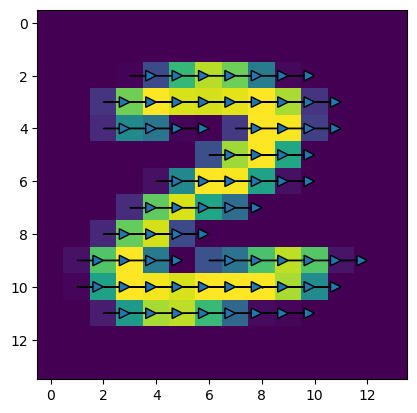

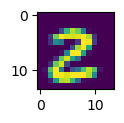

[9.633594489184031e-07, 2.23e-09]


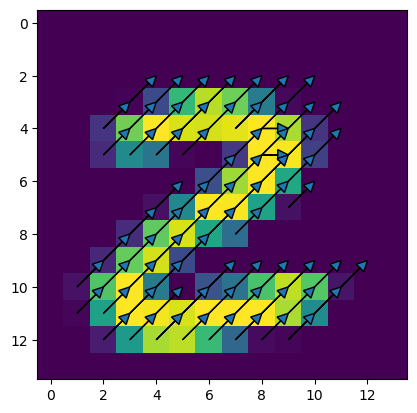

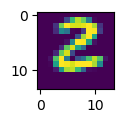

[2.5500000000000005e-09, 2.600000000000001e-09]


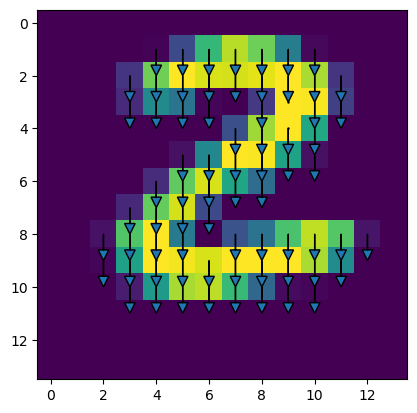

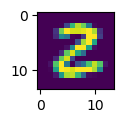

[1.96e-09, 1.96e-09]


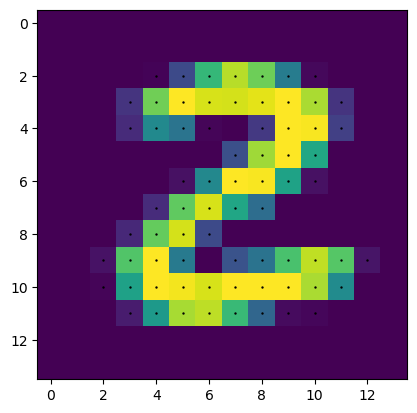

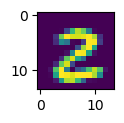

[2.600000000000001e-09, 2.5500000000000005e-09]


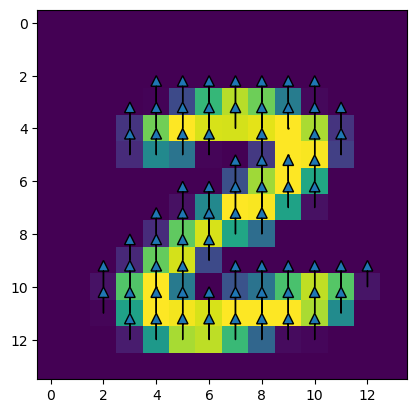

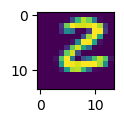

[2.21e-09, 9.63349448918403e-07]


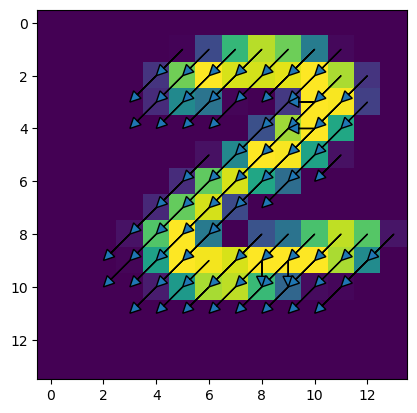

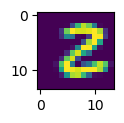

[2.3900000000000006e-09, 2.36e-09]


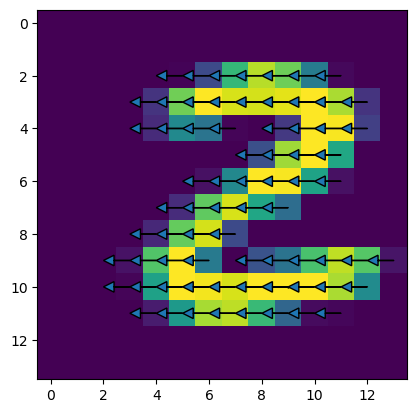

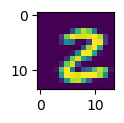

[2.3e-09, 2.28e-09]


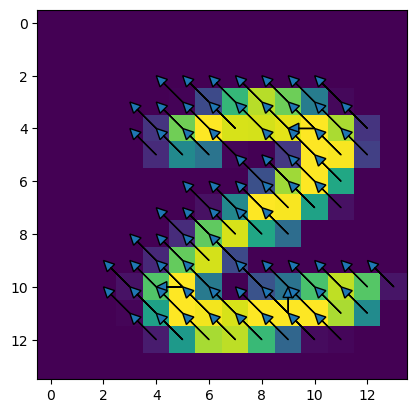

In [11]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()

for x in range(3):
    for y in range(3):
        test_img2 = torch.zeros(test_img1.shape)
        test_img2[y:test_img2.shape[0]+y-2, x:test_img2.shape[1]+x-2] = test_img1[1:-1, 1:-1]
        
        plt.figure(figsize=[1, 1])
        plt.imshow(test_img2)
        plt.show()

        image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

        shift_vals = m.getVars()

        plt.imshow(test_img2)
        for val in shift_vals:
            if val.X == 1:
                index = find_between(val.VarName, "[", "]").split(",")
                if len(index) != 4:
                    continue
                if test_img2[int(index[0]), int(index[1])] > 0:
                    if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                        plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
                    else:
                        plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
        plt.show()

# Quick Tests

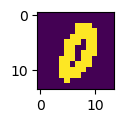

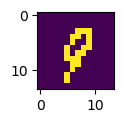

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16796 rows, 20500 columns and 41000 nonzeros
Model fingerprint: 0x766337e3
Model has 15600 general constraints
Variable types: 0 continuous, 20500 integer (20500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-09, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start did not produce a new incumbent solution

Presolve added 90009 rows and 0 columns
Presolve removed 0 rows and 7807 columns
Presolve time: 0.02s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


AttributeError: Unable to retrieve attribute 'objVal'

In [67]:
thresh = torch.Tensor([0.3])

test_img1 = dataset[0][2, 0]
test_img1 = (test_img1 > thresh).float() * 1
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][29, 0]
test_img2 = (test_img2 > thresh).float() * 1
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

# image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)
initialize_model_values()
image_diff = get_similarity(test_img2, test_img1, image_width, image_height, window_size, False)
print(image_diff)

shift_vals = m.getVars()

plt.imshow(test_img2)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img2[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img1)
plt.show()

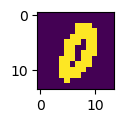

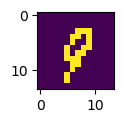

[2.69e-07, 2.810000000000001e-07]


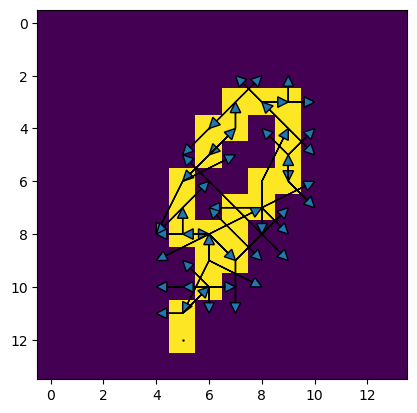

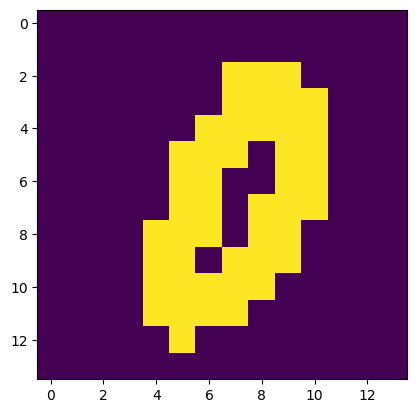

In [24]:
thresh = torch.Tensor([0.3])

test_img1 = dataset[0][2, 0]
test_img1 = (test_img1 > thresh).float() * 1
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][29, 0]
test_img2 = (test_img2 > thresh).float() * 1
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

shift_vals = m.getVars()

plt.imshow(test_img2)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img2[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img1)
plt.show()

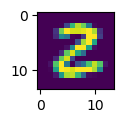

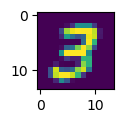

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17576 rows, 37660 columns and 42560 nonzeros
Model fingerprint: 0x42a2af19
Model has 32760 general constraints
Variable types: 0 continuous, 37660 integer (37660 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 208.199 (0.04s)
Loaded user MIP start with objective 208.199

Presolve added 10604 rows and 0 columns
Presolve removed 0 rows and 30632 columns
Presolve time: 1.54s
Presolved: 28180 rows, 7028 columns, 95888 nonzeros
Variable types: 0 continuous, 7028 integer (7028 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Orde

[197.46470980650233, 0]


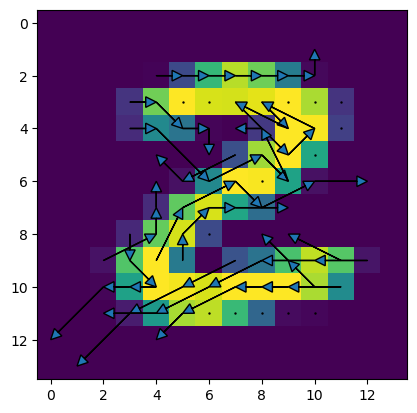

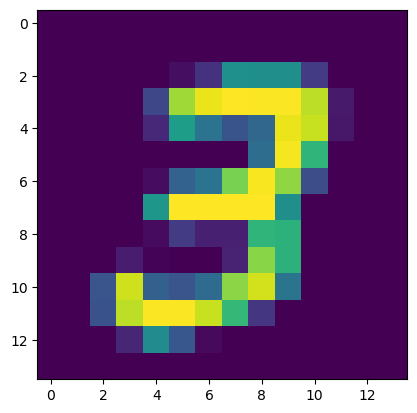

In [30]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][9, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

shift_vals = m.getVars()

plt.imshow(test_img1)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img1[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img2)
plt.show()

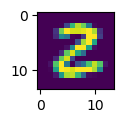

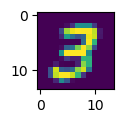

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21164 rows, 44836 columns and 49736 nonzeros
Model fingerprint: 0x00d69ed3
Model has 39936 general constraints
Variable types: 0 continuous, 44836 integer (44836 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 208.199 (0.05s)
Loaded user MIP start with objective 208.199

Presolve added 34100 rows and 0 columns
Presolve removed 0 rows and 34466 columns
Presolve time: 2.06s
Presolved: 55264 rows, 10370 columns, 188780 nonzeros
Variable types: 0 continuous, 10370 integer (10370 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root relaxation preso

   408   281  197.97850   13 2415  200.77807  197.80596  1.48%  1917  152s
   420   287  198.23802   15 2610  200.77807  197.80596  1.48%  1950  158s
   426   305  198.35865   14 2612  200.77807  197.80596  1.48%  1986  169s
   444   320  198.02710   17 2606  200.77807  197.80596  1.48%  2024  175s
   459   329  198.51527   18 2786  200.77807  197.80596  1.48%  2052  181s
H  466   327                     200.6975298  197.80596  1.44%  2061  181s
   468   341  198.13803   19 2572  200.69753  197.80596  1.44%  2069  187s
   482   358  198.31027   20 2541  200.69753  197.80596  1.44%  2078  194s
H  513   358                     200.6975295  197.80596  1.44%  2032  194s
H  513   351                     200.6465398  197.80596  1.42%  2032  194s
   514   363  198.39590   23 2798  200.64654  197.80596  1.42%  2036  200s
   534   386  198.98032   24 2805  200.64654  197.80596  1.42%  2037  206s
H  549   383                     200.6042677  197.80596  1.39%  2019  206s
   557   399  199.80212  

  1569  1015  198.83892   65 2756  200.19765  198.10090  1.05%  2989  953s
  1588  1033  198.85304   66 2773  200.19765  198.10090  1.05%  3008  963s
  1617  1041  198.89066   69 2652  200.19765  198.10090  1.05%  3031  976s
  1636  1069  198.93161   70 2726  200.19765  198.10090  1.05%  3050  989s
  1679  1075  199.00108   72 2661  200.19765  198.10090  1.05%  3052 1004s
H 1687  1031                     200.1474088  198.10090  1.02%  3058 1004s
  1711  1050  199.37470   72 2976  200.14741  198.10090  1.02%  3059 1017s
  1757  1045  199.06776   75 2628  200.14741  198.10090  1.02%  3047 1031s
H 1803  1003                     200.0861496  198.10090  0.99%  3053 1064s
  1834  1013  199.12010   78 2492  200.08615  198.10090  0.99%  3040 1078s
  1898   999  199.66809   81 2642  200.08615  198.10090  0.99%  3022 1094s
H 1946   908                     199.9222376  198.10090  0.91%  2998 1094s
  1952   924  199.25057   85 2625  199.92224  198.10090  0.91%  3007 1152s
  1974   945  199.65688  

 20778  8294  199.25877   48 2152  199.34525  198.63509  0.36%  2761 11793s
 20780  8295  199.31267   48 2288  199.34525  198.63509  0.36%  2761 11958s
 20781  8296  199.21143   46 2087  199.34525  198.63509  0.36%  2761 12113s
 20782  8297  198.85810   44 2237  199.34525  198.63509  0.36%  2761 12280s
 20783  8297  199.18639   30 2038  199.34525  198.63509  0.36%  2761 12448s
 20785  8299  199.16048   62 2206  199.34525  198.63509  0.36%  2760 12621s
 20786  8299  199.29450   65 2148  199.34525  198.63509  0.36%  2760 12793s
 20787  8300  198.93129   38 2145  199.34525  198.63509  0.36%  2760 12963s
 20788  8301  198.84856   34 2105  199.34525  198.63509  0.36%  2760 13124s
 20789  8301  198.89587   40 2189  199.34525  198.63509  0.36%  2760 13310s
 20790  8302  199.12027   47 2121  199.34525  198.63509  0.36%  2760 13491s
 20792  8303  199.04548   43 2201  199.34525  198.63509  0.36%  2760 13685s
 20793  8304  199.11961   49 2092  199.34525  198.63509  0.36%  2759 13867s
 20794  8305

 23322  8453     cutoff   57       199.34525  198.87591  0.24%  2749 15688s
 23537  8429  199.18819   46 2745  199.34525  198.88655  0.23%  2738 15735s
 23677  8474  199.08141   41 2695  199.34525  198.89501  0.23%  2736 15786s
 23840  8530  199.18511   67 1654  199.34525  198.89641  0.23%  2735 15841s
 24051  8578  199.21083   46 2689  199.34525  198.90439  0.22%  2729 15896s
 24272  8703  199.11439   61 2061  199.34525  198.90970  0.22%  2722 15957s
 24609  8630  199.30262   50 1991  199.34525  198.91609  0.22%  2705 16019s
 24802  8616  199.24386   58 2434  199.34525  198.92223  0.21%  2705 16101s
 24899  8672  199.17469   52 2471  199.34525  198.92625  0.21%  2704 16171s
 25143  8710     cutoff   59       199.34525  198.92983  0.21%  2696 16246s
 25400  8686  199.01925   56 2708  199.34525  198.93749  0.20%  2688 16331s
 25566  8721  199.13899   56 1566  199.34525  198.94083  0.20%  2686 16424s
 25845  8742     cutoff   60       199.34525  198.94708  0.20%  2683 16519s
 26150  8757

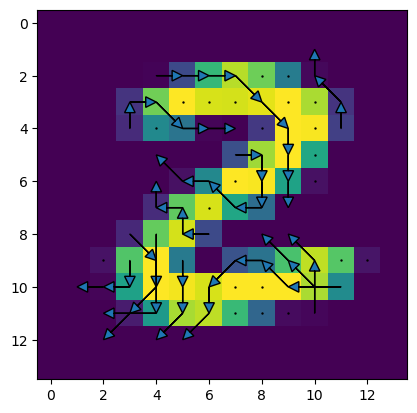

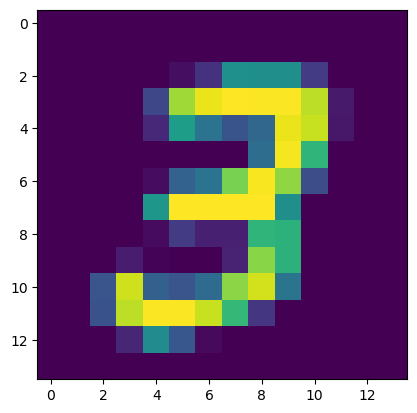

In [11]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][9, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

shift_vals = m.getVars()

plt.imshow(test_img1)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img1[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img2)
plt.show()

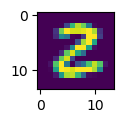

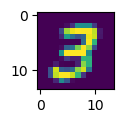

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29276 rows, 61060 columns and 65960 nonzeros
Model fingerprint: 0x762ad1ea
Model has 56160 general constraints
Variable types: 0 continuous, 61060 integer (61060 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 208.199 (0.07s)
Loaded user MIP start with objective 208.199

Presolve added 14853 rows and 0 columns
Presolve removed 0 rows and 52568 columns
Presolve time: 3.46s
Presolved: 44129 rows, 8492 columns, 147627 nonzeros
Variable types: 0 continuous, 8492 integer (8492 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root relaxation presolve

   134   171  198.28709   20 1926  203.47030  198.21806  2.58%  1698   62s
H  170   208                     203.1404690  198.21806  2.42%  1686   69s
H  197   208                     202.5751000  198.21806  2.15%  1676   69s
   207   257  198.80540   35 1947  202.57510  198.21806  2.15%  1679   75s
H  256   305                     202.5709320  198.21806  2.15%  1620   82s
H  270   305                     202.5506633  198.21806  2.14%  1594   82s
   304   354  200.94265   51 2427  202.55066  198.21806  2.14%  1601   89s
   363   410  199.58233   55 1806  202.55066  198.21806  2.14%  1531  104s
H  402   404                     201.8059053  198.21806  1.78%  1442  104s
   437   433     cutoff   69       201.80591  198.21806  1.78%  1487  116s
   506   518  198.24562   37 2018  201.80591  198.21806  1.78%  1448  130s
H  593   557                     200.8280623  198.21806  1.30%  1465  146s
   705   591  200.05028  107 1599  200.82806  198.21806  1.30%  1443  163s
H  745   591             

  3255  1414  198.70861   40 2324  199.93361  198.59934  0.67%  1711  871s
  3300  1523  199.10744   51 2135  199.93361  198.59934  0.67%  1713  891s
  3445  1613  199.44501   68 1729  199.93361  198.60131  0.67%  1698  908s
  3575  1698  198.77679   39 1929  199.93361  198.61252  0.66%  1688  934s
  3719  1761  199.55405   44 2420  199.93361  198.61797  0.66%  1682  956s
  3824  1806  199.36788   43 2047  199.93361  198.62451  0.65%  1692  980s
  3912  1887  199.03830   40 2186  199.93361  198.62915  0.65%  1709 1014s
  4054  1932  199.29929   42 2346  199.93361  198.63642  0.65%  1715 1038s
H 4086  1932                     199.9336101  198.63642  0.65%  1714 1038s
  4142  1987     cutoff   64       199.93361  198.63862  0.65%  1729 1063s
  4220  2058  199.66487   46 2286  199.93361  198.64536  0.64%  1735 1088s
  4349  2216  199.77528   51 2275  199.93361  198.65203  0.64%  1736 1114s
  4567  2296  199.66145   82 1703  199.93361  198.65300  0.64%  1721 1145s
H 4738  2349             

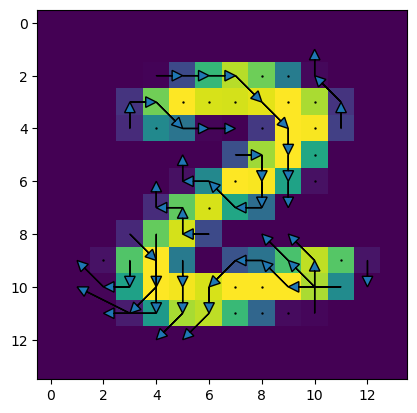

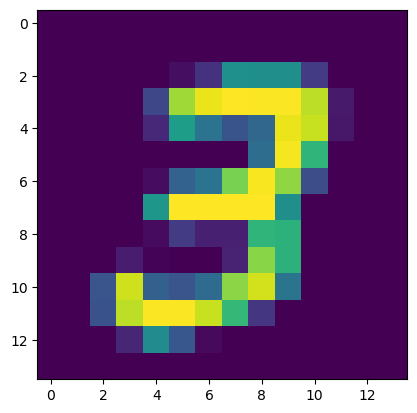

In [33]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][9, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

shift_vals = m.getVars()

plt.imshow(test_img1)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img1[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img2)
plt.show()

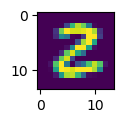

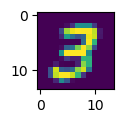

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29276 rows, 61060 columns and 65960 nonzeros
Model fingerprint: 0x762ad1ea
Model has 56160 general constraints
Variable types: 0 continuous, 61060 integer (61060 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 208.199 (0.07s)
Loaded user MIP start with objective 208.199

Presolve added 14853 rows and 0 columns
Presolve removed 0 rows and 52568 columns
Presolve time: 3.41s
Presolved: 44129 rows, 8492 columns, 147627 nonzeros
Variable types: 0 continuous, 8492 integer (8492 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root relaxation presolve

H  402   404                     201.8059053  198.21806  1.78%  1442  103s
   437   433     cutoff   69       201.80591  198.21806  1.78%  1487  115s
   506   518  198.24562   37 2018  201.80591  198.21806  1.78%  1448  128s
H  593   557                     200.8280623  198.21806  1.30%  1465  144s
   705   591  200.05028  107 1599  200.82806  198.21806  1.30%  1443  161s
H  745   591                     200.7608708  198.21806  1.27%  1429  161s
   814   656  199.69801   13 2145  200.76087  198.21806  1.27%  1456  178s
H  832   650                     200.7392291  198.21806  1.26%  1457  178s
H  855   649                     200.7164187  198.21806  1.24%  1468  178s
H  857   596                     200.2776625  198.21806  1.03%  1465  178s
   899   692     cutoff   36       200.27766  198.21806  1.03%  1480  197s
  1030   692  198.29685   26 1752  200.27766  198.21806  1.03%  1441  211s
  1032   693  199.82365   27 2065  200.27766  198.21806  1.03%  1438  216s
  1033   694  198.42225  

  4142  1987     cutoff   64       199.93361  198.63862  0.65%  1729 1084s
  4220  2058  199.66487   46 2286  199.93361  198.64536  0.64%  1735 1109s
  4349  2216  199.77528   51 2275  199.93361  198.65203  0.64%  1736 1138s
  4567  2296  199.66145   82 1703  199.93361  198.65300  0.64%  1721 1172s
H 4738  2349                     199.9123415  198.66236  0.63%  1720 1206s
  4857  2399     cutoff   69       199.91234  198.66385  0.62%  1722 1244s
  4985  2450  199.57685   46 2232  199.91234  198.68163  0.62%  1733 1292s
  5061  2597     cutoff   51       199.91234  198.68274  0.62%  1740 1339s
  5314  2756  199.68544   45 2186  199.91234  198.68476  0.61%  1728 1388s
  5554  2920  199.17890   47 1749  199.91234  198.68844  0.61%  1721 1436s
H 5815  2974                     199.8835833  198.69488  0.59%  1710 1486s
  5981  2998     cutoff   63       199.88358  198.70094  0.59%  1712 1548s
H 6028  2269                     199.6401923  198.70317  0.47%  1712 1548s
  6077  2252     cutoff  

In [ ]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()


test_img2 = dataset[0][9, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img2)
plt.show()

image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

shift_vals = m.getVars()

plt.imshow(test_img1)
for val in shift_vals:
    if val.X == 1:
        index = find_between(val.VarName, "[", "]").split(",")
        if len(index) != 4:
            continue
        if test_img1[int(index[0]), int(index[1])] > 0:
            if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
            else:
                plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
#             plt.arrow(int(index[1]), int(index[0]), 1, 1)
#             print(index)
plt.show()
plt.imshow(test_img2)
plt.show()

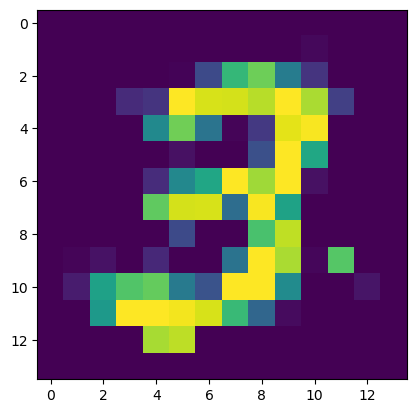

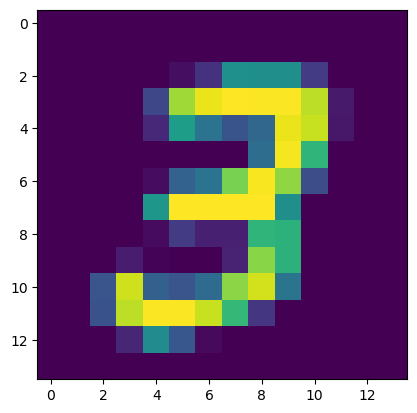

In [34]:
generate_mapped_img(test_img1)
plt.imshow(test_img2)
plt.show()